# Lyrix
## Semester project - Report
<b> Olivier Couque & Emma Lejal Glaude <br>
Supervisor: Panayotis Smeros, Lab: LSIR </b><br>

The goal of this project is to merge lyrics from two different music genres. <br>
Table of content:
1. [Data Gathering](#data)
2. [Data Cleaning](#cleaning)
3. [Preprocessing](#process)
4. [MUSE](#muse)
5. [Neural Network](#nn)
6. [Webpage](#site)

<a id="top"></a>

### Litterature

Regarding this project we had the following sources:
- https://github.com/robbiebarrat/rapping-neural-network
- http://www.encore.ai
- https://github.com/tonybeltramelli/Deep-Lyrics
- https://raplyrics.eu

[Go to top](#top)

<a id="data"></a>

In [1]:
#Usefull imports
import numpy as np
import pandas as pd
from langdetect import detect
import matplotlib.pyplot as plt
import time
import re
import pickle
import requests
from bs4 import BeautifulSoup
import string
import sys
import codecs
import json
import spacy
import random
import csv
import pyphen
from collections import Counter

## Data Gathering

To gather data we had multiple difficulties. First of all we need entire lyrics and not only the bag of words contained in the lyrics. However this is difficult to get as the lyrics are protected by Intellectual Property. Consequently there are no open database with entire lyrics available. On top of this, we need the lyrics classified according with the different musical genres. <br>
We started to look for datasets and encountered the One Million Song Dataset, unfortunately, this dataset contains only the bag of words. Afterwards we considered the MusicBrainz dataset but realized we could only get about a third of the lyrics per song. <br>
We turned to the Kaggle website to look for datasets and found the following ones :
- https://www.kaggle.com/gyani95/380000-lyrics-from-metrolyrics

In [2]:
filepath = '../kaggleDataset/lyrics.csv' #'kaggle_lyrics.csv' # File too big for Github, download it on kaggle and put it in the same folder
lyrics_df = pd.read_csv(filepath)
lyrics_df.set_index('index', inplace = True)

In [3]:
print("Number of songs: {}".format(len(lyrics_df)))
lyrics_df.head()

Number of songs: 362237


,song,year,artist,genre,lyrics
index,,,,,
0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."


Some songs have no lyrics availaible, we remove them.

In [4]:
lyrics_df.dropna(axis = 'index', subset = ['lyrics'], inplace = True)
print("Number of songs WITH available lyrics: {}".format(len(lyrics_df)))

Number of songs WITH available lyrics: 266557


In [5]:
artists = set(lyrics_df["artist"])
genres = set(lyrics_df["genre"])

In [6]:
print("Genres: {}".format(genres))
print("Number of artists: {}".format(len(artists)))

Genres: {'Rock', 'Metal', 'Hip-Hop', 'Jazz', 'Other', 'Indie', 'Not Available', 'Country', 'Pop', 'Folk', 'R&B', 'Electronic'}
Number of artists: 14543


In [7]:
songs_per_genre = {}
total_songs = 0
unknown_songs = 0
for genre in genres:
    nb = len(lyrics_df[lyrics_df['genre'] == genre])
    songs_per_genre[genre] = nb
    total_songs += nb
    if genre == "Not Available" or genre == "Other":
        unknown_songs += nb
songs_per_genre

{'Rock': 109235,
 'Metal': 23759,
 'Hip-Hop': 24850,
 'Jazz': 7971,
 'Other': 5189,
 'Indie': 3149,
 'Not Available': 23941,
 'Country': 14387,
 'Pop': 40466,
 'Folk': 2243,
 'R&B': 3401,
 'Electronic': 7966}

We use the detect library to detect the main language of each song and remove the songs that are detected as NOT english. Note that this library isn't perfect and will predict as english some french or spanish songs for instance. So we might found some of non english songs or words in the rest of the project. Making sure that all songs are in english could be an improvement of the project.

In [ ]:
def language_of_lyrics(lyrics):
    try:
        lang = detect(lyrics)
        return lang
    except:
        return "no lang"

# RUNNING THIS CELL TAKES SOME TIMES SO WE SAVED THE LANGUAGE IN A FILE
list_langs = []
for i, row in lyrics_df.iterrows():
    if i % 1000 == 0:
        print(i)
    lang = language_of_lyrics(row['lyrics'])
    list_langs.append(lang)

In [ ]:
lyrics_df['language'] = list_langs

In [ ]:
# Save file
lyrics_df.to_csv("kaggle_lyrics_with_lang.csv")

In [11]:
# Load file
lyrics_df = pd.read_csv("kaggle_lyrics_with_lang.csv")

FileNotFoundError: File b'kaggle_lyrics_with_lang.csv' does not exist

In [ ]:
english_df = lyrics_df[lyrics_df['language'] == 'en']
print(len(english_df))
english_df.head()

We will have a look at the distribution of the lyrics that we have. First we need to identify the main genre per artist. To do this we will use the Spotify API.

In [13]:
import spotipy
import spotipy.oauth2 as oauth2
import spotipy.util as util

In [15]:
client_id = "c829ff34022d4c3a9e65c30c10623765"
client_secret = "8e998357ebf04fe092edab4915946e00"

credentials = oauth2.SpotifyClientCredentials(client_id, client_secret)

token = credentials.get_access_token()
sp = spotipy.Spotify(auth=token)

In [16]:
filepath = "mb_music.csv" #we use a file from MusicBrainz to gather artists names
lyrics_df = pd.read_csv(filepath)
useful_df = lyrics_df[['artist.name', 'terms']]
useful_df.head()

,artist.name,terms
0,Casual,hip hop
1,The Box Tops,blue-eyed soul
2,Sonora Santanera,salsa
3,Adam Ant,pop rock
4,Gob,pop punk


In [18]:
with open ('en_artists_from_musicbrainz', 'rb') as fp:
    english_artist = pickle.load(fp)

In [19]:
len(english_artist)

365691

In [20]:
def get_artist_genres(artist_name):
    """ Fetch on Spotify the genres of the artist"""
    query = sp.search(q='artist:' + artist_name, type='artist')
    if len(query['artists']['items']) > 0:
        genres = query['artists']['items'][0]['genres'] # list: ["pop rock", "hard rock", "alternative rock"...]
        return genres
    else:
        #print("{} not on Spotify".format(artist_name))
        return []

In [21]:
def refresh_token():
    token = credentials.get_access_token()
    sp = spotipy.Spotify(auth=token)

Fetch genres for all artists of the file:

In [ ]:
artist_genre = []
artists = english_artist
artists_with_error = []

start = time.time()
print("Initial number of artists: {}".format(len(artists)))
for i, artist in enumerate(artists):
    if i % 500 == 0:
        print(i)
    if (time.time() - start)>= 3600:
        start = time.time()
        refresh_token()
    try:
        genres = get_artist_genres(artist)
        if len(genres) > 0:
            artist_genre.append([artist, genres])
    except :
        artists_with_error.append(artist)
        #print("error for artist : ", artist)
print("Number of artists with genres on Spotify: {}".format(len(artist_genre)))

In [ ]:
artist_genres_df = pd.DataFrame(artist_genre, columns = {'artist', 'genre'})
artist_genres_df = artist_genres_df.drop_duplicates('artist')
artist_genres_df.to_csv("artist_genre.csv", sep=';')

In [8]:
MAIN_GENRES = {'metal', 'hip hop', 'country', 'jazz', 'pop', 'rock'}

artist_path = "../kaggleDataset/artist_genre.csv"
artist_genres_df = pd.read_csv(artist_path, sep = ';', usecols = ["artist", "genre"])
artist_genres_df.head() # The genre field is a string and not a list

,artist,genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']"
1,Jimmy Hughes,['southern soul']
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',..."
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '..."
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk..."


Spotify can give many genres to the artists, we will define each artist by one main genre (from the MAIN_GENRES). Typically, Black Eyed Peas is characterized by genres: 'dance pop', 'pop', 'pop rap', there is a majority of 'pop' appearing so we would associate Black Eyed Peas to the 'pop' genre

In [9]:
def get_main_genre(genres, main_genres = MAIN_GENRES):
    """ Count occurences of main genres terms in the genres string"""
    main_genres_occ = [(g, len(re.findall(g, genres))) for g in main_genres if len(re.findall(g, genres)) > 0] # list: [(rock, 3), (pop, 1), (hard, 1)...]
    
    if len(main_genres_occ) > 0:
        max_genre = sorted(main_genres_occ, key = lambda x: x[1], reverse = True)[0][0]
        return max_genre
    else:
        return "No main genre"

In [10]:
simple_genres = []
for i, artist_row in artist_genres_df.iterrows():
    genres = artist_row['genre']
    main_genre = get_main_genre(genres)
    simple_genres.append(main_genre)

col_name = "main genre"
if col_name in list(artist_genres_df.columns):
    artist_genres_df.drop(col_name, inplace = True)
artist_genres_df[col_name] = simple_genres
artist_genres_df.head()

,artist,genre,main genre
0,Black Eyed Peas,"['dance pop', 'pop', 'pop rap']",pop
1,Jimmy Hughes,['southern soul'],No main genre
2,Joy Division,"['alternative rock', 'art rock', 'dance rock',...",rock
3,Mint Condition,"['dance pop', 'funk', 'hip pop', 'neo soul', '...",pop
4,Plump DJs,"['big beat', 'breakbeat', 'electronic', 'nu sk...",No main genre


In [ ]:
# Save the dataframe with main genre in a csv file
artist_genres_df = genres_df[["artist", "main genre"]]
#useful_df.to_csv("artists_main_genre.csv", index = False)

In [25]:
#artist_genres_df = pd.read_csv("artists_main_genre.csv")

Number of artists: 2727
Number of artists with main genre: 1748
Ratio: 0.640997433076641


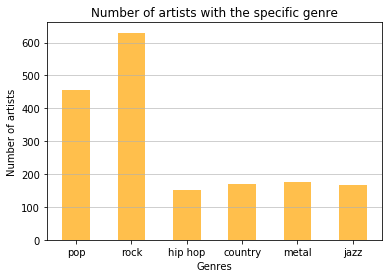

In [11]:
print("Number of artists: {}".format(len(artist_genres_df)))
genres_df = artist_genres_df[artist_genres_df["main genre"] != "No main genre"]
print("Number of artists with main genre: {}".format(len(genres_df)))
print("Ratio: {}".format(len(genres_df) / len(artist_genres_df)))

n, bins, patches = plt.hist(x = list(genres_df["main genre"]), bins=np.arange(0,len(MAIN_GENRES) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.show()

In [13]:
english_df = pd.read_csv("../kaggleDataset/lyrics_cleaned.csv")
artist_genre_df = pd.read_csv("../kaggleDataset/artists_main_genre.csv")
artist_genre_df.head()

,artist,main genre
0,Black Eyed Peas,pop
1,Joy Division,rock
2,Mint Condition,pop
3,Plump DJs,electronic
4,Jope Ruonansuu,pop


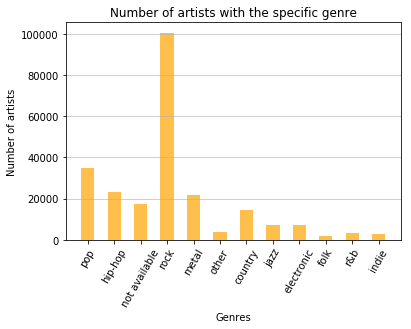

In [14]:
n, bins, patches = plt.hist(x = list(english_df["genre"]), bins=np.arange(0,len(set(english_df["genre"])) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of artists')
plt.title('Number of artists with the specific genre')
plt.xticks(rotation=60)
plt.show()

We can see that we have enough songs for the rock genre. We will try to complete the dataset with other songs.

In [15]:
main_lyrics_df = english_df[english_df['genre'].isin(MAIN_GENRES)]
print("Ratio of lyrics kept from main genres: {}".format(len(main_lyrics_df) / len(english_df)))

# Give same format of artist names in both dataframes:
main_lyrics_df['artist'] = main_lyrics_df['artist'].apply(lambda a: a.replace('-', ' ').lower()) # beyonce-knowles -> beyonce knowles
artist_genre_df['artist'] = artist_genre_df['artist'].apply(lambda a: a.replace('-', ' ').lower())
# Create dictionary of artist - genre
artist_genre_dict = dict(zip(list(artist_genre_df['artist']), list(artist_genre_df['main genre'])))

# Get the set of artists for which we don't already have the lyrics
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
print("Artists to fetch number: {} , ratio: {}".format(len(artists_to_fetch), len(artists_to_fetch) / len(set(artist_genre_df['artist']))))

Ratio of lyrics kept from main genres: 0.7492769865555178
Artists to fetch number: 1480 , ratio: 0.8249721293199554


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


We try to scrap a first website (https://www.lyricsfreak.com) to complete the lyrics. The idea was to fetch all the lyrics of a given artist from the website and include them in our dataset. We used these methods on the artists found in the previous steps because we knew the genre associated to each of these artists 

The following methods might not work correctly when you try to execute them because the html classes on the website happens to change. Last time tested: 30th December 2018 

In [18]:
url_lyricsfreak = 'https://www.lyricsfreak.com'

In [50]:
def get_lyrics_from_link(url):
    response = requests.get(url).content
    soup_lyrics = BeautifulSoup(response, "lxml")
    # Get lyrics from the link
    lyrics_html = soup_lyrics.find_all('div', class_= "dn") # found by inspecting the url
    try:
        lyrics = str(lyrics_html).split('content_h">')[1].split('</div>')[0]
    except IndexError:
        # Some lyrics have an url but acces is restricted
        print("Lyrics restricted for URL {}".format(url))
        return ''
    # Replace line jump (<br/>) with puctuation .
    lyrics_cleaned = lyrics.replace('<br/>', '. ')
    return lyrics_cleaned


# Given an artist name, get all his songs and lyrics available on lyricsfreak
def get_songs_from_artist(artist_name, genre):
    # Convert artist name to right format for the url
    artist = artist_name.lower()
    first_char = artist[0]
    artist_url = artist.replace(' ', '+') # Name with spaces
    url = url_lyricsfreak + '/' + first_char + '/' + artist_url + '/'
    # Get HTML info on URL
    response = requests.get(url).content
    soup = BeautifulSoup(response, "lxml")
    
    # Get all songs from that artist on the website
    songs_html = soup.find_all('a', {'class': 'lf-link lf-link--secondary'}) # parameters found by inspecting the url, might change overtime
    songs_name_link = []
    for song in songs_html:
        song = str(song)
        if artist_url + '/' in song:
            link = song.split(artist_url + '/')[1].split('"')[0]
            if 'title="' in song:
                song_name = song.split('title="')[1].split(' Lyrics"')[0]
            else:
                song_name = song.split("title='")[1].split(' Lyrics"')[0]
            # Fetch the lyrics for this song
            url_lyrics = url + link
            lyrics = get_lyrics_from_link(url_lyrics)
            if lyrics != '':
                # Get same format as the rows of the main_lyrics_df
                year = None
                language = None
                songs_name_link.append([song_name, year, artist_name, genre, lyrics, language])
    return songs_name_link

Let's fetch all the lyrics availaible on the website for 2 given artists:

In [52]:
test_artists = ['Northlane', 'Mac Miller']
test_dict = {test_artists[0]: 'metal', test_artists[1]: 'hip hop'}
lyrics_test = []

for artist in test_artists:
    genre = test_dict[artist]
    artist_lyrics = get_songs_from_artist(artist, genre)
    print("{} - Number of lyrics found: {}".format(artist, len(artist_lyrics)))
    lyrics_test.append(artist_lyrics)

Northlane - Number of lyrics found: 32
Mac Miller - Number of lyrics found: 200


In [34]:
songs_per_genre = {}
genres = [g.lower() for g in MAIN_GENRES]
for genre in genres:
    if genre == "hip hop":
        songs_per_genre[genre] = len(english_df[english_df["genre"] == 'hip-hop'])
    else :
        songs_per_genre[genre] = len(english_df[english_df["genre"] == genre])
print(songs_per_genre)
print(MAIN_GENRES)

{'rock': 100565, 'country': 14252, 'pop': 34807, 'hip hop': 23035, 'jazz': 7351, 'metal': 21532}
{'rock', 'country', 'pop', 'hip hop', 'jazz', 'metal'}


In [35]:
artists_to_fetch = set(artist_genre_df['artist']).difference(set(main_lyrics_df['artist']))
print("Total length of artists to fetch: {}".format(len(artists_to_fetch)))

genres_to_fetch = ["metal", "jazz", "country","hip hop", "pop"]

artists_to_fetch = [a for a in artists_to_fetch if artist_genre_dict[a] in genres_to_fetch]
print("Length of artists to fetch : {}".format(len(artists_to_fetch)))

Total length of artists to fetch: 1480
Length of artists to fetch : 947


Let's fetch all the songs for all the artists for which we don't have their lyrics in the english_df dataframe and for which we know their associated main genre. In order to get approximately the same number of songs for each genre, we will set a threshold (e.g. 50'000 songs). Once we have fetched online this threshold from a particular genre we make sure not to fetch any more songs from following artists of this genre

In [ ]:
songs_per_genre_copy = songs_per_genre.copy()
THRESHOLD = 50000
# Create empty dataframe to store results
new_lyrics_df = pd.DataFrame(columns = list(main_lyrics_df.columns))

for i, artist in enumerate(artists_to_fetch):
    if i % 20 == 19:
        print("Percentage Completion: {}% , Lyrics Obtained: {}".format(100*i / len(list(artists_to_fetch)), len(new_lyrics_df)))
        secs_sleep = 60
        print("Now sleeping {} seconds".format(secs_sleep))
        time.sleep(secs_sleep)
    genre = artist_genre_dict[artist]
    nbr_songs_of_genre = songs_per_genre_copy[genre]
    if nbr_songs_of_genre < THRESHOLD:
        artist_lyrics = get_songs_from_artist(artist, genre)
        if len(artist_lyrics) == 0:
            print("Artist {} not found on lyricsfreak".format(artist))
        else:
            list_to_df = pd.DataFrame(artist_lyrics, columns = list(main_lyrics_df.columns))
            new_lyrics_df = new_lyrics_df.append(list_to_df)
            songs_per_genre_copy[genre] += len(artist_lyrics)

In [ ]:
# Save computed lyrics
#new_lyrics_df.to_csv("kaggleDataset/lyrics_augmented.csv", index = False)

We will now try to scrap another website, which allows us to get the lyrics for a given genre:

https://www.lyrics.com

In [58]:
url = 'https://www.lyrics.com/genres.php?genre='
genres = ['Pop', 'Hip%20Hop','Folk,%20World,%20__%20Country', 'Jazz', 'Rock']

We define all the useful functions to fetch the lyrics on this website:

In [65]:
def get_artist(div):
    return div.find_all('p', class_ = "lyric-meta-album-artist")[0].getText()

def get_lyrics_from_url(lyrics_url):
    r = requests.get('https://www.lyrics.com/' + lyrics_url).content
    soup = BeautifulSoup(r, "lxml")
    try : 
        l = soup.find_all('pre')[0].getText()
    except : 
        l = 'NaN'
    return l

def get_lyrics(lyrics_url):
    l = ''
    while l == '':
        try:
            l = get_lyrics_from_url(lyrics_url)
        except:
            print("Slept for : ", lyrics_url)
            time.sleep(5)
            continue
    return l

def get_title_url(div):
    data = div.find_all('p', class_= "lyric-meta-title")[0]
    lyrics_url = data.find_all('a', href = True)[0]['href']
    title = data.getText()
    return title, lyrics_url

def get_artist_from_page(df, genre, nb):
    page_url = url + genre + '&p=' + str(nb)
    resp = requests.get(page_url).content
    soup = BeautifulSoup(resp, "lxml")
    content = soup.find_all('div', class_= "lyric-meta col-sm-6 col-xs-6")
    for c in content:
        t, l = get_title_url(c)
        df.loc[len(df)] = [t, get_artist(c), genre, l]
    return df

We will first fetch songs information and the url where we can find the lyrics and then we will go through all the urls to fetch the actual lyrics

In [71]:
# Define the number of pages for which we want to get the lyrics online
MIN_PAGES = 0
MAX_PAGES = 3000
lyrics_com_df = pd.DataFrame(columns=['title','artist', 'genre', 'lyrics_url'])

In [72]:
for genre in genres:
    for page in range(MIN_PAGES, MAX_PAGES + 1):
        get_artist_from_page(lyrics_com_df, genre, page)
        if page % 100 == 0:
            print('finished genre : ', genre, ' page : ', page)

finished genre :  Pop  page :  0


KeyboardInterrupt: 

In [73]:
def clean_df_for_fetch(df):
    print("Initial length of DF: {}".format(len(df)))
    # Remove duplicate songs from same artist
    cleaned_df = lyrics_df.drop_duplicates(['title', 'artist'])
    print("Length of DF without duplications: {}".format(len(cleaned_df)))
    return cleaned_df

lyrics_dropped = clean_df_for_fetch(lyrics_com_df)
lyrics_com_df.head(10)

Initial length of DF: 24


KeyError: Index(['title'], dtype='object')

In [70]:
lyrics_com_df.head()

,title,artist,genre,lyrics_url
0,Little Things Mean a Lot,Antoinette,Pop,/lyric/31577731/Antoinette/Little+Things+Mean+...
1,Rhymin' and Stealin',Beastie Boys,Pop,/lyric/2567092/Beastie+Boys/Rhymin%27+and+Stea...
2,Rhymin' and Stealin',Beastie Boys,Pop,/lyric/4491990/Beastie+Boys/Rhymin%27+and+Stea...
3,Rhymin & Stealin,Beastie Boys,Pop,/lyric/27285929/Beastie+Boys/Rhymin+%26+Stealin
4,Armada Latina,Cypress Hill,Pop,/lyric/19375506/Cypress+Hill/Armada+Latina


We can fetch the actual lyrics from the urls:

In [ ]:
def get_lyrics(lyrics_com_url):
    l = ''
    while l == '':
        try:
            l = get_lyrics_from_url(lyrics_com_url)
        except:
            print("Slept for : ", lyrics_com_url)
            time.sleep(5)
            continue
    return l

In [ ]:
lyrics_com_df['lyrics'] = lyrics_com_df['lyrics_url'].map(lambda x : get_lyrics(x))

In [ ]:
lyrics_com_df = lyrics_com_df.dropna(axis = 1)
lyrics_com_df = lyrics_com_df.drop_duplicates('lyrics')  
lyrics_com_df.head(10)

In [ ]:
genre_dict = {'Pop': 'pop', 'Hip%20Hop' : 'hip hop','Folk,%20World,%20__%20Country': 'country', 'Jazz':'jazz', 'Rock':'rock'}

In [ ]:
new_lyrics_df = lyrics_com_df.drop('lyrics_url', axis = 1)
new_lyrics_df['genre'] = new_lyrics_df['genre'].map(lambda x : genre_dict[x])
new_lyrics_df.to_csv("lyrics_com.csv", index = False)

Merge all the different files gathered

In [ ]:
final_df = pd.concat([oli_df, pd.read_csv(emma_files[0]), pd.read_csv(emma_files[1]), 
                      pd.read_csv(emma_files[2]), pd.read_csv(emma_files[3]),
                      pd.read_csv(emma_files[4]),pd.read_csv(emma_files[5]),pd.read_csv(emma_files[6]),
                     pd.read_csv('lyrics_jazz.csv'), pd.read_csv('lyrics_metal.csv')], ignore_index=True)

In [ ]:
final_df = final_df.drop_duplicates()
final_df = final_df.dropna(subset = ['lyrics'])

In [ ]:
def adapt_genre(x):
    if x == 'hip-hop':
        return 'hip hop'
    elif x =='folk':
        return 'country'
    else:
        return x

final_df['genre'] = final_df['genre'].map(lambda x: adapt_genre(x))

In [ ]:
final_df['genre'].value_counts()

In [ ]:
def clean_name(x):
    try:
        return x.lower().replace(' ', '-')
    except:
        return x

In [ ]:
final_df['title'] = final_df['title'].map(lambda x : clean_name(x))
final_df['artist'] = final_df['artist'].map(lambda x : clean_name(x))

In [ ]:
final_df['lang'] = final_df['lyrics'].map(lambda l : language_of_lyrics(l))

In [ ]:
en_df = final_df[final_df['lang'] == 'en']
en_df = en_df.drop(['lang'], axis = 1)
print(len(en_df))
en_df.head()

In [ ]:
en_df.to_csv("full_en_lyrics.csv", index= False) # LYRICS FINAL du 7 novembre ??

[Go to top](#top)

<a id="cleaning"></a>

## Data Cleaning

In [42]:
filepath = "lyrics_final.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.drop(['language'], axis = 1)
print(len(lyrics_df))
lyrics_df.head()

317015


,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,"Oh baby, how you doing?\r\r\r\r\r\nYou know I'...",ego-remix,2009.0
1,beyonce-knowles,pop,"playin' everything so easy,\r\r\r\r\r\nit's li...",then-tell-me,2009.0
2,beyonce-knowles,pop,If you search\r\r\r\r\r\nFor tenderness\r\r\r\...,honesty,2009.0
3,beyonce-knowles,pop,"Oh oh oh I, oh oh oh I\r\r\r\r\r\n[Verse 1:]\r...",you-are-my-rock,2009.0
4,beyonce-knowles,pop,"Party the people, the people the party it's po...",black-culture,2009.0


--> Remove [...], {...} and (....) and x(digit)

This information gives structure for the singer but not usefull for lyrics. This is [Chorus], choir in parentheses, x2 etc. <br>
To test regex expressions : https://regex101.com

In [44]:
regex_bracket = re.compile("\[(.*?)\]")
regex_parentheses = re.compile("\((.*?)\)")
regex_curly_bracket = re.compile("\{(.*?)\}")
regex_timesx = re.compile("x[0-9]")

def split_words_with_upper(l):
    words = l.split(' ')
    for j, w in enumerate(words):
        idx = -1
        if re.match('[a-z]+[A-Z]+', w):
            for i, c in enumerate(w):
                if c.isupper():
                    idx = i
        if idx != -1:
            words[j] = w[:idx] + ' ' + w[idx:]
    return ' '.join(words)


def clean_structure_words(l):
    res= regex_bracket.sub('', l)
    res = regex_parentheses.sub('', res)
    res = regex_curly_bracket.sub('', res)
    res = regex_timesx.sub('', res)
    res = split_words_with_upper(res)
    res = res.lower()
    return res

In [ ]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_structure_words(x))
lyrics_df.tail()

--> Remove . , ! ? ... ---
- We want to keep the * as this represents some swear words in english
- We want to keep the ' as this is part of many words in english, especially when words are cropped, ie 'Cause 
- Otherwise punctuation is not meaningful

In [ ]:
chars_to_keep = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ* \n"

def clean_punctuation(l):
    #res = regex_punct.sub('', l)
    res = re.sub(' +', ' ', l)#res)
    res = res.replace("'", ' ') # replace the quotes with a space.
    res = ''.join(char for char in res if char in chars_to_keep)
    return res

In [ ]:
lyrics_df['lyrics'] = lyrics_df['lyrics'].apply(lambda x : clean_punctuation(x))
lyrics_df.tail()

[Go to top](#top)

<a id="process"></a>

## Data Preprocessing

Create FastText vectors : https://fasttext.cc/docs/en/unsupervised-tutorial.html

In [ ]:
# First create a txt file with the lyrics
f = open("lyrics.txt", "w+")
for i, r in lyrics_df.iterrows():
    f.write(r['lyrics'])
    
f.close()

In [ ]:
# Generate embeddings
! ./fasttext skipgram -input lyrics.txt -output model_full_lyrics

In [ ]:
file_vec = 'model_lyrics3.vec'
file_bin = 'model_lyrics3.bin'

In [ ]:
# Load embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [ ]:
word_embeddings, vocabulary = load_embeddings(file_vec)
vocabulary = list(vocabulary)

In [ ]:
#If necessary
def get_embedding_for_missing_word(w, file_bin = file_bin):
    #data = ! echo $w | ./fasttext print-word-vectors model_lyrics.bin #emma
    data = ! echo $w | ./fasttext print-word-vectors $file_bin #oli
    emb = np.zeros(100)
    for i, x in enumerate(data[0].split( )[1:]):
        try:
            emb[i] = float(x)
        except ValueError:
            print(data[0])
    return emb

In [ ]:
get_embedding_for_missing_word("we re")

--> Create column with indicator of last word of line

In [48]:
def generate_embedding_for_lyrics(l):
    sentences = l.split('\n')
    embedding = []
    for s in sentences:
        words = s.split(' ')
        for i, w in enumerate(words):
            if len(w)>0:
                try : 
                    idx = vocabulary.index(w)
                    vector = word_embeddings[idx]
                except ValueError : 
                    #print("Word not found :", repr(w))
                    vector = get_embedding_for_missing_word(w)
                if i == (len(words)-1) :
                    vector = np.append(vector, 1)
                else :
                    vector = np.append(vector, 0)
                vector = np.append(w, vector)
                embedding.append(vector)
                
    return embedding

In [ ]:
generate_embedding_for_lyrics("oh baby how you doing\nyou know im gonna cut right to the chase")

--> Create column with type of word (noum, verb, etc)

In [ ]:
en_nlp = spacy.load('en')

ADJ: adjective ADP: adposition ADV: adverb AUX: auxiliary verb CONJ: coordinating conjunction DET: determiner INTJ: interjection NOUN: noun NUM: numeral PART: particle PRON: pronoun PROPN: proper noun PUNCT: punctuation SCONJ: subordinating conjunction SYM: symbol VERB: verb X: other

In [49]:
def generate_pos_for_lyrics(l):
    doc = en_nlp(l)
    embedding = []
    for i in range(len(doc)):
        print(doc[i], doc[i].pos_)
        type_ = doc[i].pos_
        if type_ != 'SPACE' and type_ != 'PART':
            embedding.append(type_)
    return embedding

In [50]:
def generate_pos_for_word(w):
    doc = en_nlp(w)
    return doc[0].pos_

In [51]:
pos_to_idx = {'ADJ': 0, 'ADP': 1, 'ADV':2,'AUX': 3,'CONJ': 4,'CCONJ': 5,'DET': 6, 'INTJ': 7, 'NOUN': 8,
              'NUM': 9, 'PART': 10,'PRON':11, 'PROPN': 12, 'PUNCT': 13, 'SCONJ': 14, 'SYM': 15, 
              'VERB': 16, 'X': 17}

In [ ]:
def merge_embedding_pos(l):
    embedding = generate_embedding_for_lyrics(l)
    for i in range(len(embedding)):
        w = embedding[i][0]
        if w != '\n':
            pos = generate_pos_for_word(str(w))
            bin_vector = np.zeros(18)
            bin_vector[pos_to_idx[pos]] = 1
            embedding[i] = np.append(embedding[i], bin_vector)
    return embedding

--> Create column with Entity Recognition

In [ ]:
nlp = spacy.load('en_core_web_sm')

Entity types : <br>
PERSON	People, including fictional.<br>
NORP	Nationalities or religious or political groups.<br>
FAC	Buildings, airports, highways, bridges, etc.<br>
ORG	Companies, agencies, institutions, etc.<br>
GPE	Countries, cities, states.<br>
LOC	Non-GPE locations, mountain ranges, bodies of water.<br>
PRODUCT	Objects, vehicles, foods, etc. (Not services.)<br>
EVENT	Named hurricanes, battles, wars, sports events, etc.<br>
WORK_OF_ART	Titles of books, songs, etc.<br>
LAW	Named documents made into laws.<br>
LANGUAGE	Any named language.<br>
DATE	Absolute or relative dates or periods.<br>
TIME	Times smaller than a day.<br>
PERCENT	Percentage, including "%".<br>
MONEY	Monetary values, including unit.<br>
QUANTITY	Measurements, as of weight or distance.<br>
ORDINAL	"first", "second", etc.<br>
CARDINAL	Numerals that do not fall under another type.<br>

In [ ]:
doc = nlp(lyrics_df.loc[24]['lyrics'].replace('\n', '').lower())
for ent in doc.ents:
    print(ent.text, ent.label_)

In [ ]:
def find_sub_list(sl,l):
    sll=len(sl)
    for ind in (i for i,e in enumerate(l) if e==sl[0]):
        if l[ind:ind+sll]==sl:
            return ind,ind+sll-1

In [ ]:
def get_entity_for_lyrics(l):
    l = l.replace('\n', ' ').lower()
    doc = nlp(l)
    l_list = l.split(' ')
    curr_i = 0
    result = np.empty(shape=len(l_list), dtype=object)
    for ent in doc.ents:
        if ent.text.replace(' ', '') != '':
            ent_list = ent.text.split(' ')
            try:
                s, e = find_sub_list(ent_list, l_list[curr_i:])
                s += curr_i
                e += curr_i
                for i in range(s, e+1):
                    result[i] = ent.label_
                curr_i = e
            except : 
                print(ent_list)
                print(l_list[curr_i:])
    return result

In [ ]:
ent_to_idx = {'PERSON' : 0,
'NORP': 1,
'FAC' : 2,
'ORG' : 3,
'GPE' : 4,
'LOC' : 5,
'PRODUCT' : 6,
'EVENT' : 7,
'WORK_OF_ART' : 8,
'LAW': 9,
'LANGUAGE' : 10,
'DATE' : 11,
'TIME' : 12,
'PERCENT' : 13,
'MONEY' : 14,
'QUANTITY' : 15,
'ORDINAL' : 16,
'CARDINAL': 17}

In [ ]:
def add_ent_to_embedding(emb, l):
    # Compute the entities for the lyrics
    ents = get_entity_for_lyrics(l)
    # Go over the embedding of the words
    for i, w in enumerate(emb):
        # Create empty binary vector
        bin_vector = np.zeros(18)
        # If the entity is None, means we don't know --> Keep all 0s
        if ents[i] != None :
            # Put 1 where the entity is when we know it : current entity is ents[i], pass to index with ent_to_idx
            bin_vector[ent_to_idx[ents[i]]] = 1
        # Add the binary vector at the end of embedding and return
        emb[i] = np.append(w, bin_vector)
    return emb

In [ ]:
add_ent_to_embedding(lyrics_df.loc[0]['embedding'], lyrics_df.loc[0]['lyrics'])

In [ ]:
for i, r in lyrics_df[:30].iterrows() :
    r['embedding'] = add_ent_to_embedding(r['embedding'], r['lyrics'])

[Go to top](#top)

<a id="muse"></a>

## MUSE

## Goal of notebook 
- Create word model for pop and rock
- Compute embeddings for words in pop and rock
- Apply MUSE matching

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [13]:
filepath = "lyrics_final_clean.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.dropna(axis = 0, how='any', subset=['lyrics'])
lyrics_df.head()

,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,oh baby how you doing\nyou know i m gonna cut ...,ego-remix,2009.0
1,beyonce-knowles,pop,playin everything so easy\nit s like you seem...,then-tell-me,2009.0
2,beyonce-knowles,pop,if you search\nfor tenderness\nit isn t hard t...,honesty,2009.0
3,beyonce-knowles,pop,oh oh oh i oh oh oh i\n\nif i wrote a book abo...,you-are-my-rock,2009.0
4,beyonce-knowles,pop,party the people the people the party it s pop...,black-culture,2009.0


## Word Embeddings (Fasttext)

In [3]:
def split_words_with_upper(l):
    words = l.split(' ')
    for j, w in enumerate(words):
        idx = -1
        if re.match('[a-z]+[A-Z]+', w):
            for i, c in enumerate(w):
                if c.isupper():
                    idx = i
        if idx != -1:
            words[j] = w[:idx] + ' ' + w[idx:]
    return ' '.join(words)

In [124]:
split_words_with_upper('Before they do it to you\nI m not sureI m not sure\nMy only tieMy only tieMy only tie\nIs youOnly youOnly you\nMy only tieMy only tieMy only tie\nIs youOnly youOnly you\nI ve been making such a fool of me\nDrinking more than the Irish sea')

'Before they do it to you\nI m not sure I m not sure\nMy only tie My only tie My only tie\nIs you Only you Only you\nMy only tie My only tie My only tie\nIs you Only you Only you\nI ve been making such a fool of me\nDrinking more than the Irish sea'

In [25]:
#Extrat specific genre lyrics
def extract_genre_lyrics(g):
    f = open("lyrics_"+g+".txt", "w+")
    for i, r in lyrics_df[lyrics_df['genre'] == g].iterrows():
        text = r['lyrics']+ '\n'
        #text = split_words_with_upper(text)
        #text = text.lower()
        #text = text.replace("'", ' ')
        f.write(text)

    f.close()

In [26]:
extract_genre_lyrics('pop')

In [27]:
extract_genre_lyrics('rock')

In [28]:
# Generate embeddings pop
! ./fasttext cbow -input lyrics_pop.txt -output cbow_model_lyrics_pop

Read 16M words
Number of words:  29542
Number of labels: 0
Progress: 51.1%  words/sec/thread: 272165  lr: 0.024472  loss: 1.992248  eta: 0h0m 3  lr: 0.049626  loss: 3.257737  eta: 0h3m 0.049613  loss: 3.207300  eta: 0h3m 63737  lr: 0.049182  loss: 2.754653  eta: 0h1m 2.4%  words/sec/thread: 84204  lr: 0.048821  loss: 2.631800  eta: 0h1m   lr: 0.048609  loss: 2.592384  eta: 0h1m hread: 107597  lr: 0.048317  loss: 2.534248  eta: 0h1m 1m   lr: 0.048119  loss: 2.484302  eta: 0h0m   loss: 2.458563  eta: 0h0m hread: 122909  lr: 0.047921  loss: 2.444723  eta: 0h0m   lr: 0.047915  loss: 2.438611  eta: 0h0m hread: 125968  lr: 0.047836  loss: 2.426662  eta: 0h0m   lr: 0.047574  loss: 2.396196  eta: 0h0m   lr: 0.047529  loss: 2.392113  eta: 0h0m   lr: 0.047473  loss: 2.386870  eta: 0h0m s: 5.2%  words/sec/thread: 140984  lr: 0.047380  loss: 2.372880  eta: 0h0m 5.6%  words/sec/thread: 145543  lr: 0.047218  loss: 2.349558  eta: 0h0m 0.046595  loss: 2.283773  eta: 0h0m 0.046542  loss: 2.283545  eta:

In [29]:
# Generate embeddings rock
! ./fasttext cbow -input lyrics_rock.txt -output cbow_model_lyrics_rock

Read 22M words
Number of words:  33988
Number of labels: 0
Progress: 96.3%  words/sec/thread: 308108  lr: 0.001862  loss: 1.944939  eta: 0h0m %  words/sec/thread: 387  lr: 0.049997  loss: 4.139301  eta: 6h46m 0.0%  words/sec/thread: 1330  lr: 0.049991  loss: 4.145312  eta: 1h56m %  words/sec/thread: 52491  lr: 0.049582  loss: 2.945532  eta: 0h2m m 2.810722  eta: 0h1m 147073  lr: 0.048177  loss: 2.465966  eta: 0h1m %  words/sec/thread: 150185  lr: 0.048106  loss: 2.457824  eta: 0h0m   words/sec/thread: 151994  lr: 0.048062  loss: 2.450533  eta: 0h0m 0.047645  loss: 2.392683  eta: 0h0m hread: 168783  lr: 0.047612  loss: 2.391743  eta: 0h0m 2.391031  eta: 0h0m hread: 172772  lr: 0.047488  loss: 2.380622  eta: 0h0m 2.369505  eta: 0h0m 2.363550  eta: 0h0m 180649  lr: 0.047213  loss: 2.362972  eta: 0h0m   eta: 0h0m   loss: 2.349013  eta: 0h0m %  words/sec/thread: 188752  lr: 0.046921  loss: 2.348184  eta: 0h0m 0m 6.5%  words/sec/thread: 193101  lr: 0.046736  loss: 2.343770  eta: 0h0m hread: 

In [2]:
import sys
import codecs

In [3]:
# Load embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [4]:
word_embeddings_pop, vocabulary_pop = load_embeddings('cbow_model_lyrics_pop.vec')

In [5]:
word_embeddings_rock, vocabulary_rock = load_embeddings('cbow_model_lyrics_rock.vec')

In [6]:
voc_pop = list(vocabulary_pop)
voc_rock = list(vocabulary_rock)

In [7]:
len(voc_rock)

33988

In [8]:
len(voc_pop)

29542

In [9]:
common_words = set(voc_pop).intersection(set(voc_rock))
print(len(common_words))
common_words = list(common_words)
common_words[:10]

21950


['tara',
 'killing',
 'deer',
 'professor',
 'bio',
 'reputation',
 'jeannie',
 'coupons',
 'looting',
 'shoulders']

In [12]:
import re

In [13]:
#Percentage of common words 
print(len(common_words)/len(voc_pop))
print(len(common_words)/len(voc_rock))

0.7430099519328414
0.6458161704130869


## TF-IDF
Source : https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [14]:
corpus_pop = list(lyrics_df[lyrics_df['genre'] == 'pop']['lyrics'])
corpus_pop = [x.replace('\n', ' ') for x in corpus_pop]

In [15]:
corpus_rock = list(lyrics_df[lyrics_df['genre'] == 'rock']['lyrics'])
corpus_rock = [x.replace('\n', ' ') for x in corpus_rock]

In [16]:
def get_tfidf(corpus, max_freq, min_freq):
    tf = TfidfVectorizer(stop_words='english', max_df=max_freq, min_df=min_freq)
    X = tf.fit(corpus)
    X_transformed = X.transform(corpus)
    # find maximum value for each of the features over all of dataset:
    max_val = X_transformed.max(axis=0).toarray().ravel()

    feature_names = np.array(tf.get_feature_names())
    sorted_by_idf = np.argsort(tf.idf_)

    #sort weights from smallest to biggest and extract their indices 
    sort_by_tfidf = max_val.argsort()
    return feature_names[sort_by_tfidf]

In [17]:
tfidf_pop = get_tfidf(corpus_pop, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_pop[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_pop[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['youven' 'gakka' 'kkeuteopneun' 'sorijilleobwa' 'wabwa' 'jeulgyeobwa'
 'urimodu' 'isunganeun' '2pm' 'jjaritan']

Features with highest tfidf: 
['turn' 'understanding' 'stingray' 'lyrics' 'dark' 'hey' 'intrumental'
 'embed' 'coming' 'silhouette']


In [18]:
tfidf_rock = get_tfidf(corpus_rock, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_rock[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_rock[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['aalley' 'heighho' 'greivin' 'yeshot' 'yayara' 'saftey' 'chinchara'
 'acelandine' 'hivoltage' 'spik']

Features with highest tfidf: 
['nazareth' 'paid' 'aumgn' 'say' 'special' 'awolnation' 'fm' 'paranoid'
 'raining' 'want']


## MUSE
- Supervised: using a train bilingual dictionary (or identical character strings as anchor points), learn a mapping from the source to the target space using (iterative) Procrustes alignment.
- Unsupervised: without any parallel data or anchor point, learn a mapping from the source to the target space using adversarial training and (iterative) Procrustes refinement.

In [19]:
N_EPOCH = 100
BATCH_SIZE = 32
N_ITERATION = round(len(voc_rock)/BATCH_SIZE)
REFINEMENT = 100
CHOSEN_EMBEDDING = 'cbow_'#'skipgram_'
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec'
MODEL_POP = CHOSEN_EMBEDDING +'model_lyrics_pop.vec'
SRC_LANG = CHOSEN_EMBEDDING +'rock'
TGT_LANG = CHOSEN_EMBEDDING +'pop'

In [136]:
! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT

Impossible to import Faiss-GPU. Switching to FAISS-CPU, this will be slower.

INFO - 12/12/18 17:24:33 - 0:00:00 - ============ Initialized logger ============
INFO - 12/12/18 17:24:33 - 0:00:00 - adversarial: True
                                     batch_size: 32
                                     cuda: False
                                     dico_build: S2T
                                     dico_eval: default
                                     dico_max_rank: 15000
                                     dico_max_size: 0
                                     dico_method: csls_knn_10
                                     dico_min_size: 0
                                     dico_threshold: 0
                                     dis_clip_weights: 0
                                     dis_dropout: 0.0
                                     dis_hid_dim: 2048
                                     dis_input_dropout: 0.1
                                     dis_lambda: 1
               

INFO - 12/12/18 17:31:21 - 0:06:47 - 000000 - Discriminator loss: 0.4419 - 168 samples/s
INFO - 12/12/18 17:31:50 - 0:07:16 - Building the train dictionary ...
INFO - 12/12/18 17:31:50 - 0:07:16 - New train dictionary of 4707 pairs.
INFO - 12/12/18 17:31:50 - 0:07:16 - Mean cosine (nn method, S2T build, 10000 max size): 0.51100
INFO - 12/12/18 17:32:52 - 0:08:19 - Building the train dictionary ...
INFO - 12/12/18 17:32:52 - 0:08:19 - New train dictionary of 4457 pairs.
INFO - 12/12/18 17:32:52 - 0:08:19 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.49615
INFO - 12/12/18 17:32:52 - 0:08:19 - __log__:{"n_epoch": 4, "mean_cosine-nn-S2T-10000": 0.5109980965663552, "mean_cosine-csls_knn_10-S2T-10000": 0.496154562578304}
INFO - 12/12/18 17:32:52 - 0:08:19 - End of epoch 4.
                                     
                                     
INFO - 12/12/18 17:32:52 - 0:08:19 - Decreasing learning rate: 0.09223682 -> 0.09039208
INFO - 12/12/18 17:32:52 - 0:08:19 - Va

INFO - 12/12/18 17:42:05 - 0:17:32 - 000000 - Discriminator loss: 0.3627 - 168 samples/s
INFO - 12/12/18 17:42:34 - 0:18:00 - Building the train dictionary ...
INFO - 12/12/18 17:42:34 - 0:18:00 - New train dictionary of 4985 pairs.
INFO - 12/12/18 17:42:34 - 0:18:00 - Mean cosine (nn method, S2T build, 10000 max size): 0.53140
INFO - 12/12/18 17:43:38 - 0:19:04 - Building the train dictionary ...
INFO - 12/12/18 17:43:38 - 0:19:04 - New train dictionary of 4741 pairs.
INFO - 12/12/18 17:43:38 - 0:19:04 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.51535
INFO - 12/12/18 17:43:38 - 0:19:04 - __log__:{"n_epoch": 11, "mean_cosine-nn-S2T-10000": 0.5314043951070416, "mean_cosine-csls_knn_10-S2T-10000": 0.5153525564249898}
INFO - 12/12/18 17:43:38 - 0:19:04 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.51535
INFO - 12/12/18 17:43:38 - 0:19:04 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/0p30z2wsl1/best_mapping.pth ...
IN

INFO - 12/12/18 17:54:04 - 0:29:31 - 000000 - Discriminator loss: 0.3607 - 159 samples/s
INFO - 12/12/18 17:54:33 - 0:29:59 - Building the train dictionary ...
INFO - 12/12/18 17:54:33 - 0:29:59 - New train dictionary of 5481 pairs.
INFO - 12/12/18 17:54:33 - 0:29:59 - Mean cosine (nn method, S2T build, 10000 max size): 0.57558
INFO - 12/12/18 17:55:20 - 0:30:47 - Building the train dictionary ...
INFO - 12/12/18 17:55:20 - 0:30:47 - New train dictionary of 4935 pairs.
INFO - 12/12/18 17:55:20 - 0:30:47 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.55227
INFO - 12/12/18 17:55:20 - 0:30:47 - __log__:{"n_epoch": 18, "mean_cosine-nn-S2T-10000": 0.5755831405501408, "mean_cosine-csls_knn_10-S2T-10000": 0.5522709828047525}
INFO - 12/12/18 17:55:20 - 0:30:47 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.55227
INFO - 12/12/18 17:55:20 - 0:30:47 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/0p30z2wsl1/best_mapping.pth ...
IN

INFO - 12/12/18 18:03:44 - 0:39:11 - 000000 - Discriminator loss: 0.3425 - 167 samples/s
INFO - 12/12/18 18:04:15 - 0:39:42 - Building the train dictionary ...
INFO - 12/12/18 18:04:15 - 0:39:42 - New train dictionary of 5697 pairs.
INFO - 12/12/18 18:04:15 - 0:39:42 - Mean cosine (nn method, S2T build, 10000 max size): 0.57883
INFO - 12/12/18 18:05:21 - 0:40:48 - Building the train dictionary ...
INFO - 12/12/18 18:05:21 - 0:40:48 - New train dictionary of 4978 pairs.
INFO - 12/12/18 18:05:21 - 0:40:48 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.55526
INFO - 12/12/18 18:05:21 - 0:40:48 - __log__:{"n_epoch": 25, "mean_cosine-nn-S2T-10000": 0.578825131479807, "mean_cosine-csls_knn_10-S2T-10000": 0.5552557590209897}
INFO - 12/12/18 18:05:21 - 0:40:48 - End of epoch 25.
                                     
                                     
INFO - 12/12/18 18:05:21 - 0:40:48 - Decreasing learning rate: 0.00754331 -> 0.00739244
INFO - 12/12/18 18:05:21 - 0:40:48 - 

INFO - 12/12/18 18:16:47 - 0:52:14 - 000000 - Discriminator loss: 0.3347 - 130 samples/s
INFO - 12/12/18 18:17:26 - 0:52:53 - Building the train dictionary ...
INFO - 12/12/18 18:17:26 - 0:52:53 - New train dictionary of 5408 pairs.
INFO - 12/12/18 18:17:26 - 0:52:53 - Mean cosine (nn method, S2T build, 10000 max size): 0.54767
INFO - 12/12/18 18:18:49 - 0:54:15 - Building the train dictionary ...
INFO - 12/12/18 18:18:49 - 0:54:15 - New train dictionary of 4855 pairs.
INFO - 12/12/18 18:18:49 - 0:54:15 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.52474
INFO - 12/12/18 18:18:49 - 0:54:15 - __log__:{"n_epoch": 32, "mean_cosine-nn-S2T-10000": 0.5476674864222929, "mean_cosine-csls_knn_10-S2T-10000": 0.5247426111193567}
INFO - 12/12/18 18:18:49 - 0:54:15 - End of epoch 32.
                                     
                                     
INFO - 12/12/18 18:18:49 - 0:54:15 - Decreasing learning rate: 0.00005116 -> 0.00005014
INFO - 12/12/18 18:18:49 - 0:54:15 -

INFO - 12/12/18 18:31:50 - 1:07:17 - Building the train dictionary ...
INFO - 12/12/18 18:32:41 - 1:08:08 - New train dictionary of 9080 pairs.
INFO - 12/12/18 18:33:05 - 1:08:32 - Building the train dictionary ...
INFO - 12/12/18 18:33:05 - 1:08:32 - New train dictionary of 4279 pairs.
INFO - 12/12/18 18:33:05 - 1:08:32 - Mean cosine (nn method, S2T build, 10000 max size): 0.57255
INFO - 12/12/18 18:34:24 - 1:09:51 - Building the train dictionary ...
INFO - 12/12/18 18:34:24 - 1:09:51 - New train dictionary of 4577 pairs.
INFO - 12/12/18 18:34:24 - 1:09:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.55805
INFO - 12/12/18 18:34:24 - 1:09:51 - __log__:{"n_iter": 1, "mean_cosine-nn-S2T-10000": 0.572546344232158, "mean_cosine-csls_knn_10-S2T-10000": 0.5580473427549053}
INFO - 12/12/18 18:34:24 - 1:09:51 - End of refinement iteration 1.
                                     
                                     
INFO - 12/12/18 18:34:24 - 1:09:51 - Starting refinement i

INFO - 12/12/18 18:50:49 - 1:26:16 - Building the train dictionary ...
INFO - 12/12/18 18:51:37 - 1:27:03 - New train dictionary of 9268 pairs.
INFO - 12/12/18 18:51:57 - 1:27:24 - Building the train dictionary ...
INFO - 12/12/18 18:51:57 - 1:27:24 - New train dictionary of 3911 pairs.
INFO - 12/12/18 18:51:57 - 1:27:24 - Mean cosine (nn method, S2T build, 10000 max size): 0.60624
INFO - 12/12/18 18:53:17 - 1:28:44 - Building the train dictionary ...
INFO - 12/12/18 18:53:17 - 1:28:44 - New train dictionary of 4525 pairs.
INFO - 12/12/18 18:53:17 - 1:28:44 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.59257
INFO - 12/12/18 18:53:17 - 1:28:44 - __log__:{"n_iter": 8, "mean_cosine-nn-S2T-10000": 0.6062382927973597, "mean_cosine-csls_knn_10-S2T-10000": 0.5925664749395781}
INFO - 12/12/18 18:53:17 - 1:28:44 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.59257
INFO - 12/12/18 18:53:17 - 1:28:44 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-m

INFO - 12/12/18 19:07:18 - 1:42:44 - Building the train dictionary ...
INFO - 12/12/18 19:07:59 - 1:43:26 - New train dictionary of 9317 pairs.
INFO - 12/12/18 19:08:19 - 1:43:46 - Building the train dictionary ...
INFO - 12/12/18 19:08:19 - 1:43:46 - New train dictionary of 3957 pairs.
INFO - 12/12/18 19:08:19 - 1:43:46 - Mean cosine (nn method, S2T build, 10000 max size): 0.61310
INFO - 12/12/18 19:09:27 - 1:44:54 - Building the train dictionary ...
INFO - 12/12/18 19:09:27 - 1:44:54 - New train dictionary of 4598 pairs.
INFO - 12/12/18 19:09:27 - 1:44:54 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.59979
INFO - 12/12/18 19:09:27 - 1:44:54 - __log__:{"n_iter": 15, "mean_cosine-nn-S2T-10000": 0.6131020381139148, "mean_cosine-csls_knn_10-S2T-10000": 0.5997868603587202}
INFO - 12/12/18 19:09:27 - 1:44:54 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.59979
INFO - 12/12/18 19:09:27 - 1:44:54 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 19:22:10 - 1:57:36 - Building the train dictionary ...
INFO - 12/12/18 19:22:55 - 1:58:22 - New train dictionary of 9320 pairs.
INFO - 12/12/18 19:23:15 - 1:58:42 - Building the train dictionary ...
INFO - 12/12/18 19:23:15 - 1:58:42 - New train dictionary of 4004 pairs.
INFO - 12/12/18 19:23:15 - 1:58:42 - Mean cosine (nn method, S2T build, 10000 max size): 0.61713
INFO - 12/12/18 19:24:28 - 1:59:54 - Building the train dictionary ...
INFO - 12/12/18 19:24:28 - 1:59:54 - New train dictionary of 4649 pairs.
INFO - 12/12/18 19:24:28 - 1:59:54 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60513
INFO - 12/12/18 19:24:28 - 1:59:54 - __log__:{"n_iter": 22, "mean_cosine-nn-S2T-10000": 0.6171322232940337, "mean_cosine-csls_knn_10-S2T-10000": 0.6051328415561937}
INFO - 12/12/18 19:24:28 - 1:59:54 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.60513
INFO - 12/12/18 19:24:28 - 1:59:54 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 19:39:19 - 2:14:45 - Building the train dictionary ...
INFO - 12/12/18 19:40:08 - 2:15:34 - New train dictionary of 9395 pairs.
INFO - 12/12/18 19:40:31 - 2:15:58 - Building the train dictionary ...
INFO - 12/12/18 19:40:31 - 2:15:58 - New train dictionary of 4005 pairs.
INFO - 12/12/18 19:40:31 - 2:15:58 - Mean cosine (nn method, S2T build, 10000 max size): 0.61965
INFO - 12/12/18 19:41:50 - 2:17:16 - Building the train dictionary ...
INFO - 12/12/18 19:41:50 - 2:17:16 - New train dictionary of 4690 pairs.
INFO - 12/12/18 19:41:50 - 2:17:16 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60655
INFO - 12/12/18 19:41:50 - 2:17:16 - __log__:{"n_iter": 29, "mean_cosine-nn-S2T-10000": 0.6196475508954195, "mean_cosine-csls_knn_10-S2T-10000": 0.6065496095080873}
INFO - 12/12/18 19:41:50 - 2:17:16 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.60655
INFO - 12/12/18 19:41:50 - 2:17:16 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 19:55:38 - 2:31:04 - Building the train dictionary ...
INFO - 12/12/18 19:56:23 - 2:31:50 - New train dictionary of 9429 pairs.
INFO - 12/12/18 19:56:43 - 2:32:09 - Building the train dictionary ...
INFO - 12/12/18 19:56:43 - 2:32:09 - New train dictionary of 4005 pairs.
INFO - 12/12/18 19:56:43 - 2:32:09 - Mean cosine (nn method, S2T build, 10000 max size): 0.62060
INFO - 12/12/18 19:57:52 - 2:33:18 - Building the train dictionary ...
INFO - 12/12/18 19:57:52 - 2:33:18 - New train dictionary of 4737 pairs.
INFO - 12/12/18 19:57:52 - 2:33:18 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60731
INFO - 12/12/18 19:57:52 - 2:33:18 - __log__:{"n_iter": 36, "mean_cosine-nn-S2T-10000": 0.6205973708153366, "mean_cosine-csls_knn_10-S2T-10000": 0.6073085378312048}
INFO - 12/12/18 19:57:52 - 2:33:18 - End of refinement iteration 36.
                                     
                                     
INFO - 12/12/18 19:57:52 - 2:33:18 - Starting refinemen

INFO - 12/12/18 20:12:19 - 2:47:45 - Building the train dictionary ...
INFO - 12/12/18 20:13:01 - 2:48:27 - New train dictionary of 9441 pairs.
INFO - 12/12/18 20:13:21 - 2:48:47 - Building the train dictionary ...
INFO - 12/12/18 20:13:21 - 2:48:47 - New train dictionary of 4053 pairs.
INFO - 12/12/18 20:13:21 - 2:48:47 - Mean cosine (nn method, S2T build, 10000 max size): 0.62091
INFO - 12/12/18 20:14:30 - 2:49:57 - Building the train dictionary ...
INFO - 12/12/18 20:14:30 - 2:49:57 - New train dictionary of 4734 pairs.
INFO - 12/12/18 20:14:30 - 2:49:57 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.60890
INFO - 12/12/18 20:14:30 - 2:49:57 - __log__:{"n_iter": 43, "mean_cosine-nn-S2T-10000": 0.6209097173356316, "mean_cosine-csls_knn_10-S2T-10000": 0.6088974389739816}
INFO - 12/12/18 20:14:30 - 2:49:57 - End of refinement iteration 43.
                                     
                                     
INFO - 12/12/18 20:14:30 - 2:49:57 - Starting refinemen

INFO - 12/12/18 20:27:17 - 3:02:43 - Building the train dictionary ...
INFO - 12/12/18 20:27:52 - 3:03:19 - New train dictionary of 9403 pairs.
INFO - 12/12/18 20:28:08 - 3:03:35 - Building the train dictionary ...
INFO - 12/12/18 20:28:08 - 3:03:35 - New train dictionary of 4094 pairs.
INFO - 12/12/18 20:28:08 - 3:03:35 - Mean cosine (nn method, S2T build, 10000 max size): 0.62067
INFO - 12/12/18 20:29:05 - 3:04:31 - Building the train dictionary ...
INFO - 12/12/18 20:29:05 - 3:04:31 - New train dictionary of 4721 pairs.
INFO - 12/12/18 20:29:05 - 3:04:31 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61009
INFO - 12/12/18 20:29:05 - 3:04:31 - __log__:{"n_iter": 50, "mean_cosine-nn-S2T-10000": 0.6206682437533102, "mean_cosine-csls_knn_10-S2T-10000": 0.6100929376180585}
INFO - 12/12/18 20:29:05 - 3:04:31 - End of refinement iteration 50.
                                     
                                     
INFO - 12/12/18 20:29:05 - 3:04:31 - Starting refinemen

INFO - 12/12/18 20:42:41 - 3:18:07 - New train dictionary of 9407 pairs.
INFO - 12/12/18 20:42:57 - 3:18:24 - Building the train dictionary ...
INFO - 12/12/18 20:42:57 - 3:18:24 - New train dictionary of 4090 pairs.
INFO - 12/12/18 20:42:57 - 3:18:24 - Mean cosine (nn method, S2T build, 10000 max size): 0.62155
INFO - 12/12/18 20:43:58 - 3:19:25 - Building the train dictionary ...
INFO - 12/12/18 20:43:58 - 3:19:25 - New train dictionary of 4736 pairs.
INFO - 12/12/18 20:43:58 - 3:19:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61015
INFO - 12/12/18 20:43:58 - 3:19:25 - __log__:{"n_iter": 58, "mean_cosine-nn-S2T-10000": 0.6215548363174961, "mean_cosine-csls_knn_10-S2T-10000": 0.6101463504852979}
INFO - 12/12/18 20:43:58 - 3:19:25 - End of refinement iteration 58.
                                     
                                     
INFO - 12/12/18 20:43:58 - 3:19:25 - Starting refinement iteration 59...
INFO - 12/12/18 20:43:59 - 3:19:25 - Building the tra

INFO - 12/12/18 20:56:39 - 3:32:06 - Building the train dictionary ...
INFO - 12/12/18 20:57:14 - 3:32:40 - New train dictionary of 9409 pairs.
INFO - 12/12/18 20:57:29 - 3:32:56 - Building the train dictionary ...
INFO - 12/12/18 20:57:29 - 3:32:56 - New train dictionary of 4058 pairs.
INFO - 12/12/18 20:57:30 - 3:32:56 - Mean cosine (nn method, S2T build, 10000 max size): 0.62135
INFO - 12/12/18 20:58:25 - 3:33:51 - Building the train dictionary ...
INFO - 12/12/18 20:58:25 - 3:33:51 - New train dictionary of 4724 pairs.
INFO - 12/12/18 20:58:25 - 3:33:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61100
INFO - 12/12/18 20:58:25 - 3:33:51 - __log__:{"n_iter": 66, "mean_cosine-nn-S2T-10000": 0.6213518555100297, "mean_cosine-csls_knn_10-S2T-10000": 0.6109965939286096}
INFO - 12/12/18 20:58:25 - 3:33:51 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.61100
INFO - 12/12/18 20:58:25 - 3:33:51 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 21:10:45 - 3:46:12 - Building the train dictionary ...
INFO - 12/12/18 21:11:20 - 3:46:46 - New train dictionary of 9396 pairs.
INFO - 12/12/18 21:11:36 - 3:47:02 - Building the train dictionary ...
INFO - 12/12/18 21:11:36 - 3:47:02 - New train dictionary of 4095 pairs.
INFO - 12/12/18 21:11:36 - 3:47:02 - Mean cosine (nn method, S2T build, 10000 max size): 0.62114
INFO - 12/12/18 21:12:30 - 3:47:57 - Building the train dictionary ...
INFO - 12/12/18 21:12:30 - 3:47:57 - New train dictionary of 4718 pairs.
INFO - 12/12/18 21:12:30 - 3:47:57 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61141
INFO - 12/12/18 21:12:30 - 3:47:57 - __log__:{"n_iter": 74, "mean_cosine-nn-S2T-10000": 0.6211437077749343, "mean_cosine-csls_knn_10-S2T-10000": 0.6114070357698765}
INFO - 12/12/18 21:12:30 - 3:47:57 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.61141
INFO - 12/12/18 21:12:30 - 3:47:57 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-

INFO - 12/12/18 21:24:52 - 4:00:18 - Building the train dictionary ...
INFO - 12/12/18 21:24:52 - 4:00:18 - New train dictionary of 4723 pairs.
INFO - 12/12/18 21:24:52 - 4:00:18 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61101
INFO - 12/12/18 21:24:52 - 4:00:18 - __log__:{"n_iter": 81, "mean_cosine-nn-S2T-10000": 0.6212682597465249, "mean_cosine-csls_knn_10-S2T-10000": 0.6110066896130568}
INFO - 12/12/18 21:24:52 - 4:00:18 - End of refinement iteration 81.
                                     
                                     
INFO - 12/12/18 21:24:52 - 4:00:18 - Starting refinement iteration 82...
INFO - 12/12/18 21:24:52 - 4:00:18 - Building the train dictionary ...
INFO - 12/12/18 21:25:27 - 4:00:53 - New train dictionary of 9415 pairs.
INFO - 12/12/18 21:25:42 - 4:01:09 - Building the train dictionary ...
INFO - 12/12/18 21:25:42 - 4:01:09 - New train dictionary of 4076 pairs.
INFO - 12/12/18 21:25:42 - 4:01:09 - Mean cosine (nn method, S2T build, 10000 m

INFO - 12/12/18 21:39:11 - 4:14:38 - Building the train dictionary ...
INFO - 12/12/18 21:39:46 - 4:15:13 - New train dictionary of 9401 pairs.
INFO - 12/12/18 21:40:02 - 4:15:29 - Building the train dictionary ...
INFO - 12/12/18 21:40:02 - 4:15:29 - New train dictionary of 4034 pairs.
INFO - 12/12/18 21:40:02 - 4:15:29 - Mean cosine (nn method, S2T build, 10000 max size): 0.62045
INFO - 12/12/18 21:40:57 - 4:16:24 - Building the train dictionary ...
INFO - 12/12/18 21:40:57 - 4:16:24 - New train dictionary of 4729 pairs.
INFO - 12/12/18 21:40:57 - 4:16:24 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61038
INFO - 12/12/18 21:40:57 - 4:16:24 - __log__:{"n_iter": 90, "mean_cosine-nn-S2T-10000": 0.6204517597335367, "mean_cosine-csls_knn_10-S2T-10000": 0.6103822061062162}
INFO - 12/12/18 21:40:57 - 4:16:24 - End of refinement iteration 90.
                                     
                                     
INFO - 12/12/18 21:40:57 - 4:16:24 - Starting refinemen

INFO - 12/12/18 21:53:54 - 4:29:21 - New train dictionary of 9444 pairs.
INFO - 12/12/18 21:54:10 - 4:29:37 - Building the train dictionary ...
INFO - 12/12/18 21:54:10 - 4:29:37 - New train dictionary of 4031 pairs.
INFO - 12/12/18 21:54:10 - 4:29:37 - Mean cosine (nn method, S2T build, 10000 max size): 0.62065
INFO - 12/12/18 21:55:05 - 4:30:32 - Building the train dictionary ...
INFO - 12/12/18 21:55:05 - 4:30:32 - New train dictionary of 4746 pairs.
INFO - 12/12/18 21:55:05 - 4:30:32 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61088
INFO - 12/12/18 21:55:05 - 4:30:32 - __log__:{"n_iter": 98, "mean_cosine-nn-S2T-10000": 0.6206455162546824, "mean_cosine-csls_knn_10-S2T-10000": 0.610878464884764}
INFO - 12/12/18 21:55:05 - 4:30:32 - End of refinement iteration 98.
                                     
                                     
INFO - 12/12/18 21:55:05 - 4:30:32 - Starting refinement iteration 99...
INFO - 12/12/18 21:55:06 - 4:30:32 - Building the trai

INFO - 12/12/18 22:08:27 - 4:43:54 - Building the train dictionary ...
INFO - 12/12/18 22:08:27 - 4:43:54 - New train dictionary of 4028 pairs.
INFO - 12/12/18 22:08:27 - 4:43:54 - Mean cosine (nn method, S2T build, 10000 max size): 0.62079
INFO - 12/12/18 22:09:25 - 4:44:51 - Building the train dictionary ...
INFO - 12/12/18 22:09:25 - 4:44:51 - New train dictionary of 4744 pairs.
INFO - 12/12/18 22:09:25 - 4:44:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61101
INFO - 12/12/18 22:09:25 - 4:44:51 - __log__:{"n_iter": 106, "mean_cosine-nn-S2T-10000": 0.6207890072772733, "mean_cosine-csls_knn_10-S2T-10000": 0.6110107273391086}
INFO - 12/12/18 22:09:25 - 4:44:51 - End of refinement iteration 106.
                                     
                                     
INFO - 12/12/18 22:09:25 - 4:44:51 - Starting refinement iteration 107...
INFO - 12/12/18 22:09:25 - 4:44:51 - Building the train dictionary ...
INFO - 12/12/18 22:10:00 - 4:45:26 - New train dicti

INFO - 12/12/18 22:22:58 - 4:58:25 - Mean cosine (nn method, S2T build, 10000 max size): 0.62031
INFO - 12/12/18 22:23:59 - 4:59:25 - Building the train dictionary ...
INFO - 12/12/18 22:23:59 - 4:59:25 - New train dictionary of 4739 pairs.
INFO - 12/12/18 22:23:59 - 4:59:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61114
INFO - 12/12/18 22:23:59 - 4:59:26 - __log__:{"n_iter": 114, "mean_cosine-nn-S2T-10000": 0.6203096392145786, "mean_cosine-csls_knn_10-S2T-10000": 0.6111395366711565}
INFO - 12/12/18 22:23:59 - 4:59:26 - End of refinement iteration 114.
                                     
                                     
INFO - 12/12/18 22:23:59 - 4:59:26 - Starting refinement iteration 115...
INFO - 12/12/18 22:23:59 - 4:59:26 - Building the train dictionary ...
INFO - 12/12/18 22:24:37 - 5:00:03 - New train dictionary of 9409 pairs.
INFO - 12/12/18 22:24:53 - 5:00:19 - Building the train dictionary ...
INFO - 12/12/18 22:24:53 - 5:00:19 - New train dicti

INFO - 12/12/18 22:38:08 - 5:13:34 - Building the train dictionary ...
INFO - 12/12/18 22:38:08 - 5:13:34 - New train dictionary of 4783 pairs.
INFO - 12/12/18 22:38:08 - 5:13:34 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61132
INFO - 12/12/18 22:38:08 - 5:13:34 - __log__:{"n_iter": 122, "mean_cosine-nn-S2T-10000": 0.6211108190556095, "mean_cosine-csls_knn_10-S2T-10000": 0.611318745916916}
INFO - 12/12/18 22:38:08 - 5:13:34 - End of refinement iteration 122.
                                     
                                     
INFO - 12/12/18 22:38:08 - 5:13:34 - Starting refinement iteration 123...
INFO - 12/12/18 22:38:08 - 5:13:35 - Building the train dictionary ...
INFO - 12/12/18 22:38:42 - 5:14:09 - New train dictionary of 9438 pairs.
INFO - 12/12/18 22:38:58 - 5:14:25 - Building the train dictionary ...
INFO - 12/12/18 22:38:58 - 5:14:25 - New train dictionary of 4031 pairs.
INFO - 12/12/18 22:38:58 - 5:14:25 - Mean cosine (nn method, S2T build, 10000

INFO - 12/12/18 22:52:11 - 5:27:38 - Building the train dictionary ...
INFO - 12/12/18 22:52:46 - 5:28:13 - New train dictionary of 9478 pairs.
INFO - 12/12/18 22:53:02 - 5:28:28 - Building the train dictionary ...
INFO - 12/12/18 22:53:02 - 5:28:28 - New train dictionary of 4035 pairs.
INFO - 12/12/18 22:53:02 - 5:28:28 - Mean cosine (nn method, S2T build, 10000 max size): 0.62070
INFO - 12/12/18 22:53:57 - 5:29:23 - Building the train dictionary ...
INFO - 12/12/18 22:53:57 - 5:29:23 - New train dictionary of 4802 pairs.
INFO - 12/12/18 22:53:57 - 5:29:23 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61125
INFO - 12/12/18 22:53:57 - 5:29:23 - __log__:{"n_iter": 131, "mean_cosine-nn-S2T-10000": 0.6206984112549301, "mean_cosine-csls_knn_10-S2T-10000": 0.611249057254112}
INFO - 12/12/18 22:53:57 - 5:29:23 - End of refinement iteration 131.
                                     
                                     
INFO - 12/12/18 22:53:57 - 5:29:23 - Starting refineme

INFO - 12/12/18 23:06:48 - 5:42:14 - New train dictionary of 9434 pairs.
INFO - 12/12/18 23:07:04 - 5:42:30 - Building the train dictionary ...
INFO - 12/12/18 23:07:04 - 5:42:30 - New train dictionary of 3997 pairs.
INFO - 12/12/18 23:07:04 - 5:42:30 - Mean cosine (nn method, S2T build, 10000 max size): 0.62156
INFO - 12/12/18 23:07:58 - 5:43:25 - Building the train dictionary ...
INFO - 12/12/18 23:07:58 - 5:43:25 - New train dictionary of 4770 pairs.
INFO - 12/12/18 23:07:58 - 5:43:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61152
INFO - 12/12/18 23:07:58 - 5:43:25 - __log__:{"n_iter": 139, "mean_cosine-nn-S2T-10000": 0.6215598502769332, "mean_cosine-csls_knn_10-S2T-10000": 0.6115180045178851}
INFO - 12/12/18 23:07:58 - 5:43:25 - End of refinement iteration 139.
                                     
                                     
INFO - 12/12/18 23:07:58 - 5:43:25 - Starting refinement iteration 140...
INFO - 12/12/18 23:07:59 - 5:43:25 - Building the 

INFO - 12/12/18 23:20:23 - 5:55:49 - Building the train dictionary ...
INFO - 12/12/18 23:20:23 - 5:55:49 - New train dictionary of 4771 pairs.
INFO - 12/12/18 23:20:23 - 5:55:49 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61150
INFO - 12/12/18 23:20:23 - 5:55:49 - __log__:{"n_iter": 146, "mean_cosine-nn-S2T-10000": 0.6214425476695472, "mean_cosine-csls_knn_10-S2T-10000": 0.6115040504202806}
INFO - 12/12/18 23:20:23 - 5:55:49 - End of refinement iteration 146.
                                     
                                     
INFO - 12/12/18 23:20:23 - 5:55:49 - Starting refinement iteration 147...
INFO - 12/12/18 23:20:23 - 5:55:50 - Building the train dictionary ...
INFO - 12/12/18 23:20:58 - 5:56:24 - New train dictionary of 9445 pairs.
INFO - 12/12/18 23:21:13 - 5:56:40 - Building the train dictionary ...
INFO - 12/12/18 23:21:13 - 5:56:40 - New train dictionary of 3988 pairs.
INFO - 12/12/18 23:21:13 - 5:56:40 - Mean cosine (nn method, S2T build, 1000

INFO - 12/12/18 23:34:28 - 6:09:54 - Building the train dictionary ...
INFO - 12/12/18 23:35:03 - 6:10:29 - New train dictionary of 9454 pairs.
INFO - 12/12/18 23:35:18 - 6:10:45 - Building the train dictionary ...
INFO - 12/12/18 23:35:18 - 6:10:45 - New train dictionary of 3981 pairs.
INFO - 12/12/18 23:35:18 - 6:10:45 - Mean cosine (nn method, S2T build, 10000 max size): 0.62094
INFO - 12/12/18 23:36:13 - 6:11:40 - Building the train dictionary ...
INFO - 12/12/18 23:36:13 - 6:11:40 - New train dictionary of 4761 pairs.
INFO - 12/12/18 23:36:13 - 6:11:40 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61101
INFO - 12/12/18 23:36:13 - 6:11:40 - __log__:{"n_iter": 155, "mean_cosine-nn-S2T-10000": 0.6209446619171438, "mean_cosine-csls_knn_10-S2T-10000": 0.6110111228296973}
INFO - 12/12/18 23:36:13 - 6:11:40 - End of refinement iteration 155.
                                     
                                     
INFO - 12/12/18 23:36:13 - 6:11:40 - Starting refinem

INFO - 12/12/18 23:49:18 - 6:24:44 - New train dictionary of 9464 pairs.
INFO - 12/12/18 23:49:33 - 6:25:00 - Building the train dictionary ...
INFO - 12/12/18 23:49:33 - 6:25:00 - New train dictionary of 3973 pairs.
INFO - 12/12/18 23:49:33 - 6:25:00 - Mean cosine (nn method, S2T build, 10000 max size): 0.62112
INFO - 12/12/18 23:50:28 - 6:25:55 - Building the train dictionary ...
INFO - 12/12/18 23:50:28 - 6:25:55 - New train dictionary of 4763 pairs.
INFO - 12/12/18 23:50:28 - 6:25:55 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61125
INFO - 12/12/18 23:50:28 - 6:25:55 - __log__:{"n_iter": 163, "mean_cosine-nn-S2T-10000": 0.6211178331044469, "mean_cosine-csls_knn_10-S2T-10000": 0.6112502135137737}
INFO - 12/12/18 23:50:28 - 6:25:55 - End of refinement iteration 163.
                                     
                                     
INFO - 12/12/18 23:50:28 - 6:25:55 - Starting refinement iteration 164...
INFO - 12/12/18 23:50:29 - 6:25:55 - Building the 

INFO - 12/13/18 00:03:52 - 6:39:19 - Building the train dictionary ...
INFO - 12/13/18 00:03:52 - 6:39:19 - New train dictionary of 3963 pairs.
INFO - 12/13/18 00:03:52 - 6:39:19 - Mean cosine (nn method, S2T build, 10000 max size): 0.62085
INFO - 12/13/18 00:04:48 - 6:40:15 - Building the train dictionary ...
INFO - 12/13/18 00:04:48 - 6:40:15 - New train dictionary of 4780 pairs.
INFO - 12/13/18 00:04:48 - 6:40:15 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61118
INFO - 12/13/18 00:04:48 - 6:40:15 - __log__:{"n_iter": 171, "mean_cosine-nn-S2T-10000": 0.620852375207993, "mean_cosine-csls_knn_10-S2T-10000": 0.6111797031560702}
INFO - 12/13/18 00:04:48 - 6:40:15 - End of refinement iteration 171.
                                     
                                     
INFO - 12/13/18 00:04:48 - 6:40:15 - Starting refinement iteration 172...
INFO - 12/13/18 00:04:49 - 6:40:15 - Building the train dictionary ...
INFO - 12/13/18 00:05:24 - 6:40:50 - New train dictio

INFO - 12/13/18 00:19:47 - 6:55:13 - Building the train dictionary ...
INFO - 12/13/18 00:19:47 - 6:55:13 - New train dictionary of 4783 pairs.
INFO - 12/13/18 00:19:47 - 6:55:13 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61143
INFO - 12/13/18 00:19:47 - 6:55:13 - __log__:{"n_iter": 179, "mean_cosine-nn-S2T-10000": 0.6211317021182365, "mean_cosine-csls_knn_10-S2T-10000": 0.6114295462846208}
INFO - 12/13/18 00:19:47 - 6:55:13 - End of refinement iteration 179.
                                     
                                     
INFO - 12/13/18 00:19:47 - 6:55:13 - Starting refinement iteration 180...
INFO - 12/13/18 00:19:47 - 6:55:13 - Building the train dictionary ...
INFO - 12/13/18 00:20:23 - 6:55:49 - New train dictionary of 9488 pairs.
INFO - 12/13/18 00:20:39 - 6:56:06 - Building the train dictionary ...
INFO - 12/13/18 00:20:39 - 6:56:06 - New train dictionary of 3979 pairs.
INFO - 12/13/18 00:20:39 - 6:56:06 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 00:34:20 - 7:09:47 - Building the train dictionary ...
INFO - 12/13/18 00:34:55 - 7:10:22 - New train dictionary of 9486 pairs.
INFO - 12/13/18 00:35:11 - 7:10:38 - Building the train dictionary ...
INFO - 12/13/18 00:35:11 - 7:10:38 - New train dictionary of 3965 pairs.
INFO - 12/13/18 00:35:11 - 7:10:38 - Mean cosine (nn method, S2T build, 10000 max size): 0.62085
INFO - 12/13/18 00:36:07 - 7:11:34 - Building the train dictionary ...
INFO - 12/13/18 00:36:07 - 7:11:34 - New train dictionary of 4765 pairs.
INFO - 12/13/18 00:36:07 - 7:11:34 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61151
INFO - 12/13/18 00:36:07 - 7:11:34 - __log__:{"n_iter": 188, "mean_cosine-nn-S2T-10000": 0.6208531574974445, "mean_cosine-csls_knn_10-S2T-10000": 0.6115140423194309}
INFO - 12/13/18 00:36:07 - 7:11:34 - End of refinement iteration 188.
                                     
                                     
INFO - 12/13/18 00:36:07 - 7:11:34 - Starting refinem

INFO - 12/13/18 00:49:10 - 7:24:37 - New train dictionary of 9500 pairs.
INFO - 12/13/18 00:49:26 - 7:24:53 - Building the train dictionary ...
INFO - 12/13/18 00:49:26 - 7:24:53 - New train dictionary of 3929 pairs.
INFO - 12/13/18 00:49:26 - 7:24:53 - Mean cosine (nn method, S2T build, 10000 max size): 0.62133
INFO - 12/13/18 00:50:22 - 7:25:49 - Building the train dictionary ...
INFO - 12/13/18 00:50:22 - 7:25:49 - New train dictionary of 4765 pairs.
INFO - 12/13/18 00:50:22 - 7:25:49 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61178
INFO - 12/13/18 00:50:22 - 7:25:49 - __log__:{"n_iter": 196, "mean_cosine-nn-S2T-10000": 0.621326603987163, "mean_cosine-csls_knn_10-S2T-10000": 0.6117815036588551}
INFO - 12/13/18 00:50:22 - 7:25:49 - * Best value for "mean_cosine-csls_knn_10-S2T-10000": 0.61178
INFO - 12/13/18 00:50:22 - 7:25:49 - * Saving the mapping to /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/0p30z2wsl1/best_mapping.pth ...
INFO - 12/13/18 00:

INFO - 12/13/18 01:02:44 - 7:38:11 - Building the train dictionary ...
INFO - 12/13/18 01:02:44 - 7:38:11 - New train dictionary of 4766 pairs.
INFO - 12/13/18 01:02:44 - 7:38:11 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61147
INFO - 12/13/18 01:02:44 - 7:38:11 - __log__:{"n_iter": 203, "mean_cosine-nn-S2T-10000": 0.6212090191732283, "mean_cosine-csls_knn_10-S2T-10000": 0.6114684654492768}
INFO - 12/13/18 01:02:44 - 7:38:11 - End of refinement iteration 203.
                                     
                                     
INFO - 12/13/18 01:02:44 - 7:38:11 - Starting refinement iteration 204...
INFO - 12/13/18 01:02:44 - 7:38:11 - Building the train dictionary ...
INFO - 12/13/18 01:03:19 - 7:38:45 - New train dictionary of 9482 pairs.
INFO - 12/13/18 01:03:35 - 7:39:01 - Building the train dictionary ...
INFO - 12/13/18 01:03:35 - 7:39:01 - New train dictionary of 3908 pairs.
INFO - 12/13/18 01:03:35 - 7:39:01 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 01:17:14 - 7:52:41 - Building the train dictionary ...
INFO - 12/13/18 01:17:49 - 7:53:16 - New train dictionary of 9501 pairs.
INFO - 12/13/18 01:18:06 - 7:53:32 - Building the train dictionary ...
INFO - 12/13/18 01:18:06 - 7:53:32 - New train dictionary of 3935 pairs.
INFO - 12/13/18 01:18:06 - 7:53:32 - Mean cosine (nn method, S2T build, 10000 max size): 0.62126
INFO - 12/13/18 01:19:03 - 7:54:29 - Building the train dictionary ...
INFO - 12/13/18 01:19:03 - 7:54:29 - New train dictionary of 4764 pairs.
INFO - 12/13/18 01:19:03 - 7:54:29 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61177
INFO - 12/13/18 01:19:03 - 7:54:29 - __log__:{"n_iter": 212, "mean_cosine-nn-S2T-10000": 0.6212649516713967, "mean_cosine-csls_knn_10-S2T-10000": 0.6117659218102619}
INFO - 12/13/18 01:19:03 - 7:54:29 - End of refinement iteration 212.
                                     
                                     
INFO - 12/13/18 01:19:03 - 7:54:29 - Starting refinem

INFO - 12/13/18 01:32:20 - 8:07:47 - New train dictionary of 9513 pairs.
INFO - 12/13/18 01:32:37 - 8:08:03 - Building the train dictionary ...
INFO - 12/13/18 01:32:37 - 8:08:03 - New train dictionary of 3946 pairs.
INFO - 12/13/18 01:32:37 - 8:08:03 - Mean cosine (nn method, S2T build, 10000 max size): 0.62113
INFO - 12/13/18 01:33:33 - 8:09:00 - Building the train dictionary ...
INFO - 12/13/18 01:33:33 - 8:09:00 - New train dictionary of 4774 pairs.
INFO - 12/13/18 01:33:33 - 8:09:00 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61167
INFO - 12/13/18 01:33:33 - 8:09:00 - __log__:{"n_iter": 220, "mean_cosine-nn-S2T-10000": 0.6211255550671518, "mean_cosine-csls_knn_10-S2T-10000": 0.6116670652081589}
INFO - 12/13/18 01:33:33 - 8:09:00 - End of refinement iteration 220.
                                     
                                     
INFO - 12/13/18 01:33:33 - 8:09:00 - Starting refinement iteration 221...
INFO - 12/13/18 01:33:34 - 8:09:00 - Building the 

INFO - 12/13/18 01:47:18 - 8:22:44 - Building the train dictionary ...
INFO - 12/13/18 01:47:18 - 8:22:44 - New train dictionary of 3929 pairs.
INFO - 12/13/18 01:47:18 - 8:22:44 - Mean cosine (nn method, S2T build, 10000 max size): 0.62119
INFO - 12/13/18 01:48:15 - 8:23:42 - Building the train dictionary ...
INFO - 12/13/18 01:48:15 - 8:23:42 - New train dictionary of 4764 pairs.
INFO - 12/13/18 01:48:15 - 8:23:42 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61162
INFO - 12/13/18 01:48:15 - 8:23:42 - __log__:{"n_iter": 228, "mean_cosine-nn-S2T-10000": 0.6211902775528413, "mean_cosine-csls_knn_10-S2T-10000": 0.6116216492242517}
INFO - 12/13/18 01:48:15 - 8:23:42 - End of refinement iteration 228.
                                     
                                     
INFO - 12/13/18 01:48:15 - 8:23:42 - Starting refinement iteration 229...
INFO - 12/13/18 01:48:15 - 8:23:42 - Building the train dictionary ...
INFO - 12/13/18 01:48:51 - 8:24:18 - New train dicti

INFO - 12/13/18 02:02:45 - 8:38:11 - Building the train dictionary ...
INFO - 12/13/18 02:02:45 - 8:38:11 - New train dictionary of 4765 pairs.
INFO - 12/13/18 02:02:45 - 8:38:11 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61169
INFO - 12/13/18 02:02:45 - 8:38:11 - __log__:{"n_iter": 236, "mean_cosine-nn-S2T-10000": 0.6211392195111143, "mean_cosine-csls_knn_10-S2T-10000": 0.6116893184335134}
INFO - 12/13/18 02:02:45 - 8:38:11 - End of refinement iteration 236.
                                     
                                     
INFO - 12/13/18 02:02:45 - 8:38:11 - Starting refinement iteration 237...
INFO - 12/13/18 02:02:45 - 8:38:12 - Building the train dictionary ...
INFO - 12/13/18 02:03:20 - 8:38:46 - New train dictionary of 9498 pairs.
INFO - 12/13/18 02:03:35 - 8:39:02 - Building the train dictionary ...
INFO - 12/13/18 02:03:35 - 8:39:02 - New train dictionary of 3928 pairs.
INFO - 12/13/18 02:03:35 - 8:39:02 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 02:17:12 - 8:52:38 - Building the train dictionary ...
INFO - 12/13/18 02:17:47 - 8:53:13 - New train dictionary of 9496 pairs.
INFO - 12/13/18 02:18:02 - 8:53:29 - Building the train dictionary ...
INFO - 12/13/18 02:18:02 - 8:53:29 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:18:02 - 8:53:29 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 02:18:58 - 8:54:24 - Building the train dictionary ...
INFO - 12/13/18 02:18:58 - 8:54:24 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:18:58 - 8:54:24 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:18:58 - 8:54:24 - __log__:{"n_iter": 245, "mean_cosine-nn-S2T-10000": 0.6212257597135963, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058027608354}
INFO - 12/13/18 02:18:58 - 8:54:24 - End of refinement iteration 245.
                                     
                                     
INFO - 12/13/18 02:18:58 - 8:54:24 - Starting refinem

INFO - 12/13/18 02:32:01 - 9:07:28 - New train dictionary of 9496 pairs.
INFO - 12/13/18 02:32:17 - 9:07:44 - Building the train dictionary ...
INFO - 12/13/18 02:32:17 - 9:07:44 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:32:17 - 9:07:44 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 02:33:13 - 9:08:39 - Building the train dictionary ...
INFO - 12/13/18 02:33:13 - 9:08:39 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:33:13 - 9:08:39 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:33:13 - 9:08:40 - __log__:{"n_iter": 253, "mean_cosine-nn-S2T-10000": 0.6212257360783192, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057799542753}
INFO - 12/13/18 02:33:13 - 9:08:40 - End of refinement iteration 253.
                                     
                                     
INFO - 12/13/18 02:33:13 - 9:08:40 - Starting refinement iteration 254...
INFO - 12/13/18 02:33:13 - 9:08:40 - Building the 

INFO - 12/13/18 02:45:26 - 9:20:53 - Building the train dictionary ...
INFO - 12/13/18 02:45:26 - 9:20:53 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:45:26 - 9:20:53 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 02:46:06 - 9:21:33 - Building the train dictionary ...
INFO - 12/13/18 02:46:06 - 9:21:33 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:46:06 - 9:21:33 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:46:06 - 9:21:33 - __log__:{"n_iter": 261, "mean_cosine-nn-S2T-10000": 0.6212257578528498, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057989284831}
INFO - 12/13/18 02:46:06 - 9:21:33 - End of refinement iteration 261.
                                     
                                     
INFO - 12/13/18 02:46:06 - 9:21:33 - Starting refinement iteration 262...
INFO - 12/13/18 02:46:07 - 9:21:33 - Building the train dictionary ...
INFO - 12/13/18 02:46:31 - 9:21:58 - New train dicti

INFO - 12/13/18 02:56:24 - 9:31:51 - Building the train dictionary ...
INFO - 12/13/18 02:56:24 - 9:31:51 - New train dictionary of 4767 pairs.
INFO - 12/13/18 02:56:24 - 9:31:51 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 02:56:24 - 9:31:51 - __log__:{"n_iter": 269, "mean_cosine-nn-S2T-10000": 0.6212257642705263, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058061368065}
INFO - 12/13/18 02:56:24 - 9:31:51 - End of refinement iteration 269.
                                     
                                     
INFO - 12/13/18 02:56:24 - 9:31:51 - Starting refinement iteration 270...
INFO - 12/13/18 02:56:25 - 9:31:51 - Building the train dictionary ...
INFO - 12/13/18 02:56:49 - 9:32:16 - New train dictionary of 9496 pairs.
INFO - 12/13/18 02:57:01 - 9:32:28 - Building the train dictionary ...
INFO - 12/13/18 02:57:01 - 9:32:28 - New train dictionary of 3924 pairs.
INFO - 12/13/18 02:57:01 - 9:32:28 - Mean cosine (nn method, S2T build, 1000

INFO - 12/13/18 03:06:42 - 9:42:08 - __log__:{"n_iter": 277, "mean_cosine-nn-S2T-10000": 0.6212257437263667, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057838428939}
INFO - 12/13/18 03:06:42 - 9:42:08 - End of refinement iteration 277.
                                     
                                     
INFO - 12/13/18 03:06:42 - 9:42:08 - Starting refinement iteration 278...
INFO - 12/13/18 03:06:42 - 9:42:08 - Building the train dictionary ...
INFO - 12/13/18 03:07:07 - 9:42:33 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:07:19 - 9:42:45 - Building the train dictionary ...
INFO - 12/13/18 03:07:19 - 9:42:45 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:07:19 - 9:42:45 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:07:59 - 9:43:25 - Building the train dictionary ...
INFO - 12/13/18 03:07:59 - 9:43:25 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:07:59 - 9:43:25 - Mean cosine (csls_knn_10 method, S2T build, 1000

INFO - 12/13/18 03:17:01 - 9:52:28 - Building the train dictionary ...
INFO - 12/13/18 03:17:26 - 9:52:52 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:17:38 - 9:53:04 - Building the train dictionary ...
INFO - 12/13/18 03:17:38 - 9:53:04 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:17:38 - 9:53:04 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:18:18 - 9:53:45 - Building the train dictionary ...
INFO - 12/13/18 03:18:18 - 9:53:45 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:18:18 - 9:53:45 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:18:18 - 9:53:45 - __log__:{"n_iter": 286, "mean_cosine-nn-S2T-10000": 0.6212257446681323, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057854746132}
INFO - 12/13/18 03:18:18 - 9:53:45 - End of refinement iteration 286.
                                     
                                     
INFO - 12/13/18 03:18:18 - 9:53:45 - Starting refinem

INFO - 12/13/18 03:27:19 - 10:02:46 - Building the train dictionary ...
INFO - 12/13/18 03:27:44 - 10:03:10 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:27:56 - 10:03:23 - Building the train dictionary ...
INFO - 12/13/18 03:27:56 - 10:03:23 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:27:56 - 10:03:23 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:28:36 - 10:04:03 - Building the train dictionary ...
INFO - 12/13/18 03:28:36 - 10:04:03 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:28:36 - 10:04:03 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:28:36 - 10:04:03 - __log__:{"n_iter": 294, "mean_cosine-nn-S2T-10000": 0.6212257708249107, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058098316193}
INFO - 12/13/18 03:28:36 - 10:04:03 - End of refinement iteration 294.
                                      
                                      
INFO - 12/13/18 03:28:36 - 10:04:03 - Sta

INFO - 12/13/18 03:38:01 - 10:13:28 - Building the train dictionary ...
INFO - 12/13/18 03:38:31 - 10:13:58 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:38:45 - 10:14:12 - Building the train dictionary ...
INFO - 12/13/18 03:38:45 - 10:14:12 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:38:45 - 10:14:12 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:39:30 - 10:14:56 - Building the train dictionary ...
INFO - 12/13/18 03:39:30 - 10:14:56 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:39:30 - 10:14:56 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:39:30 - 10:14:56 - __log__:{"n_iter": 302, "mean_cosine-nn-S2T-10000": 0.6212257602604279, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058009040514}
INFO - 12/13/18 03:39:30 - 10:14:56 - End of refinement iteration 302.
                                      
                                      
INFO - 12/13/18 03:39:30 - 10:14:56 - Sta

INFO - 12/13/18 03:48:31 - 10:23:57 - Building the train dictionary ...
INFO - 12/13/18 03:48:56 - 10:24:22 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:49:07 - 10:24:34 - Building the train dictionary ...
INFO - 12/13/18 03:49:07 - 10:24:34 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:49:07 - 10:24:34 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 03:49:48 - 10:25:14 - Building the train dictionary ...
INFO - 12/13/18 03:49:48 - 10:25:14 - New train dictionary of 4767 pairs.
INFO - 12/13/18 03:49:48 - 10:25:14 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 03:49:48 - 10:25:14 - __log__:{"n_iter": 310, "mean_cosine-nn-S2T-10000": 0.621225766700889, "mean_cosine-csls_knn_10-S2T-10000": 0.611705805624159}
INFO - 12/13/18 03:49:48 - 10:25:14 - End of refinement iteration 310.
                                      
                                      
INFO - 12/13/18 03:49:48 - 10:25:14 - Start

INFO - 12/13/18 03:58:49 - 10:34:15 - Building the train dictionary ...
INFO - 12/13/18 03:59:14 - 10:34:40 - New train dictionary of 9496 pairs.
INFO - 12/13/18 03:59:26 - 10:34:52 - Building the train dictionary ...
INFO - 12/13/18 03:59:26 - 10:34:52 - New train dictionary of 3924 pairs.
INFO - 12/13/18 03:59:26 - 10:34:52 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:00:06 - 10:35:32 - Building the train dictionary ...
INFO - 12/13/18 04:00:06 - 10:35:32 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:00:06 - 10:35:32 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:00:06 - 10:35:32 - __log__:{"n_iter": 318, "mean_cosine-nn-S2T-10000": 0.6212257667388634, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058068807705}
INFO - 12/13/18 04:00:06 - 10:35:32 - End of refinement iteration 318.
                                      
                                      
INFO - 12/13/18 04:00:06 - 10:35:32 - Sta

INFO - 12/13/18 04:09:07 - 10:44:33 - Building the train dictionary ...
INFO - 12/13/18 04:09:32 - 10:44:58 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:09:44 - 10:45:10 - Building the train dictionary ...
INFO - 12/13/18 04:09:44 - 10:45:10 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:09:44 - 10:45:10 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:10:24 - 10:45:50 - Building the train dictionary ...
INFO - 12/13/18 04:10:24 - 10:45:50 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:10:24 - 10:45:50 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:10:24 - 10:45:50 - __log__:{"n_iter": 326, "mean_cosine-nn-S2T-10000": 0.6212257477896294, "mean_cosine-csls_knn_10-S2T-10000": 0.611705790069685}
INFO - 12/13/18 04:10:24 - 10:45:50 - End of refinement iteration 326.
                                      
                                      
INFO - 12/13/18 04:10:24 - 10:45:50 - Star

INFO - 12/13/18 04:19:25 - 10:54:51 - Building the train dictionary ...
INFO - 12/13/18 04:19:50 - 10:55:16 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:20:02 - 10:55:28 - Building the train dictionary ...
INFO - 12/13/18 04:20:02 - 10:55:28 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:20:02 - 10:55:28 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:20:42 - 10:56:09 - Building the train dictionary ...
INFO - 12/13/18 04:20:42 - 10:56:09 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:20:42 - 10:56:09 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:20:42 - 10:56:09 - __log__:{"n_iter": 334, "mean_cosine-nn-S2T-10000": 0.6212257541389519, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057938395193}
INFO - 12/13/18 04:20:42 - 10:56:09 - End of refinement iteration 334.
                                      
                                      
INFO - 12/13/18 04:20:42 - 10:56:09 - Sta

INFO - 12/13/18 04:29:43 - 11:05:09 - Building the train dictionary ...
INFO - 12/13/18 04:30:08 - 11:05:35 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:30:20 - 11:05:47 - Building the train dictionary ...
INFO - 12/13/18 04:30:20 - 11:05:47 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:30:20 - 11:05:47 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:31:01 - 11:06:27 - Building the train dictionary ...
INFO - 12/13/18 04:31:01 - 11:06:27 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:31:01 - 11:06:27 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:31:01 - 11:06:27 - __log__:{"n_iter": 342, "mean_cosine-nn-S2T-10000": 0.6212257695261856, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058087750653}
INFO - 12/13/18 04:31:01 - 11:06:27 - End of refinement iteration 342.
                                      
                                      
INFO - 12/13/18 04:31:01 - 11:06:27 - Sta

INFO - 12/13/18 04:40:02 - 11:15:29 - Building the train dictionary ...
INFO - 12/13/18 04:40:27 - 11:15:53 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:40:39 - 11:16:05 - Building the train dictionary ...
INFO - 12/13/18 04:40:39 - 11:16:05 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:40:39 - 11:16:05 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:41:19 - 11:16:46 - Building the train dictionary ...
INFO - 12/13/18 04:41:19 - 11:16:46 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:41:19 - 11:16:46 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:41:19 - 11:16:46 - __log__:{"n_iter": 350, "mean_cosine-nn-S2T-10000": 0.6212257587186666, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057972092386}
INFO - 12/13/18 04:41:19 - 11:16:46 - End of refinement iteration 350.
                                      
                                      
INFO - 12/13/18 04:41:19 - 11:16:46 - Sta

INFO - 12/13/18 04:50:20 - 11:25:47 - Building the train dictionary ...
INFO - 12/13/18 04:50:45 - 11:26:11 - New train dictionary of 9496 pairs.
INFO - 12/13/18 04:50:57 - 11:26:23 - Building the train dictionary ...
INFO - 12/13/18 04:50:57 - 11:26:23 - New train dictionary of 3924 pairs.
INFO - 12/13/18 04:50:57 - 11:26:23 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 04:51:37 - 11:27:04 - Building the train dictionary ...
INFO - 12/13/18 04:51:37 - 11:27:04 - New train dictionary of 4767 pairs.
INFO - 12/13/18 04:51:37 - 11:27:04 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 04:51:37 - 11:27:04 - __log__:{"n_iter": 358, "mean_cosine-nn-S2T-10000": 0.6212257719337636, "mean_cosine-csls_knn_10-S2T-10000": 0.611705809656569}
INFO - 12/13/18 04:51:37 - 11:27:04 - End of refinement iteration 358.
                                      
                                      
INFO - 12/13/18 04:51:37 - 11:27:04 - Star

INFO - 12/13/18 05:00:38 - 11:36:04 - Building the train dictionary ...
INFO - 12/13/18 05:01:02 - 11:36:29 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:01:14 - 11:36:41 - Building the train dictionary ...
INFO - 12/13/18 05:01:14 - 11:36:41 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:01:14 - 11:36:41 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:01:55 - 11:37:21 - Building the train dictionary ...
INFO - 12/13/18 05:01:55 - 11:37:21 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:01:55 - 11:37:21 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:01:55 - 11:37:21 - __log__:{"n_iter": 366, "mean_cosine-nn-S2T-10000": 0.621225746703561, "mean_cosine-csls_knn_10-S2T-10000": 0.611705790007167}
INFO - 12/13/18 05:01:55 - 11:37:21 - End of refinement iteration 366.
                                      
                                      
INFO - 12/13/18 05:01:55 - 11:37:21 - Start

INFO - 12/13/18 05:10:55 - 11:46:22 - Building the train dictionary ...
INFO - 12/13/18 05:11:20 - 11:46:47 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:11:32 - 11:46:58 - Building the train dictionary ...
INFO - 12/13/18 05:11:32 - 11:46:58 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:11:32 - 11:46:58 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:12:12 - 11:47:39 - Building the train dictionary ...
INFO - 12/13/18 05:12:12 - 11:47:39 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:12:12 - 11:47:39 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:12:12 - 11:47:39 - __log__:{"n_iter": 374, "mean_cosine-nn-S2T-10000": 0.6212257664350681, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058046738857}
INFO - 12/13/18 05:12:12 - 11:47:39 - End of refinement iteration 374.
                                      
                                      
INFO - 12/13/18 05:12:12 - 11:47:39 - Sta

INFO - 12/13/18 05:21:13 - 11:56:39 - Building the train dictionary ...
INFO - 12/13/18 05:21:38 - 11:57:04 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:21:49 - 11:57:16 - Building the train dictionary ...
INFO - 12/13/18 05:21:49 - 11:57:16 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:21:49 - 11:57:16 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:22:30 - 11:57:56 - Building the train dictionary ...
INFO - 12/13/18 05:22:30 - 11:57:56 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:22:30 - 11:57:56 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:22:30 - 11:57:56 - __log__:{"n_iter": 382, "mean_cosine-nn-S2T-10000": 0.6212257522174464, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057972655048}
INFO - 12/13/18 05:22:30 - 11:57:56 - End of refinement iteration 382.
                                      
                                      
INFO - 12/13/18 05:22:30 - 11:57:56 - Sta

INFO - 12/13/18 05:31:31 - 12:06:58 - Building the train dictionary ...
INFO - 12/13/18 05:31:56 - 12:07:23 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:32:08 - 12:07:35 - Building the train dictionary ...
INFO - 12/13/18 05:32:08 - 12:07:35 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:32:08 - 12:07:35 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:32:48 - 12:08:15 - Building the train dictionary ...
INFO - 12/13/18 05:32:48 - 12:08:15 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:32:48 - 12:08:15 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:32:48 - 12:08:15 - __log__:{"n_iter": 390, "mean_cosine-nn-S2T-10000": 0.6212257612477627, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058001038211}
INFO - 12/13/18 05:32:48 - 12:08:15 - End of refinement iteration 390.
                                      
                                      
INFO - 12/13/18 05:32:48 - 12:08:15 - Sta

INFO - 12/13/18 05:42:06 - 12:17:33 - Building the train dictionary ...
INFO - 12/13/18 05:42:31 - 12:17:58 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:42:43 - 12:18:10 - Building the train dictionary ...
INFO - 12/13/18 05:42:43 - 12:18:10 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:42:43 - 12:18:10 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:43:24 - 12:18:50 - Building the train dictionary ...
INFO - 12/13/18 05:43:24 - 12:18:50 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:43:24 - 12:18:50 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:43:24 - 12:18:50 - __log__:{"n_iter": 398, "mean_cosine-nn-S2T-10000": 0.6212257555667899, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057957838286}
INFO - 12/13/18 05:43:24 - 12:18:50 - End of refinement iteration 398.
                                      
                                      
INFO - 12/13/18 05:43:24 - 12:18:50 - Sta

INFO - 12/13/18 05:52:24 - 12:27:51 - Building the train dictionary ...
INFO - 12/13/18 05:52:49 - 12:28:16 - New train dictionary of 9496 pairs.
INFO - 12/13/18 05:53:01 - 12:28:28 - Building the train dictionary ...
INFO - 12/13/18 05:53:01 - 12:28:28 - New train dictionary of 3924 pairs.
INFO - 12/13/18 05:53:01 - 12:28:28 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 05:53:42 - 12:29:08 - Building the train dictionary ...
INFO - 12/13/18 05:53:42 - 12:29:08 - New train dictionary of 4767 pairs.
INFO - 12/13/18 05:53:42 - 12:29:08 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 05:53:42 - 12:29:08 - __log__:{"n_iter": 406, "mean_cosine-nn-S2T-10000": 0.6212257594325856, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058054491087}
INFO - 12/13/18 05:53:42 - 12:29:08 - End of refinement iteration 406.
                                      
                                      
INFO - 12/13/18 05:53:42 - 12:29:08 - Sta

INFO - 12/13/18 06:02:42 - 12:38:08 - Building the train dictionary ...
INFO - 12/13/18 06:03:06 - 12:38:33 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:03:18 - 12:38:45 - Building the train dictionary ...
INFO - 12/13/18 06:03:18 - 12:38:45 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:03:18 - 12:38:45 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:03:59 - 12:39:25 - Building the train dictionary ...
INFO - 12/13/18 06:03:59 - 12:39:25 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:03:59 - 12:39:25 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:03:59 - 12:39:25 - __log__:{"n_iter": 414, "mean_cosine-nn-S2T-10000": 0.6212257690249233, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058043300367}
INFO - 12/13/18 06:03:59 - 12:39:25 - End of refinement iteration 414.
                                      
                                      
INFO - 12/13/18 06:03:59 - 12:39:25 - Sta

INFO - 12/13/18 06:12:59 - 12:48:26 - Building the train dictionary ...
INFO - 12/13/18 06:13:24 - 12:48:51 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:13:36 - 12:49:03 - Building the train dictionary ...
INFO - 12/13/18 06:13:36 - 12:49:03 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:13:36 - 12:49:03 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:14:16 - 12:49:43 - Building the train dictionary ...
INFO - 12/13/18 06:14:16 - 12:49:43 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:14:16 - 12:49:43 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:14:16 - 12:49:43 - __log__:{"n_iter": 422, "mean_cosine-nn-S2T-10000": 0.6212257739691924, "mean_cosine-csls_knn_10-S2T-10000": 0.611705809031389}
INFO - 12/13/18 06:14:16 - 12:49:43 - End of refinement iteration 422.
                                      
                                      
INFO - 12/13/18 06:14:16 - 12:49:43 - Star

INFO - 12/13/18 06:23:17 - 12:58:43 - Building the train dictionary ...
INFO - 12/13/18 06:23:42 - 12:59:08 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:23:54 - 12:59:20 - Building the train dictionary ...
INFO - 12/13/18 06:23:54 - 12:59:20 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:23:54 - 12:59:20 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:24:34 - 13:00:01 - Building the train dictionary ...
INFO - 12/13/18 06:24:34 - 13:00:01 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:24:34 - 13:00:01 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:24:34 - 13:00:01 - __log__:{"n_iter": 430, "mean_cosine-nn-S2T-10000": 0.621225769700868, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058097253387}
INFO - 12/13/18 06:24:34 - 13:00:01 - End of refinement iteration 430.
                                      
                                      
INFO - 12/13/18 06:24:34 - 13:00:01 - Star

INFO - 12/13/18 06:33:36 - 13:09:02 - Building the train dictionary ...
INFO - 12/13/18 06:34:00 - 13:09:27 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:34:12 - 13:09:39 - Building the train dictionary ...
INFO - 12/13/18 06:34:12 - 13:09:39 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:34:12 - 13:09:39 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:34:53 - 13:10:19 - Building the train dictionary ...
INFO - 12/13/18 06:34:53 - 13:10:19 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:34:53 - 13:10:19 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:34:53 - 13:10:19 - __log__:{"n_iter": 438, "mean_cosine-nn-S2T-10000": 0.6212257855665793, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058206847411}
INFO - 12/13/18 06:34:53 - 13:10:19 - End of refinement iteration 438.
                                      
                                      
INFO - 12/13/18 06:34:53 - 13:10:19 - Sta

INFO - 12/13/18 06:43:53 - 13:19:20 - Building the train dictionary ...
INFO - 12/13/18 06:44:18 - 13:19:45 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:44:30 - 13:19:57 - Building the train dictionary ...
INFO - 12/13/18 06:44:30 - 13:19:57 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:44:30 - 13:19:57 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:45:11 - 13:20:37 - Building the train dictionary ...
INFO - 12/13/18 06:45:11 - 13:20:37 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:45:11 - 13:20:37 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:45:11 - 13:20:37 - __log__:{"n_iter": 446, "mean_cosine-nn-S2T-10000": 0.6212257387289335, "mean_cosine-csls_knn_10-S2T-10000": 0.611705782536268}
INFO - 12/13/18 06:45:11 - 13:20:37 - End of refinement iteration 446.
                                      
                                      
INFO - 12/13/18 06:45:11 - 13:20:37 - Star

INFO - 12/13/18 06:54:12 - 13:29:38 - Building the train dictionary ...
INFO - 12/13/18 06:54:37 - 13:30:03 - New train dictionary of 9496 pairs.
INFO - 12/13/18 06:54:49 - 13:30:15 - Building the train dictionary ...
INFO - 12/13/18 06:54:49 - 13:30:15 - New train dictionary of 3924 pairs.
INFO - 12/13/18 06:54:49 - 13:30:15 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 06:55:29 - 13:30:56 - Building the train dictionary ...
INFO - 12/13/18 06:55:29 - 13:30:56 - New train dictionary of 4767 pairs.
INFO - 12/13/18 06:55:29 - 13:30:56 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 06:55:29 - 13:30:56 - __log__:{"n_iter": 454, "mean_cosine-nn-S2T-10000": 0.6212257568807048, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057973342745}
INFO - 12/13/18 06:55:29 - 13:30:56 - End of refinement iteration 454.
                                      
                                      
INFO - 12/13/18 06:55:29 - 13:30:56 - Sta

INFO - 12/13/18 07:04:30 - 13:39:56 - Building the train dictionary ...
INFO - 12/13/18 07:04:54 - 13:40:21 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:05:06 - 13:40:33 - Building the train dictionary ...
INFO - 12/13/18 07:05:06 - 13:40:33 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:05:06 - 13:40:33 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:05:47 - 13:41:13 - Building the train dictionary ...
INFO - 12/13/18 07:05:47 - 13:41:13 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:05:47 - 13:41:13 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:05:47 - 13:41:13 - __log__:{"n_iter": 462, "mean_cosine-nn-S2T-10000": 0.621225746771915, "mean_cosine-csls_knn_10-S2T-10000": 0.61170579078239}
INFO - 12/13/18 07:05:47 - 13:41:13 - End of refinement iteration 462.
                                      
                                      
INFO - 12/13/18 07:05:47 - 13:41:13 - Starti

INFO - 12/13/18 07:14:47 - 13:50:14 - Building the train dictionary ...
INFO - 12/13/18 07:15:12 - 13:50:38 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:15:24 - 13:50:50 - Building the train dictionary ...
INFO - 12/13/18 07:15:24 - 13:50:50 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:15:24 - 13:50:50 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:16:04 - 13:51:31 - Building the train dictionary ...
INFO - 12/13/18 07:16:04 - 13:51:31 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:16:04 - 13:51:31 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:16:04 - 13:51:31 - __log__:{"n_iter": 470, "mean_cosine-nn-S2T-10000": 0.6212257314454404, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057766533258}
INFO - 12/13/18 07:16:04 - 13:51:31 - End of refinement iteration 470.
                                      
                                      
INFO - 12/13/18 07:16:04 - 13:51:31 - Sta

INFO - 12/13/18 07:25:05 - 14:00:31 - Building the train dictionary ...
INFO - 12/13/18 07:25:29 - 14:00:56 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:25:41 - 14:01:08 - Building the train dictionary ...
INFO - 12/13/18 07:25:41 - 14:01:08 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:25:41 - 14:01:08 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:26:22 - 14:01:48 - Building the train dictionary ...
INFO - 12/13/18 07:26:22 - 14:01:48 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:26:22 - 14:01:48 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:26:22 - 14:01:48 - __log__:{"n_iter": 478, "mean_cosine-nn-S2T-10000": 0.6212257568958945, "mean_cosine-csls_knn_10-S2T-10000": 0.6117057973467781}
INFO - 12/13/18 07:26:22 - 14:01:48 - End of refinement iteration 478.
                                      
                                      
INFO - 12/13/18 07:26:22 - 14:01:48 - Sta

INFO - 12/13/18 07:35:24 - 14:10:50 - Building the train dictionary ...
INFO - 12/13/18 07:35:48 - 14:11:15 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:36:00 - 14:11:27 - Building the train dictionary ...
INFO - 12/13/18 07:36:00 - 14:11:27 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:36:00 - 14:11:27 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:36:41 - 14:12:08 - Building the train dictionary ...
INFO - 12/13/18 07:36:41 - 14:12:08 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:36:41 - 14:12:08 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:36:41 - 14:12:08 - __log__:{"n_iter": 486, "mean_cosine-nn-S2T-10000": 0.6212257866374579, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058219976187}
INFO - 12/13/18 07:36:41 - 14:12:08 - End of refinement iteration 486.
                                      
                                      
INFO - 12/13/18 07:36:41 - 14:12:08 - Sta

INFO - 12/13/18 07:46:25 - 14:21:51 - Building the train dictionary ...
INFO - 12/13/18 07:46:55 - 14:22:22 - New train dictionary of 9496 pairs.
INFO - 12/13/18 07:47:09 - 14:22:36 - Building the train dictionary ...
INFO - 12/13/18 07:47:09 - 14:22:36 - New train dictionary of 3924 pairs.
INFO - 12/13/18 07:47:09 - 14:22:36 - Mean cosine (nn method, S2T build, 10000 max size): 0.62123
INFO - 12/13/18 07:47:50 - 14:23:16 - Building the train dictionary ...
INFO - 12/13/18 07:47:50 - 14:23:16 - New train dictionary of 4767 pairs.
INFO - 12/13/18 07:47:50 - 14:23:16 - Mean cosine (csls_knn_10 method, S2T build, 10000 max size): 0.61171
INFO - 12/13/18 07:47:50 - 14:23:16 - __log__:{"n_iter": 494, "mean_cosine-nn-S2T-10000": 0.6212257633439505, "mean_cosine-csls_knn_10-S2T-10000": 0.6117058030421664}
INFO - 12/13/18 07:47:50 - 14:23:16 - End of refinement iteration 494.
                                      
                                      
INFO - 12/13/18 07:47:50 - 14:23:16 - Sta

#### Note performance : 
- Skipgram : 
    - Epoch 50, Refinement 50 : mean_cosine = 0.59768, dump = g4uwzcwmt0
- CBOW : 
    - Epoch 50, Refinement 50 : mean_cosine = 0.73681, dump = j0dtqg1515 --> refinement 49
    - Epoch 500, Refinement 500 : mean_cosine = 0.76403, dump=slonhca75b --> refinement 51
    - Epoch 200, Refinement 200 : mean_cosine = 0.61742, dump = r4f8sryj3x
- CBOW with correct lyrics_full_clean: 
    - Epoch 10, Refinement 10 : dump = jnma38ulgu, mean_cosine = 0.59128
    - Epoch 50, Refinement 50 : dump = 34fbzm7eot, mean_cosine = 0.61149
    - Epoch 100, Refinement 100 : dump = 1g4rzj8eoh, mean_cosine = 0.60615
    - Epoch 100, Refinement 100 : dump = yupm57o3j5, mean_cosine = 0.61315
    - Epoch 200, Refinement 200 : dump = 4mi88bdb75 , mean_cosine = 0.60417
    - Epoch 100, Refinement 100 : dump = 7oxrnkzk9g, mean_cosine = 0.60673
    - Epoch 500, Refinement 500 : dump = 0p30z2wsl1, mean_cosine = 0.61182 --> Refinement 200

## Distance Analysis
Use best dump from before : dump = yupm57o3j5, mean_cosine = 0.61315

In [56]:
muse_emb_rock = "vectors-" + CHOSEN_EMBEDDING + "rock_1.txt"
muse_emb_pop = "vectors-" + CHOSEN_EMBEDDING + "pop_1.txt"

In [57]:
muse_emb_rock, muse_voc_rock = load_embeddings(muse_emb_rock)
muse_emb_pop, muse_voc_pop = load_embeddings(muse_emb_pop)

In [22]:
def get_dict(embed, voc):
    voc_embeds_dict = {}
    embeds_voc_dict = {}

    for v, emb in zip(voc, embed):
        voc_embeds_dict[v] = tuple(emb)
        embeds_voc_dict[tuple(emb)] = v
    return voc_embeds_dict, embeds_voc_dict

In [58]:
word_embeddings_pop, vocabulary_pop = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_pop.vec')
word_embeddings_rock, vocabulary_rock = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_rock.vec')

In [59]:
voc2embed_rock, embed2voc_rock = get_dict(word_embeddings_rock, vocabulary_rock)
voc2embed_pop, embed2voc_pop = get_dict(word_embeddings_pop, vocabulary_pop)

In [60]:
muse_voc2embed_rock, muse_embed2voc_rock = get_dict(muse_emb_rock, muse_voc_rock) 
muse_voc2embed_pop, muse_embed2voc_pop = get_dict(muse_emb_pop, muse_voc_pop) 

In [31]:
def see_movement(w):
    #rock_mvt = sum(abs(np.array(muse_voc2embed_rock[w]) - voc2embed_rock[w]))
    fasttext_dist = sum(abs(np.array(voc2embed_rock[w])- voc2embed_pop[w]))
    muse_dist = sum(abs(np.array(muse_voc2embed_rock[w])- muse_voc2embed_pop[w]))
    #print("Movement in rock : ", rock_mvt)
    #print("Distance in fastext between 2 words : ", fasttext_dist)
    #print("Distance in muse between 2 words : ", muse_dist)
    return fasttext_dist, muse_dist

In [61]:
see_movement('you')

(105.50878703, 31.863199999999992)

In [62]:
fasttext_dist = []
muse_dist = []
for w in common_words:
    try:
        f,m = see_movement(w)
        fasttext_dist.append(f)
        muse_dist.append(m)
    except :
        print(w)

youi
nowi
iti
youno
oncome
meno
unamerican
saidi
knowi
mecome
awayi
onand
sayyou
herei
yeahoh
babyi


In [63]:
#Compute sum of distance for all words
common_words_fasttext_dist = sum(fasttext_dist)/len(common_words)
common_words_muse_dist = sum(muse_dist)/len(common_words)
print("Average FastText distance ", common_words_fasttext_dist)
print("Average Muse distance ", common_words_muse_dist)

Average FastText distance  71.23266790345001
Average Muse distance  35.29889050341718


In [64]:
assert(len(common_words) == len(fasttext_dist))
assert(len(common_words) == len(muse_dist))

AssertionError: 

In [65]:
#Order by increasing FastText distance
permutation = np.argsort(fasttext_dist)
ordered_common_words = np.array(common_words)[permutation]
ordered_fasttext_dist = np.array(fasttext_dist)[permutation]
ordered_muse_dist = np.array(muse_dist)[permutation]

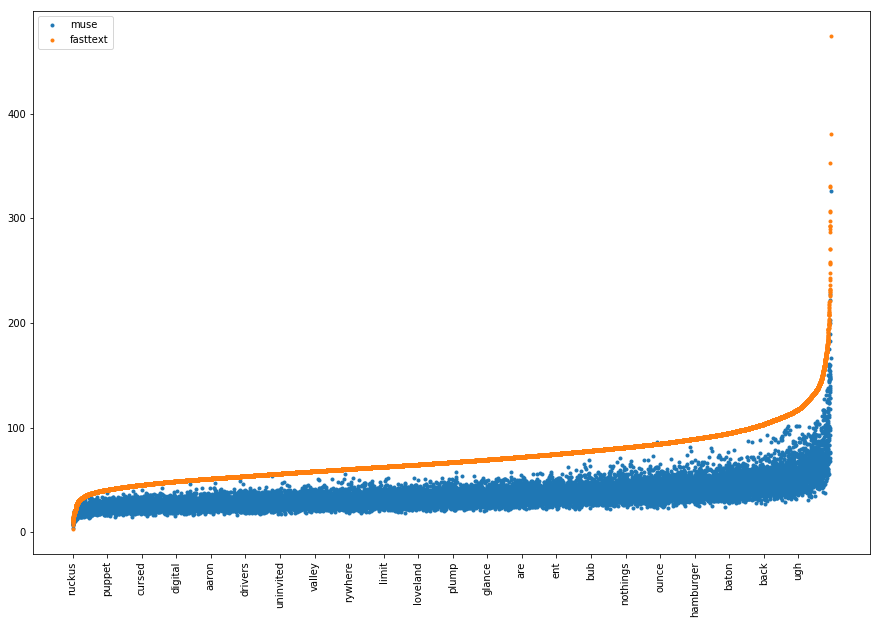

In [66]:
fig = plt.figure(figsize = (15, 10))

x = range(len(ordered_common_words))
plt.scatter(x, ordered_muse_dist, label = "muse", marker = '.')
plt.scatter(x, ordered_fasttext_dist, label = "fasttext", marker = '.')
plt.xticks(np.arange(min(x), max(x)+1, 1000),ordered_common_words[::1000], rotation='vertical')
plt.legend()
plt.show()

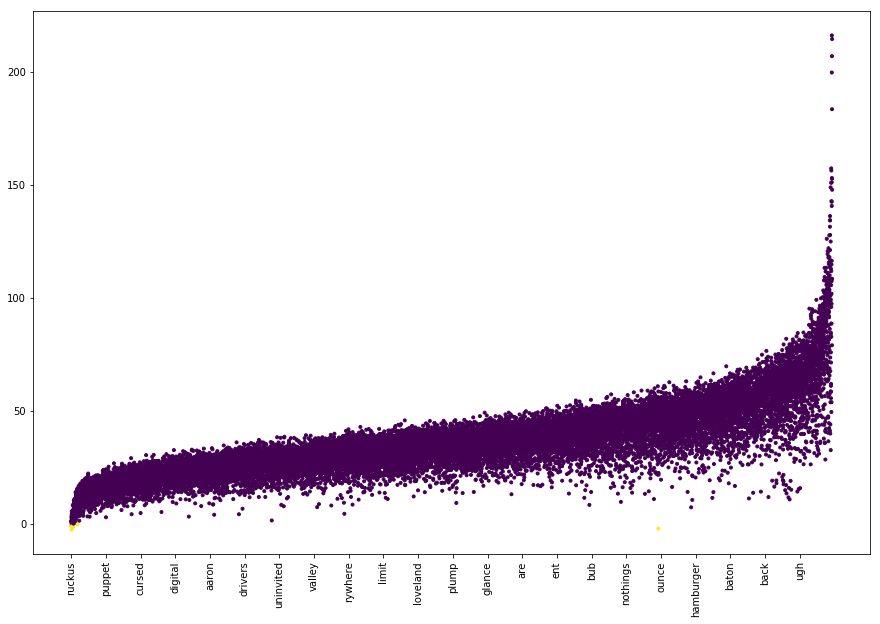

In [67]:
fig = plt.figure(figsize = (15, 10))
dist_diff = ordered_fasttext_dist - ordered_muse_dist
cmap = [ x < 0 for x in dist_diff]
x = range(len(ordered_common_words))

plt.scatter(x, dist_diff, label = "Difference", marker = '.', c = cmap)
plt.xticks(np.arange(min(x), max(x)+1, 1000),ordered_common_words[::1000], rotation='vertical')
#plt.hlines(0, 0 , len(ordered_common_words))
plt.show()

Gaussian ( 35.95998969320345 , 15.855410874435677 )


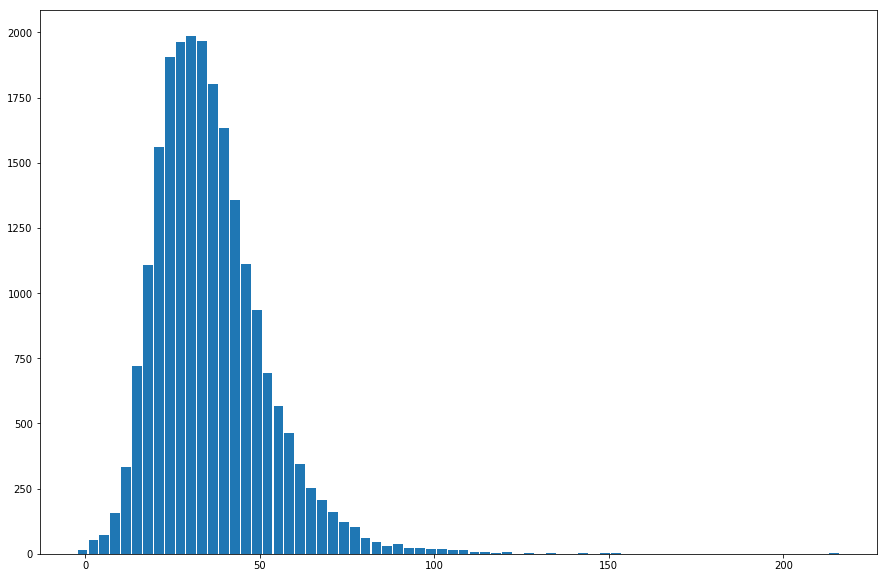

In [68]:
from scipy.stats import norm
import matplotlib.mlab as mlab
# best fit of data
(mu, sigma) = norm.fit(dist_diff)
print("Gaussian (",mu,",", sigma,")")
fig = plt.figure(figsize = (15, 10))
plt.hist(dist_diff, bins=70, rwidth = 0.9)

plt.show()

#### Analysis for distance
- Epoch 100, Refinement 100 : dump = yupm57o3j5, mean_cosine = 0.61315, Gaussian ( 10.9516391597 , 7.31625830261 )
- Epoch 500, Refinement 500 : mean_cosine = 0.76403, dump=slonhca75b, Gaussian ( 35.9599896932 , 15.8554108744 )

## Project

In [75]:
"""words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]

WORDS_TO_SWAP = ordered_terms[:10]

WORDS_TO_SWAP"""

array(['left', 'formed', 'understand', 'things', 'things', 'smile',
       'knowing', 'pick', 'somebody', 'somebody'], dtype='<U10')

In [76]:
from sklearn.neighbors import NearestNeighbors

In [77]:
neigh_pop = NearestNeighbors(n_neighbors=3)
neigh_pop.fit(muse_emb_pop)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [78]:
neigh_rock = NearestNeighbors(n_neighbors=3)
neigh_rock.fit(muse_emb_rock)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [85]:
import pickle

In [86]:
rock_specific = pickle.load( open("rock_specific.p", "rb"))

In [70]:
import random

In [125]:
rand_idx = random.randint(1,len(corpus_rock))
input_lyrics = corpus_rock[rand_idx]
input_lyrics

'on sleepless nights down in the laundrymat watching the clothes ghosts playing tit for tat we light a joint talk about our old friends dead or alive our stories never end turn it over look on the back page there s johnny gogo looks like he ll never age sits in the park house drinking beer and landing flies just after noon waiting for the trouble boys chorus that s just the way it is here no less and no more severe that s just the way it is here so pull up your socks and lean on your peers did you hear about hank booze rotted out his liver gray and depressed he gave his wife the finger what about his kid what about his exwife ask themselves the same thing when they turn out the lights i still remember the first time i saw him sing 2 black eyes from a knuckle and a biker s ring climbing up the speakers hanging from the balla rafters hamilton punk king swinging to his own disaster chorus pattie couldn t make it she jumped right out the window 3 floors down  cause they cut off her cable d

In [126]:
words_spec_rock = []
for w in input_lyrics.split(' '):
    if w in rock_specific:
        words_spec_rock.append(w)
words_spec_rock

['rotted']

In [127]:
words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

In [128]:
ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]
ordered_terms

array(['exwife', 'pattie', 'laundrymat', 'description', 'balla',
       'rafters', 'heartfelt', 'liver', 'peers', 'jumped', 'rotted',
       'depressed', 'speakers', 'noon', 'sits', 'hank', 'tit', 'tim',
       'hamilton', 'knuckle', 'floors', 'station', 'gogo', 'wing', 'dan',
       'stories', 'sidewalk', 'x2', 'booze', 'playing', 'clothes', 'gray',
       'cause', 'just', 'just', 'just', 'just', 'ball', 'chicken',
       'severe', 'joint', 'flies', 'page', 'lights', 'cable', 'kid',
       'landed', 'street', 'looked', 'socks', 'wife', 'disaster',
       'nights', 'took', 'hear', 'hear', 'story', 'watching', 'park',
       'gas', 'ghosts', 'ask', 'gave', 'looks', 'fiction', 'saw', 'age',
       'ring', 'eyes', 'tat', 'biker', 'climbing', 'pull', 'thing',
       'drinking', 'hanging', 'hanging', 'told', 'couldn', 'cut',
       'window', 'swinging', 'way', 'way', 'lean', 'night', 'fall',
       'chorus', 'chorus', 'chorus', 'friends', 'boys', 'house',
       'remember', 'light', 'make',

In [129]:
SWAP_ROCK = list(set(words_spec_rock))
SWAP_TFIDF = []
i = 0
while len(SWAP_ROCK) + len(SWAP_TFIDF) < 10:
    if ordered_terms[i] not in SWAP_ROCK and ordered_terms[i] not in SWAP_TFIDF:
        SWAP_TFIDF.append(ordered_terms[i])
    i += 1

In [130]:
SWAP_ROCK

['rotted']

In [131]:
SWAP_TFIDF

['exwife',
 'pattie',
 'laundrymat',
 'description',
 'balla',
 'rafters',
 'heartfelt',
 'liver',
 'peers']

In [112]:
def get_nearest_embed(emd, genre):
    if genre == 'pop':
        idx = neigh_pop.kneighbors([emb],return_distance=False)
        return muse_emb_pop[idx][0]
    elif genre == 'rock':
        idx = neigh_rock.kneighbors([emb],return_distance=False)
        return muse_emb_rock[idx][0]

In [113]:
def get_swap_word(w, nb_neighbor, genre):
    emb = muse_voc2embed_rock[w]
    nearest_pop_emb = get_nearest_embed(emb, genre)
    words = []
    for i in range(3):
        words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
    return words[nb_neighbor], words

In [114]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


In [132]:
swap = {}
for w in SWAP_ROCK:
    new_word, neighbor_words = get_swap_word(w, 0, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

print('-----')
for w in SWAP_TFIDF:
    new_word, neighbor_words = get_swap_word(w, 1, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

rotted -->  ['somesomebody', 'somebodys', 'sombody']
-----
exwife -->  ['somesomebody', 'somebodys', 'sombody']


KeyError: 'pattie'

In [116]:
#Print new lyrics
words = input_lyrics.split(' ')
for i, w in enumerate(words):
    if w in swap.keys():
        words[i] = color.BOLD + swap[w] + color.END

print(' '.join(words))

i want the kinda credit i just shine it and forget it the somesomebody they all know my name i want the kinda car where my stereo is better the damn things not falling apart i want the kinda hair i can look at and admire not a goofy little ball of flesh i want the kinda life that i can t leave behind i ll be a little ray of sunshine but ohwho cares gimme a beer i want the kinda girl she can dance she can twirl going out at night with her friends i want the kinda dog that listens when i call and somesomebody on my neighbors fence i want the kinda clothes so everybody knows here comes a confident man i want the kinda smile that radiates for miles man i cause a trafic jam but ohwho cares gimme a beer gimme a beer gimme a beer i want the kinda watch so everyone will talk and say hey his is better than mine i want the kinda chains golden and somesomebody don t look man you might go blind i want the kinda feline like a tiger or a lion and listen to my baby purr i want the kina house i ll sit

In [80]:
swap = {}
for w in WORDS_TO_SWAP:
    #Read original embedding
    """idx = vocabulary_rock.index(w)
    emb = word_embeddings_rock[idx]
    print(w, emb)"""
    #Read mapped embedding
    emb = muse_voc2embed_rock[w]
    nearest_pop_emb = get_nearest_embed(emb, 'pop')
    words = []
    for i in range(3):
        words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
    swap[w] = words
    print(w,' --> ',swap[w])

left  -->  ['left', 'cleft', 'leftover']
formed  -->  ['formed', 'recycled', 'entitled']
understand  -->  ['understand', 'misunderstand', 'understandable']
things  -->  ['things', 'somethings', 'everythings']
things  -->  ['things', 'somethings', 'everythings']
smile  -->  ['smile', 'smiley', 'smirk']
knowing  -->  ['knowing', 'doubting', 'compromising']
pick  -->  ['pick', 'pickney', 'pickup']
somebody  -->  ['somesomebody', 'somebodys', 'sombody']
somebody  -->  ['somesomebody', 'somebodys', 'sombody']


In [81]:
#Print new lyrics
"""words = input_lyrics.split(' ')
for i, w in enumerate(words):
    if w in WORDS_TO_SWAP:
        words[i] = swap[w]

words"""

['i',
 'can',
 't',
 'be',
 'myself',
 'when',
 'i',
 'm',
 'alone',
 'i',
 'think',
 'stupid',
 ['things', 'somethings', 'everythings'],
 'when',
 ['left', 'cleft', 'leftover'],
 'on',
 'my',
 'own',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'to',
 'be',
 'around',
 'someone',
 'to',
 'play',
 'up',
 'to',
 'to',
 'fool',
 'about',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'to',
 ['pick', 'pickney', 'pickup'],
 'me',
 'up',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'oh',
 'anybody',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'you',
 'know',
 'that',
 'it',
 's',
 'you',
 'i',
 'think',
 'out',
 'loud',
 'when',
 'there',
 's',
 'noone',
 'around',
 'i',
 'can',
 't',
 ['understand', 'misunderstand', 'understandable'],
 'why',
 'i',
 'ever',
 'get',
 'down',
 'i',
 'need',
 ['somesomebody', 'somebodys', 'sombody'],
 'to',
 'take',
 'me',
 'home',
 'to',
 'the',
 'world',
 'i',
 'once',
 'knew',
 'was',
 ['formed', 'recy

### Partial MUSE

## Goal of notebook 
- Create word model for pop and rock
- Compute embeddings for words in pop and rock
- Apply MUSE matching

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

In [2]:
filepath = "lyrics_final_clean.csv"
lyrics_df = pd.read_csv(filepath)
lyrics_df = lyrics_df.dropna(axis = 0, how='any', subset=['lyrics'])
lyrics_df.head()

,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,oh baby how you doing\nyou know i m gonna cut ...,ego-remix,2009.0
1,beyonce-knowles,pop,playin everything so easy\nit s like you seem...,then-tell-me,2009.0
2,beyonce-knowles,pop,if you search\nfor tenderness\nit isn t hard t...,honesty,2009.0
3,beyonce-knowles,pop,oh oh oh i oh oh oh i\n\nif i wrote a book abo...,you-are-my-rock,2009.0
4,beyonce-knowles,pop,party the people the people the party it s pop...,black-culture,2009.0


In [3]:
import sys
import codecs

In [4]:
# Load embeddings
def load_embeddings(file_name):
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

In [5]:
word_embeddings_pop, vocabulary_pop = load_embeddings('cbow_model_lyrics_pop.vec')

In [6]:
word_embeddings_rock, vocabulary_rock = load_embeddings('cbow_model_lyrics_rock.vec')

In [7]:
voc_pop = list(vocabulary_pop)
voc_rock = list(vocabulary_rock)

In [8]:
len(voc_rock)

33988

In [9]:
print(len(voc_pop))

29542


In [10]:
common_words = set(voc_pop).intersection(set(voc_rock))
print(len(common_words))
common_words = list(common_words)

21950


In [13]:
pop_specific = set(voc_pop).difference(set(common_words))
rock_specific = list(set(voc_rock).difference(set(common_words)))

In [14]:
print(len(pop_specific))
print(len(rock_specific))

7592
12038


In [15]:
#Percentage of common words 
print(len(common_words)/len(voc_pop))
print(len(common_words)/len(voc_rock))

0.7430099519328414
0.6458161704130869


In [14]:
import copy
def get_partial_vocabularies(perc):
    nb_to_remove = int(np.round((1-perc)*len(common_words)))
    print("Number of common words removed : ", nb_to_remove)
    selected_common_words = random.sample(common_words, nb_to_remove)
    selected_pop_voc = list(copy.deepcopy(vocabulary_pop))
    selected_rock_voc = list(copy.deepcopy(vocabulary_rock))
    selected_pop_embed = list(copy.deepcopy(word_embeddings_pop))
    selected_rock_embed = list(copy.deepcopy(word_embeddings_rock))
    for w in selected_common_words:
        idx_pop = vocabulary_pop.index(w)
        idx_rock = vocabulary_rock.index(w)
        selected_pop_voc[idx_pop] = 'NaN'
        selected_pop_embed[idx_pop] = 'NaN'
        selected_rock_voc[idx_rock] = 'NaN'
        selected_rock_embed[idx_rock] = 'NaN'
    
    selected_pop_voc = list(filter(lambda x: x != 'NaN', selected_pop_voc))
    selected_pop_embed = list(filter(lambda x: x != 'NaN', selected_pop_embed))
    selected_rock_voc = list(filter(lambda x: x != 'NaN', selected_rock_voc))
    selected_rock_embed = list(filter(lambda x: x != 'NaN', selected_rock_embed))
    """print(len(word_embeddings_pop))
    print(len(selected_pop_embed)+ nb_to_remove)
    print(len(word_embeddings_rock))
    print(len(selected_rock_embed)+ nb_to_remove)"""
    #print(len(selected_pop_voc) == len(selected_pop_embed))
    
    return selected_pop_voc, selected_pop_embed, selected_rock_voc, selected_rock_embed

In [15]:
pop_voc_75, pop_embed_75, rock_voc_75, rock_embed_75 = get_partial_vocabularies(0.75)

Number of common words removed :  5488


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [174]:
pop_voc_50, pop_embed_50, rock_voc_50, rock_embed_50 = get_partial_vocabularies(0.5)

Number of common words removed :  10975


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [175]:
pop_voc_25, pop_embed_25, rock_voc_25, rock_embed_25 = get_partial_vocabularies(0.25)

Number of common words removed :  16462


/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
/Users/emma/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:21: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


In [189]:
print(round(pop_embed_75[0][0], 7))

2.5513


In [193]:
str_ = ''
for x in pop_embed_75[0]:
    str_ = str_ + str(round(x,7)) +' '
    
str_

'2.5513 -0.67314 -2.6041 -0.65499 2.5479 1.1821 0.94551 1.9132 -0.03946 1.3754 0.34791 1.3157 -0.76442 1.7082 0.5161 -0.81964 1.1613 -0.18665 -0.94979 -0.41297 -1.5338 0.19622 -0.2695 -1.263 1.0004 -0.24717 1.9912 -0.52688 0.4605 0.27812 -0.20491 -1.0826 -0.30503 0.58974 -2.053 0.20593 0.84472 0.25543 -1.0134 1.3927 -1.0817 0.63854 0.26633 4.2355 0.73335 -0.57185 1.0761 0.84098 -1.0181 2.7724 0.99602 0.99885 -1.8186 -1.3611 1.4948 0.26265 -0.33812 0.33232 -1.3647 0.51959 0.80607 0.19404 -0.049289 1.025 -0.78717 1.1622 -0.45162 -1.0891 -1.4351 0.42565 -0.087215 1.8192 1.2125 1.224 0.78866 -1.3284 -0.64849 -1.6629 0.87404 -0.1511 0.70841 -3.5287 0.11822 -1.3758 0.0026896 -1.2074 0.53309 1.9728 1.0147 0.71674 -1.1662 0.67856 -0.15674 0.36633 0.42427 -0.0045239 -0.011005 -0.91143 -2.1724 0.52828 '

In [198]:
def create_vec_file(file_name, voc, embed):
    with codecs.open(file_name, 'w', 'utf-8') as f:
        f.write(str(len(voc))+' 100\n')
        for i,w in enumerate(voc):
            l = w + ' '
            for x in embed[i]:
                l = l + str(round(x,7)) + ' '
            l = l + '\n'
            f.write(l)

In [199]:
create_vec_file('cbow_model_lyrics_pop_75.vec', pop_voc_75, pop_embed_75)

In [200]:
create_vec_file('cbow_model_lyrics_rock_75.vec', rock_voc_75, rock_embed_75)

In [254]:
create_vec_file('cbow_model_lyrics_pop_50.vec', pop_voc_50, pop_embed_50)
create_vec_file('cbow_model_lyrics_pop_25.vec', pop_voc_25, pop_embed_25)
create_vec_file('cbow_model_lyrics_rock_50.vec', rock_voc_50, rock_embed_50)
create_vec_file('cbow_model_lyrics_rock_25.vec', rock_voc_25, rock_embed_25)

## TF-IDF
Source : https://www.kaggle.com/adamschroeder/countvectorizer-tfidfvectorizer-predict-comments

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [17]:
corpus_pop = list(lyrics_df[lyrics_df['genre'] == 'pop']['lyrics'])
corpus_pop = [x.replace('\n', ' ') for x in corpus_pop]

In [18]:
corpus_rock = list(lyrics_df[lyrics_df['genre'] == 'rock']['lyrics'])
corpus_rock = [x.replace('\n', ' ') for x in corpus_rock]

In [19]:
def get_tfidf(corpus, max_freq, min_freq):
    tf = TfidfVectorizer(stop_words='english', max_df=max_freq, min_df=min_freq)
    X = tf.fit(corpus)
    X_transformed = X.transform(corpus)
    # find maximum value for each of the features over all of dataset:
    max_val = X_transformed.max(axis=0).toarray().ravel()

    feature_names = np.array(tf.get_feature_names())
    sorted_by_idf = np.argsort(tf.idf_)

    #sort weights from smallest to biggest and extract their indices 
    sort_by_tfidf = max_val.argsort()
    return feature_names[sort_by_tfidf]

In [20]:
tfidf_pop = get_tfidf(corpus_pop, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_pop[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_pop[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['youven' 'gakka' 'kkeuteopneun' 'sorijilleobwa' 'wabwa' 'jeulgyeobwa'
 'urimodu' 'isunganeun' '2pm' 'jjaritan']

Features with highest tfidf: 
['turn' 'understanding' 'stingray' 'lyrics' 'dark' 'hey' 'intrumental'
 'embed' 'coming' 'silhouette']


In [21]:
tfidf_rock = get_tfidf(corpus_rock, 1.0, 0.0)
print("Features with lowest tfidf:\n{}".format(tfidf_rock[:10]))

print("\nFeatures with highest tfidf: \n{}".format(tfidf_rock[-10:]))

/Users/emma/anaconda3/lib/python3.5/site-packages/sklearn/feature_extraction/text.py:1089: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if hasattr(X, 'dtype') and np.issubdtype(X.dtype, np.float):


Features with lowest tfidf:
['aalley' 'heighho' 'greivin' 'yeshot' 'yayara' 'saftey' 'chinchara'
 'acelandine' 'hivoltage' 'spik']

Features with highest tfidf: 
['nazareth' 'paid' 'aumgn' 'say' 'special' 'awolnation' 'fm' 'paranoid'
 'raining' 'want']


## MUSE
- Supervised: using a train bilingual dictionary (or identical character strings as anchor points), learn a mapping from the source to the target space using (iterative) Procrustes alignment.
- Unsupervised: without any parallel data or anchor point, learn a mapping from the source to the target space using adversarial training and (iterative) Procrustes refinement.

In [61]:
N_EPOCH = 50
BATCH_SIZE = 32
N_ITERATION = round(len(voc_rock)/BATCH_SIZE)
REFINEMENT = 50
CHOSEN_EMBEDDING = 'cbow_'#'skipgram_'
CHOSEN_PERC = str(75)
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec' #'cbow_model_lyrics_rock_' + CHOSEN_PERC +'.vec'
MODEL_POP =  'cbow_model_lyrics_pop_' + CHOSEN_PERC +'.vec' #CHOSEN_EMBEDDING +'model_lyrics_pop.vec'
SRC_LANG = CHOSEN_EMBEDDING +'rock_' + CHOSEN_PERC
TGT_LANG = CHOSEN_EMBEDDING +'pop_' + CHOSEN_PERC

In [99]:
def analyse_run(data):
    data = ' '.join(data)
    dump = data.split('exp_path: /Users/emma/Cours/Sem_3/Lyrix/MUSE/MUSE-master/dumped/debug/')[1].split(' ')[0]
    substring = data.split('* Best value for "mean_cosine-csls_knn_10-S2T-10000": ')[-1]
    iteration = substring.split('End of ')[1].split('. ')[0]
    best_mean_cosine = substring.split(' INFO')[0]
    print("For dump ", dump, " the best mean cosine was ", best_mean_cosine, " reached at ", iteration)

In [115]:
data = ! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  wnckibdcl1  the best mean cosine was  0.61150  reached at  refinement iteration 49


In [101]:
CHOSEN_PERC = str(50)
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec' 
MODEL_POP =  'cbow_model_lyrics_pop_' + CHOSEN_PERC +'.vec' 
SRC_LANG = CHOSEN_EMBEDDING +'rock_' + CHOSEN_PERC
TGT_LANG = CHOSEN_EMBEDDING +'pop_' + CHOSEN_PERC
data = ! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  7r6qvrluj7  the best mean cosine was  0.60310  reached at  refinement iteration 49


In [100]:
CHOSEN_PERC = str(25)
MODEL_ROCK = CHOSEN_EMBEDDING + 'model_lyrics_rock.vec' 
MODEL_POP =  'cbow_model_lyrics_pop_' + CHOSEN_PERC +'.vec' 
SRC_LANG = CHOSEN_EMBEDDING +'rock_' + CHOSEN_PERC
TGT_LANG = CHOSEN_EMBEDDING +'pop_' + CHOSEN_PERC
data = ! python MUSE-master/unsupervised.py --src_lang $SRC_LANG --tgt_lang $TGT_LANG --src_emb $MODEL_ROCK --tgt_emb $MODEL_POP --n_epochs $N_EPOCH --epoch_size $N_ITERATION --batch_size $BATCH_SIZE --n_refinement $REFINEMENT
analyse_run(data)

For dump  ey4p6vloxi  the best mean cosine was  0.61772  reached at  refinement iteration 49


#### Note performance : 
Use CBOW
- 75% : 
    - Epoch 50, Refinement 50 : For dump  ylwj8ubtdw  the best mean cosine was  0.61142  reached at  refinement iteration 43

- 50% : 
    - Epoch 50, Refinement 50 : For dump  d8jnijiuxu  the best mean cosine was  0.62547  reached at  refinement iteration 49
    
- 25% :
    - Epoch 50, Refinement 50 : For dump  j9tzccphji  the best mean cosine was  0.63224  reached at  refinement iteration 49

Alternative : Partial Rock, Full Pop
- 75% : 
    - Epoch 50, Refinement 50 : For dump  858vfrdtoz  the best mean cosine was  0.62030  reached at  refinement iteration 49

- 50% : 
    - Epoch 50, Refinement 50 : For dump  3pui0lkb3b  the best mean cosine was  0.62266  reached at  refinement iteration 44
    
- 25% :
    - Epoch 50, Refinement 50 : For dump  co8l8h7b4g  the best mean cosine was  0.64415  reached at  refinement iteration 48
    
Not correct, needs to be the otherway round : Full Rock and partial pop:
- 75% : 
    - Epoch 50, Refinement 50 : For dump  wnckibdcl1  the best mean cosine was  0.61150  reached at  refinement iteration 49
    - Epoch 50, Refinement 50 : For dump  zf6o2u6vhb  the best mean cosine was  0.61022  reached at  refinement iteration 44
    - Epoch 50, Refinement 50 : For dump  aw0a6ud2ts  the best mean cosine was  0.61131  reached at  refinement iteration 49
- 50% : 
    - Epoch 50, Refinement 50 : For dump pky4gwq3eg the best mean cosine was 0.60795 reached at refinement iteration 48
- 25% : 
    - Epoch 50, Refinement 50 : For dump  ey4p6vloxi  the best mean cosine was  0.61772  reached at  refinement iteration 49

## Project

In [111]:
import pickle

In [112]:
pickle.dump(rock_specific ,open( "rock_specific.p", "wb" ))

In [88]:
rand_idx = random.randint(1,len(corpus_rock))
input_lyrics = corpus_rock[rand_idx]
input_lyrics

'turn sweet as salt we burn with lightning fury in sudden squall we drift in solitary lines i ll follow you through walls of sleepless currents the way that towers over us betrays tomorrow tell me again tell me again how it turns out after the sun and the stars stop burning after the wars will the world keep revolving after the storms will we come out shining like rubies like rubies i ll stay with you until the story s over till winter blooms into summer and we drown in wordless beauty tell me again tell me again how it goes down hold me again hold me again pull me closer'

In [89]:
words_spec_rock = []
for w in input_lyrics.split(' '):
    if w in rock_specific:
        words_spec_rock.append(w)
words_spec_rock

['squall', 'wordless']

In [113]:
pickle.dump(tfidf_rock,open("tfidf_rock.p", "wb"))

In [90]:
words_in_tfidf = []
idx_of_tfidf = []
for w in input_lyrics.split(' '):
    idx = np.where(tfidf_rock==w)[0]
    if len(idx)!= 0:
        words_in_tfidf.append(w)
        idx_of_tfidf.append(idx[0])

In [91]:
ordered_terms = np.array(words_in_tfidf)[np.argsort(idx_of_tfidf)]

In [92]:
ordered_terms

array(['wordless', 'towers', 'rubies', 'rubies', 'storms', 'squall',
       'revolving', 'betrays', 'drift', 'currents', 'lines', 'solitary',
       'blooms', 'winter', 'salt', 'fury', 'lightning', 'stars', 'wars',
       'story', 'shining', 'sweet', 'walls', 'tomorrow', 'summer', 'pull',
       'sun', 'sudden', 'way', 'drown', 'till', 'beauty', 'come', 'stay',
       'burning', 'sleepless', 'world', 'turns', 'stop', 'll', 'll',
       'tell', 'tell', 'tell', 'tell', 'turn', 'closer', 'goes', 'like',
       'like', 'follow', 'burn', 'hold', 'hold'], dtype='<U9')

In [93]:
SWAP_ROCK = list(set(words_spec_rock))
SWAP_TFIDF = []
i = 0
while len(SWAP_ROCK) + len(SWAP_TFIDF) < 10:
    if ordered_terms[i] not in SWAP_ROCK and ordered_terms[i] not in SWAP_TFIDF:
        SWAP_TFIDF.append(ordered_terms[i])
    i += 1

In [94]:
SWAP_ROCK

['squall', 'wordless']

In [95]:
SWAP_TFIDF

['towers',
 'rubies',
 'storms',
 'revolving',
 'betrays',
 'drift',
 'currents',
 'lines']

In [74]:
muse_emb_rock = "vectors-" + CHOSEN_EMBEDDING + "rock_" + CHOSEN_PERC+ ".txt"
muse_emb_pop = "vectors-" + CHOSEN_EMBEDDING + "pop_" + CHOSEN_PERC +".txt"

In [76]:
muse_emb_rock, muse_voc_rock = load_embeddings(muse_emb_rock)

In [77]:
muse_emb_pop, muse_voc_pop = load_embeddings(muse_emb_pop)

In [49]:
def get_dict(embed, voc):
    voc_embeds_dict = {}
    embeds_voc_dict = {}

    for v, emb in zip(voc, embed):
        voc_embeds_dict[v] = tuple(emb)
        embeds_voc_dict[tuple(emb)] = v
    return voc_embeds_dict, embeds_voc_dict

In [78]:
word_embeddings_pop, vocabulary_pop = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_pop_'+ CHOSEN_PERC+ '.vec')
word_embeddings_rock, vocabulary_rock = load_embeddings(CHOSEN_EMBEDDING + 'model_lyrics_rock_'+ CHOSEN_PERC+ '.vec')

In [79]:
voc2embed_rock, embed2voc_rock = get_dict(word_embeddings_rock, vocabulary_rock)
voc2embed_pop, embed2voc_pop = get_dict(word_embeddings_pop, vocabulary_pop)

In [77]:
def see_movement(w):
    print("Movement in rock : ")
    print(sum(abs(np.array(muse_voc2embed_rock[w]) - voc2embed_rock[w])))
    print("Distance in fastext between 2 words : ")
    print(sum(abs(np.array(voc2embed_rock[w])- voc2embed_pop[w])))
    print("Distance in muse between 2 words : ")
    print(sum(abs(np.array(muse_voc2embed_rock[w])- muse_voc2embed_pop[w])))

In [80]:
muse_voc2embed_rock, muse_embed2voc_rock = get_dict(muse_emb_rock, muse_voc_rock) 
muse_voc2embed_pop, muse_embed2voc_pop = get_dict(muse_emb_pop, muse_voc_pop) 

In [ ]:
see_movement('you')

In [54]:
from sklearn.neighbors import NearestNeighbors

In [81]:
neigh_pop = NearestNeighbors(n_neighbors=3)
neigh_pop.fit(muse_emb_pop)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [82]:
neigh_rock = NearestNeighbors(n_neighbors=3)
neigh_rock.fit(muse_emb_rock)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=1, n_neighbors=3, p=2, radius=1.0)

In [57]:
def get_nearest_embed(emb, genre):
    if genre == 'pop':
        idx = neigh_pop.kneighbors([emb],return_distance=False)
        return muse_emb_pop[idx][0]
    elif genre == 'rock':
        idx = neigh_rock.kneighbors([emb],return_distance=False)
        return muse_emb_rock[idx][0]

In [70]:
def get_swap_word(w, nb_neighbor, genre):
    emb = muse_voc2embed_rock[w]
    nearest_pop_emb = get_nearest_embed(emb, genre)
    words = []
    for i in range(3):
        words.append(muse_embed2voc_pop[tuple(list(nearest_pop_emb[i]))])
    return words[nb_neighbor], words

In [71]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

print(color.BOLD + 'Hello World !' + color.END)

Hello World !


In [96]:
swap = {}
for w in SWAP_ROCK:
    new_word, neighbor_words = get_swap_word(w, 0, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

print('-----')
for w in SWAP_TFIDF:
    new_word, neighbor_words = get_swap_word(w, 1, 'pop')
    print(w, '--> ', neighbor_words)
    swap[w] = new_word

squall -->  ['syncopate', 'funktafied', 'foxtrot']
wordless -->  ['sympathizing', 'selfdeceiving', 'insincerity']
-----
towers -->  ['feathered', 'tethered', 'watercolored']
rubies -->  ['orchids', 'dvds', 'soaps']
storms -->  ['tethered', 'enlightened', 'burdened']
revolving -->  ['nursing', 'insulting', 'erupting']
betrays -->  ['furthermore', 'sympathizing', 'sojourn']
drift -->  ['explored', 'unfazed', 'enclose']
currents -->  ['disgruntled', 'fossils', 'caverns']
lines -->  ['grownups', 'grownup', 'worshiped']


In [97]:
#Print new lyrics
words = input_lyrics.split(' ')
for i, w in enumerate(words):
    if w in swap.keys():
        words[i] = color.BOLD + swap[w] + color.END

print(' '.join(words))

turn sweet as salt we burn with lightning fury in sudden syncopate we unfazed in solitary grownup i ll follow you through walls of sleepless fossils the way that tethered over us sympathizing tomorrow tell me again tell me again how it turns out after the sun and the stars stop burning after the wars will the world keep insulting after the enlightened will we come out shining like dvds like dvds i ll stay with you until the story s over till winter blooms into summer and we drown in sympathizing beauty tell me again tell me again how it goes down hold me again hold me again pull me closer


[Go to top](#top)

<a id="nn"></a>

## Neural Network

In this part we build the neural network allowing us to do some words predictions on the lyrics and transform them from one genre to another. First we will visualize the amount of lyrics that we have for each genre:

In [2]:
lyrics_df = pd.read_csv('../kaggleDataset/lyrics_final_clean.csv')
MAIN_GENRES = {'pop', 'rock', 'metal', 'country', 'jazz', 'hip hop'}
# For now just work on pop and rock genres
print(len(lyrics_df))
lyrics_df.head(10)

317015


,artist,genre,lyrics,song,year
0,beyonce-knowles,pop,oh baby how you doing\nyou know i m gonna cut ...,ego-remix,2009.0
1,beyonce-knowles,pop,playin everything so easy\nit s like you seem...,then-tell-me,2009.0
2,beyonce-knowles,pop,if you search\nfor tenderness\nit isn t hard t...,honesty,2009.0
3,beyonce-knowles,pop,oh oh oh i oh oh oh i\n\nif i wrote a book abo...,you-are-my-rock,2009.0
4,beyonce-knowles,pop,party the people the people the party it s pop...,black-culture,2009.0
5,beyonce-knowles,pop,i heard\nchurch bells ringing\ni heard\na choi...,all-i-could-do-was-cry,2009.0
6,beyonce-knowles,pop,this is just another day that i would spend\nw...,once-in-a-lifetime,2009.0
7,beyonce-knowles,pop,waiting waiting waiting waiting\nwaiting waiti...,waiting,2009.0
8,beyonce-knowles,pop,\ni read all of the magazines\nwhile waiting a...,slow-love,2009.0
9,beyonce-knowles,pop,nnnow honey\nyou better sit down and look arou...,why-don-t-you-love-me,2009.0


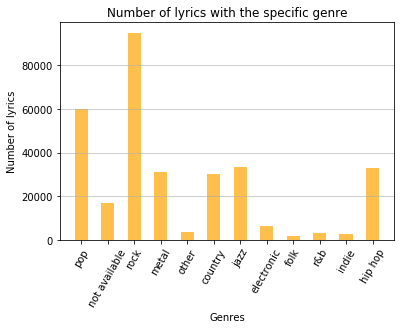

In [5]:
n, bins, patches = plt.hist(x = list(lyrics_df["genre"]), bins=np.arange(0,len(set(lyrics_df["genre"])) + 1), color='orange', align = 'left', alpha=0.7, rwidth=0.5)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Genres')
plt.ylabel('Number of lyrics')
plt.title('Number of lyrics with the specific genre')
plt.xticks(rotation=60)
plt.show()

We will only focus on genres with sufficient number of lyrics: rock, pop, metal, jazz, country, hip hop. For each of these genres we have more than 30'000 lyrics in our dataset

## Input pre-processing

Import the dictionnaries of word embeddings computed previously with fasttext:

In [6]:
# Load embeddings
file_vec = 'fasttext_preprocessing/model_lyrics_skipgram.vec'
file_bin = 'fasttext_preprocessing/model_lyrics_skipgram.bin' # Not useful and file too big for Github
fasttext_exe = 'fasttext_preprocessing/fasttext'

def load_embeddings(file_name):
    """
    Load the embeddings from the .vec file given as input
    """
    with codecs.open(file_name, 'r', 'utf-8') as f_in:
        lines = f_in.readlines()
        lines = lines[1:]
        vocabulary, wv = zip(*[line.strip().split(' ', 1) for line in lines])
    wv = np.loadtxt(wv)
    return wv, vocabulary

# This method is typically called for words with no embeddings in the dictionary
def get_embedding_for_missing_word(w):
    """
    Given a word as input, computes it's fasttext vector using the file_bin file
    """
    data = ! echo $w | $fasttext_exe print-word-vectors $file_bin
    emb = np.zeros(100)
    for i, x in enumerate(data[0].split( )[1:]):
        try:
            emb[i] = float(x)
        except ValueError:
            print(data[0])
    return emb

word_embeddings, vocabulary = load_embeddings(file_vec)

In [7]:
# Create dictionaries
voc_embeds_dict = {}
embeds_voc_dict = {}

for voc, embed in zip(vocabulary, word_embeddings):
    voc_embeds_dict[voc] = tuple(embed)
    embeds_voc_dict[tuple(embed)] = voc
    
print(len(voc_embeds_dict))

85899


Search for all the words in the lyrics that are not in the embeddings.

In [424]:
# THIS CELL TAKES LONG TIME TO RUN: NO NEED TO RUN WITH missing_words.csv file
def find_missing_words(lyrics, vocab):
    """
    Given lyrics of songs, find the words in it that are not in the vocabulary (word embeddings)
    """
    sentences = str(lyrics).replace('\n', ' ')
    list_words = sentences.split(' ')
    missing_words = set(list_words).difference(vocab)
    return missing_words


vocab = set(voc_embeds_dict.keys())
missing_vocab = set()

for i, row in lyrics_df.iterrows():
    if i % 1000 == 999:
        print(float(i)/ len(lyrics_df))
    lyrics = row['lyrics']
    missing_words = find_missing_words(lyrics, vocab)
    
    missing_vocab = missing_vocab.union(missing_words)
    vocab = vocab.union(missing_words)

0.0031512704446161853
0.0063056953141018566
0.009460120183587528
0.012614545053073198
0.01576896992255887
0.01892339479204454
0.02207781966153021
0.02523224453101588
0.028386669400501552
0.031541094269987226
0.03469551913947289
0.037849944008958566
0.04100436887844424
0.04415879374792991
0.04731321861741558
0.05046764348690125
0.05362206835638692
0.056776493225872596
0.05993091809535826
0.06308534296484393
0.06623976783432961
0.06939419270381528
0.07254861757330094
0.07570304244278662
0.07885746731227229
0.08201189218175796
0.08516631705124363
0.0883207419207293
0.09147516679021497
0.09462959165970064
0.09778401652918632
0.10093844139867199
0.10409286626815765
0.10724729113764334
0.110401716007129
0.11355614087661467
0.11671056574610034
0.11986499061558602
0.12301941548507168
0.12617384035455737
0.12932826522404303
0.1324826900935287
0.13563711496301437
0.13879153983250003
0.1419459647019857
0.1451003895714714
0.14825481444095706
0.15140923931044273
0.1545636641799284
0.157718089049414

In [425]:
# Remove duplicates
missing_vocab_lst = list(set(missing_vocab_lst))
print(len(missing_vocab_lst))
print(missing_vocab_lst[:50])

229149
['', 'keopeulling', 'faithmy', 'abraim', 'lutenant', 'drup', 'pinehill', 'dubar', 'proovalizing', 'mour', 'amortization', 'macmahon', 'wohohohoh', 'dribs', '146', 'vechouski', 'stevies', 'speciments', 'dauphine', 'machangajingeol', 'eastends', 'misquete', 'leatherfeathered', 'ayyet', 'melodytrouble', 'lamarque', 'fashionkilla', 'heemed', 'ghuana', 'yanamean', 'clannad', 'strategized', 'blaoww', 'chicagoo', 'arthgolano', 'brk', 'trickier', 'macgregors', 'mimimimind', 'giddedygot', 'asseth', 'willliehaeyyy', 'polako', 'mahuckin', 'telltales', 'dahomey', 'honeypie', 'virany', 'twentymillion', 'berlington']


In [8]:
missing_words_file = 'fasttext_preprocessing/missing_words.csv'
# Save missing words
"""with open(missing_words_file, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    for val in missing_vocab_lst:
        writer.writerow([val])"""
        
# Read missing words
with open(missing_words_file, 'r') as f:
    reader = csv.reader(f)
    missing_vocab_lst = [ls_word[0] for ls_word in list(reader)]
print("{} distinct missing words".format(len(missing_vocab_lst)))

229149 distinct missing words


The idea was to fetch the embeddings of all these missing words using the get_embedding_for_missing_word function. However, this took way too long to compute for all the missing words.

Most of the missing words are actual words with a bad ortograph: lots of them contain a same letter repeating lots of time (e.g. Wwwwwworld instead of world). Thus we use regex to map these words to their actual correct representation:

In [9]:
vocab = set(voc_embeds_dict.keys())
bad_good_word_dict = {}
for i, w in enumerate(missing_vocab_lst):
    correct_w = re.sub(r'(.)\1{2,}', r'\1', w)
    if correct_w in vocab:
        bad_good_word_dict[w] = correct_w
print("Number of correct mapped words: {}".format(len(bad_good_word_dict)))

Number of correct mapped words: 5568


Now let's transform the lyrics as follows. For each word:

    - If the word is in the voc_embeds_dict dictionary, keep the word (he has an embedding)
    - Else if the word is in the bad_good_word_dict, fetch the corresponding good word (missing word with a matching)
    - Else remove the word from the lyrics (we don't have his emnedding and it's too long to compute it for each word)

Transform lyrics by keeping only the words that have fasttext embeddings

In [10]:
def lyrics_to_list_words(lyrics, vocab):
    """
    Given lyrics of songs, keep only the words with the embeddings
    """
    sentences = str(lyrics).replace('\n', ' ') # Don't consider end of words
    list_words = sentences.split(' ')
    list_words_cleaned = []
    incorrect_count = 0
    
    for w in list_words:
        if w in voc_embeds_dict.keys():
            list_words_cleaned.append(w)
        elif w in bad_good_word_dict.keys():
            # Get matching word
            correct_w = bad_good_word_dict[w]
            list_words_cleaned.append(correct_w)
        else: 
            # Word with no embedding, don't consider it
            incorrect_count += 1 
    return list_words_cleaned, incorrect_count

In [11]:
def get_list_words_from_df(df, vocab):
    """
    Given a dataframe, apply the lyrics_to_list_words on each lyrics of the dataframe
    """
    lyrics_cleaned = []
    total_incorrect = 0

    for i, row in df.iterrows():    
        lyrics = row['lyrics']
        words_cleaned, c = lyrics_to_list_words(str(lyrics), vocab)
        total_incorrect += c
        lyrics_cleaned.append(words_cleaned)
    print("Average of incorrect words per song: {}".format(float(total_incorrect) / len(df)))
    return lyrics_cleaned

def list_lyrics_genre(entire_df, entire_vocab, genre):
    """
    Get the list of lyrics with "non-missing" words (list of words) for a given genre
    """
    df_genre = entire_df[entire_df['genre'] == genre]
    print("Number lyrics for genre {} : {}".format(genre, len(df_genre)))
    list_lyrs_genre = get_list_words_from_df(df_genre, entire_vocab)
    return list_lyrs_genre

In [12]:
vocab = set(voc_embeds_dict.keys())
list_lyrics = get_list_words_from_df(lyrics_df, vocab)

Average of incorrect words per song: 8.113108212545148


In [14]:
list_lyrs_pop = list_lyrics_genre(lyrics_df, vocab, 'pop')
list_lyrs_rock = list_lyrics_genre(lyrics_df, vocab, 'rock')
list_lyrs_metal = list_lyrics_genre(lyrics_df, vocab, 'metal')
list_lyrs_jazz = list_lyrics_genre(lyrics_df, vocab, 'jazz')
list_lyrs_hiphop = list_lyrics_genre(lyrics_df, vocab, 'hip hop')
list_lyrs_country = list_lyrics_genre(lyrics_df, vocab, 'country')

Number lyrics for genre pop : 59850
Average of incorrect words per song: 9.592147034252298
Number lyrics for genre rock : 94938
Average of incorrect words per song: 3.3855147569993047
Number lyrics for genre metal : 31320
Average of incorrect words per song: 6.085983397190294
Number lyrics for genre jazz : 33536
Average of incorrect words per song: 9.372286498091603
Number lyrics for genre hip hop : 33024
Average of incorrect words per song: 23.560804263565892
Number lyrics for genre country : 30247
Average of incorrect words per song: 7.217244685423347


Depending on the genre we have more or less words with missing embedding but this number isn't huge except for hip hop lyrics (23.5 missing words per song in average). We figured out that it is ok to remove these words from the lyrics !

Check lengths of lyrics repartitions and we keep only the lyrics with more than 30 words, otherwise lyrics might be outliers.

In [15]:
def get_lyrics_above(list_lyrics, min_nbr_words = 30):
    lengths_lyrics = [len(l) for l in list_lyrics]
    print("Words per lyrics: Min: {}, Max: {}, Avg: {}".format(min(lengths_lyrics), max(lengths_lyrics), np.mean(lengths_lyrics)))

    # Keep lyrics with more than certain number of words
    list_lyrics_nomin = [l for l in list_lyrics if len(l) > min_nbr_words]
    lengths_lyrics = [len(l) for l in list_lyrics_nomin]
    print("Ratio lyrics kept: {}".format(len(list_lyrics_nomin) / len(list_lyrics)))
    return list_lyrics_nomin, lengths_lyrics

In [16]:
list_lyrs_pop, lengths_pop = get_lyrics_above(list_lyrs_pop)
list_lyrs_rock, lengths_rock = get_lyrics_above(list_lyrs_rock)
list_lyrs_metal, lengths_metal = get_lyrics_above(list_lyrs_metal)
list_lyrs_jazz, lengths_jazz = get_lyrics_above(list_lyrs_jazz)
list_lyrs_hiphop, lengths_hiphop = get_lyrics_above(list_lyrs_hiphop)
list_lyrs_country, lengths_country = get_lyrics_above(list_lyrs_country)

Words per lyrics: Min: 0, Max: 3365, Avg: 247.924544695071
Ratio lyrics kept: 0.9945196324143692
Words per lyrics: Min: 0, Max: 6300, Avg: 202.37651941266932
Ratio lyrics kept: 0.9892982788767406
Words per lyrics: Min: 0, Max: 2377, Avg: 188.33288633461046
Ratio lyrics kept: 0.9791507024265645
Words per lyrics: Min: 0, Max: 2380, Avg: 183.74349952290078
Ratio lyrics kept: 0.9926645992366412
Words per lyrics: Min: 1, Max: 8179, Avg: 503.35425750968994
Ratio lyrics kept: 0.9904009205426356
Words per lyrics: Min: 0, Max: 2736, Avg: 199.3980890666843
Ratio lyrics kept: 0.9972889873375872


### Exclusive words for each genre

For this part we decided, for each genre, to compute the words appearing exclusively in this genre and not in the other ones. We also ensured that these found words are real words by comparing them with a dictionary of the english language (list words from nltk library).

The idea behind this: 
Because the vocabulary of words is huge, we would like to sample some words for each genre such that these words will be the possible words that our neural network will predict. In order to predict good words for a specific genre, we thought about considering these "exclusive" words as possible outputs for our neural network for the specific genre (and add other words). However, we remarked that these exclusive words might not appear a lot of time and this would reduce the whole size of the training set for our neural net. Moreover, we remarked that these unique words are "weird" words because they don't appear at all in all the other lyrics of the other genres. We decided not to use these words and found a better and smarter alternative that will be explained after.    

In [17]:
def unique_words(list_lyrs):
    """
    Given list of lyrics (list of words), return the set of all words
    """
    all_words = []
    for l in list_lyrs:
        for w in l:
            all_words.append(w)
    unique_words = set(all_words)
    print("Number of unique words: {}".format(len(unique_words)))
    return unique_words 

In [18]:
# Distinct words
words_pop = unique_words(list_lyrs_pop)
words_rock = unique_words(list_lyrs_rock)
words_metal = unique_words(list_lyrs_metal)
words_jazz = unique_words(list_lyrs_jazz)
words_hiphop = unique_words(list_lyrs_hiphop)
words_country = unique_words(list_lyrs_country)

# Common words in all genres
common_words = words_metal.intersection(words_rock).intersection(words_pop).intersection(words_jazz).intersection(words_hiphop).intersection(words_country)
print(len(common_words))

Number of unique words: 57083
Number of unique words: 59368
Number of unique words: 44487
Number of unique words: 41731
Number of unique words: 61796
Number of unique words: 35441
20373


In [19]:
from nltk.corpus import words
# If needed to download package word, uncomment 2 nex lines
#import nltk
#nltk.download('words')

exclusive_metal = words_metal.difference(words_rock.union(words_pop).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_pop = words_pop.difference(words_rock.union(words_metal).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_rock = words_rock.difference(words_metal.union(words_pop).union(words_jazz).union(words_hiphop).union(words_country))
exclusive_jazz = words_jazz.difference(words_rock.union(words_pop).union(words_metal).union(words_hiphop).union(words_country))
exclusive_hiphop = words_hiphop.difference(words_rock.union(words_pop).union(words_jazz).union(words_metal).union(words_country))
exclusive_country = words_country.difference(words_rock.union(words_pop).union(words_jazz).union(words_hiphop).union(words_metal))

# Keep only real existing words given by the nltk library
exclusive_metal = set(words.words()).intersection(exclusive_metal)
exclusive_pop = set(words.words()).intersection(exclusive_pop)
exclusive_rock = set(words.words()).intersection(exclusive_rock)
exclusive_jazz = set(words.words()).intersection(exclusive_jazz)
exclusive_hiphop = set(words.words()).intersection(exclusive_hiphop)
exclusive_country = set(words.words()).intersection(exclusive_country)

### Part Of Speech (POS) for each genre:

For each genre we go through the lyrics of this genre and compute the POS distribution of the genre, the count of apparitions of each words, the POS of each words. For the POS of each word, sometimes a word can have multiple POS: (e.g. increase can either be a NOUN or VERB), so we consider the final POS that appears the most for each word. 

In [20]:
# Spacy library to compute the Parts Of Speeches (POS) in a sentence
en_nlp = spacy.load('en')

Possible POS:

ADJ: adjective ADP: adposition ADV: adverb AUX: auxiliary verb CONJ: coordinating conjunction DET: determiner INTJ: interjection NOUN: noun NUM: numeral PART: particle PRON: pronoun PROPN: proper noun PUNCT: punctuation SCONJ: subordinating conjunction SYM: symbol VERB: verb X: other

In [21]:
def generate_pos_for_lyrics(lyrs):
    """
    Compute the Part Of Speech (POS) of each word for given lyrics and return the list of POS and counter for these lyrics
    """
    doc = en_nlp(lyrs)
    word_pos_dict = {}
    list_pos = []
    
    for i in range(len(doc)):
        type_ = doc[i].pos_
        if type_ != 'SPACE' and type_ != 'PART' and type_ != 'X': # We don't want to keep these POS
            list_pos.append(type_)
            if str(doc[i]) not in word_pos_dict.keys():
                word_pos_dict[str(doc[i])] = {type_: 1}
            elif type_ not in word_pos_dict[str(doc[i])].keys():
                word_pos_dict[str(doc[i])][type_] = 1
            else:
                word_pos_dict[str(doc[i])][type_] += 1
    # list_pos: the list of POS appearing in the lyrics
    # Counter(list_pos): counter of each distinct POS apparition in the lyrics
    # word_pos_dict: dictionary of format: {word1: {pos1: count, pos2: count, ....}, word2: {pos1: count, pos2: count, ....}, ...}
    return list_pos, Counter(list_pos), word_pos_dict

def update_word_pos_dict(w_pos_dict1, w_pos_dict2):
    """
    Function that updates the w_pos_dictionary by adding the key or / and values from w_pos_dict2
    """
    # parameters -> {word1: {pos1: count, pos2: count, ....}, word2: {pos1: count, pos2: count, ....}, ...}
    
    res = w_pos_dict1.copy()
    for w, pos_dict2 in w_pos_dict2.items():
        if w not in res.keys():
            # Add the pos, counts dictionary for w in the main dictionary
            res[w] = pos_dict2
        else:
            # Combine the 2 POS, counts dictionaries for word w
            pos_dict1 = res[w].copy()
            for pos, count in pos_dict2.items():
                if pos in pos_dict1.keys():
                    # Increment the count
                    pos_dict1[pos] += count
                else:
                    # Add the new POS and count
                    pos_dict1[pos] = count
            res[w] = pos_dict1
    return res

def get_pos_count_from_df(list_lyrics):
    """
    Given the whole list of lyrics, compute the number of POS in all lyrics(pos_counter), 
    the apparition of each word in all the lyrics (word_counter), and the corresponding POS for each of this word (final_word_pos_dict)
    """
    print("Number of lyrics: {}".format(len(list_lyrics)))
    pos_counter = Counter()
    word_counter = Counter()
    total_word_pos_dict = {}
    
    for i, list_words in enumerate(list_lyrics):
        if i % 1000 == 999:
            print(float(i) / len(list_lyrics))
        
        # We don't consider the first word as we are not able to predict it from the previous words
        _, counter, word_pos_dict = generate_pos_for_lyrics(' '.join(list_words[1:])) 
        pos_counter += counter
        word_counter += Counter(list_words)
        total_word_pos_dict = update_word_pos_dict(total_word_pos_dict, word_pos_dict)
    
    final_word_pos_dict = {}
    for w, pos_dict in total_word_pos_dict.items():
        max_pos = max(pos_dict, key = pos_dict.get)
        final_word_pos_dict[w] = max_pos
        
    return pos_counter, word_counter, final_word_pos_dict

In [1210]:
"""Takes some times to compute, we saved all the data in files"""
#pop_pos_counter, pop_word_counter, pop_word_pos_dict = get_pos_count_from_df(list_lyrs_pop)
#met_pos_counter, met_word_counter, met_word_pos_dict = get_pos_count_from_df(list_lyrs_metal)
#jazz_pos_counter, jazz_word_counter, jazz_word_pos_dict = get_pos_count_from_df(list_lyrs_jazz)
#country_pos_counter, country_word_counter, country_word_pos_dict = get_pos_count_from_df(list_lyrs_country)
#hip_pos_counter, hip_word_counter, hip_word_pos_dict = get_pos_count_from_df(list_lyrs_hiphop)
#rock_pos_counter, rock_word_counter, rock_word_pos_dict = get_pos_count_from_df(list_lyrs_rock)

Number of lyrics: 93922
0.01063648559442942
0.021283618321585998
0.03193075104874257
0.04257788377589915
0.05322501650305573
0.06387214923021231
0.07451928195736889
0.08516641468452546
0.09581354741168203
0.10646068013883861
0.11710781286599518
0.12775494559315176
0.13840207832030835
0.1490492110474649
0.1596963437746215
0.17034347650177808
0.18099060922893465
0.19163774195609123
0.2022848746832478
0.21293200741040438
0.22357914013756094
0.23422627286471753
0.24487340559187412
0.2555205383190307
0.26616767104618727
0.27681480377334383
0.2874619365005004
0.298109069227657
0.30875620195481357
0.31940333468197013
0.33005046740912675
0.3406976001362833
0.35134473286343987
0.36199186559059643
0.37263899831775305
0.3832861310449096
0.39393326377206617
0.4045803964992228
0.41522752922637934
0.4258746619535359
0.43652179468069247
0.4471689274078491
0.45781606013500564
0.4684631928621622
0.4791103255893188
0.4897574583164754
0.500404591043632
0.5110517237707886
0.5216988564979451
0.532345989225

In [22]:
# Cell to save and / or load the 3 dictionaries of a specific genre

def dict_to_csv(path, dict_):
    with open(path, "w") as f:
        writer = csv.writer(f)
        for key, value in dict_.items():
            writer.writerow([key, value])
        
def csv_to_dict(path):
    with open(path, "r") as f:
        reader = csv.reader(f)
        dict_ = dict(reader)
    return dict_

def get_files_from_genre(genre):
    pos_file = 'NN_models/' + genre + '/' + genre + '_pos_counter.csv'
    word_file = 'NN_models/' + genre + '/' + genre + '_word_counter.csv'
    word_pos_file = 'NN_models/' + genre + '/' + genre + '_word_pos.csv'
    
    # Read csv files to create dictionaries
    pos_counter_dict = csv_to_dict(pos_file)
    word_counter_dict = csv_to_dict(word_file)
    word_pos_dict = csv_to_dict(word_pos_file)
    
    # We are not interested in all POS: PUNCT or SYM not important
    pos_to_keep = {'INTJ','NOUN','ADV','PRON','VERB','ADP','DET','CCONJ','ADJ','NUM','PROPN'} 
    pos_counter_dict = {k:v for k,v in pos_counter_dict.items() if k in pos_to_keep}
    word_pos_dict = {k:v for k,v in word_pos_dict.items() if v in pos_to_keep}
    
    return pos_counter_dict, word_counter_dict, word_pos_dict

# Save dictionaries to csv files:
"""genre = 'rock'
pos_file = 'NN_models/' + genre + '/' + genre + '_pos_counter.csv'
word_file = 'NN_models/' + genre + '/' + genre + '_word_counter.csv'
word_pos_file = 'NN_models/' + genre + '/' + genre + '_word_pos.csv'
    
dict_to_csv(pos_file, rock_pos_counter)
dict_to_csv(word_file, rock_word_counter)
dict_to_csv(word_pos_file, rock_word_pos_dict)"""

# Read csv files to create dictionaries
pop_pos_counter, pop_word_counter, pop_word_pos_dict = get_files_from_genre('pop')
rock_pos_counter, rock_word_counter, rock_word_pos_dict = get_files_from_genre('rock')
metal_pos_counter, metal_word_counter, metal_word_pos_dict = get_files_from_genre('metal')
jazz_pos_counter, jazz_word_counter, jazz_word_pos_dict = get_files_from_genre('jazz')
hip_pos_counter, hip_word_counter, hip_word_pos_dict = get_files_from_genre('hiphop')
country_pos_counter, country_word_counter, country_word_pos_dict = get_files_from_genre('country')

In [23]:
def get_distrib_pos(pos_counter_dict):
    """
    Computes the distribution of POS given the dictionary POS -> count for a given genre
    """
    total = np.sum([int(elem) for elem in pos_counter_dict.values()])
    distrib_dict = {}
    
    for key, value in pos_counter_dict.items():
        distrib_dict[key] = float(value) / total
    return distrib_dict

pop_pos_distrib = get_distrib_pos(pop_pos_counter)
rock_pos_distrib = get_distrib_pos(rock_pos_counter)
metal_pos_distrib = get_distrib_pos(metal_pos_counter)
country_pos_distrib = get_distrib_pos(country_pos_counter)
jazz_pos_distrib = get_distrib_pos(jazz_pos_counter)
hip_pos_distrib = get_distrib_pos(hip_pos_counter)

print("Pop Distribution:")
print(pop_pos_distrib)

Pop Distribution:
{'NOUN': 0.19276193171973033, 'ADV': 0.08198539710305533, 'PRON': 0.15895478063838622, 'VERB': 0.2643048408229971, 'ADP': 0.08763619154411462, 'DET': 0.07565409071450818, 'CCONJ': 0.029392494146212735, 'ADJ': 0.08588414598757374, 'INTJ': 0.017080696046527663, 'NUM': 0.005104399007677646, 'PROPN': 0.0012410322692164562}


From the previous dictionaries, we create a new one with POS type as key and lists of tuples (word with this POS, count of the words) as values. The list is sorted in decreasing order of count. 

#### From now on, we do all the computations uniquely on the Pop genre to avoid code redundancy, but it works the exact same way with other genres and we did it with all other genres to compute the specific neural network of each genre.  

In [25]:
pos_list = list(pop_pos_counter.keys())

def get_pos_words_dict(pos_list, word_count_dict, word_pos_dict):

    pos_words_dict = {pos:[] for pos in pos_list}
    
    # Add tuples (words, count) to the dictionary
    for w, count in word_count_dict.items():
        if w in word_pos_dict.keys(): # Don't consider words with no POS (typically the ones from the list no_pos_words)
            pos = word_pos_dict[w]
            pos_words_dict[pos].append((w, int(count)))
        
    # Sort each value lists on the count (x[1]) parameter from most to least appearing word 
    for pos in pos_words_dict.keys():
        pos_words_dict[pos].sort(key = lambda x: x[1], reverse = True)
        
    return pos_words_dict

pop_pos_words_dict = get_pos_words_dict(pos_list, pop_word_counter, pop_word_pos_dict)


### Most common words for each genre :

We previously saw that using exclusive words wasn't such a great idea. In this section we found a better alternative that consists in using the count of words of one genre (i.e. pop genre) and compute the difference of counts between each word of this genre and the same word in the other genres:

$$\Delta Pop_{w1} = count Pop_{w1} - (count Rock_{w1} + count Metal_{w1} + count Jazz_{w1} + count Country_{w1} + count Hip hop_{w1})$$

We then sort the list by decreasing difference such that the first words are the most common to the pop genre.

In [26]:
def get_diff_words_counts(genre_word_count_dict, others_word_count_dicts, genre, threshold = 100):
    """
    From the first dictionary, compute the difference between count of words in this dict with count of all other dicts.
    """
    # Keep only words appearing at least a certain amount of times
    diff_dict = {k:int(v) for k, v in genre_word_count_dict.items() if int(v) > threshold}
    for w in diff_dict.keys():
        for other_dict in others_word_count_dicts:
            if w in other_dict.keys():
                count = int(other_dict[w])
                diff_dict[w] -= count
    
    # return a sorted list
    diff_list = [(k,v) for k,v in diff_dict.items()]
    diff_list.sort(key = lambda x: x[1], reverse = True)
    
    # THIS PART IS HARDCODED BY OBSERVING MOST APPEARING WORDS FOR EACH GENRE
    if genre == 'pop':
        # Most appearing words in this genre are french or spanish -> take words below 0
        diff_list =  [(k,v) for k,v in diff_list if v < 0]
    if genre == 'rock':
        # Most appearing words are nonsense -> take words below 80
        diff_list =  [(k,v) for (k,v) in diff_list if v < 80]
        
    # metal, jazz, country -> all good; hip hop -> seems good but dirty :O
    return diff_list


threshold = 200
other_dicts = np.array([rock_word_counter, pop_word_counter, metal_word_counter, jazz_word_counter, country_word_counter, hip_word_counter])

rock_diff_list = get_diff_words_counts(rock_word_counter, other_dicts[1:], 'rock', threshold)
pop_diff_list = get_diff_words_counts(pop_word_counter, other_dicts[[0,2,3,4,5]], 'pop', threshold)
metal_diff_list = get_diff_words_counts(metal_word_counter, other_dicts[[0,1,3,4,5]], 'metal', threshold)
jazz_diff_list = get_diff_words_counts(jazz_word_counter, other_dicts[[0,1,2,4,5]], 'jazz', threshold)
country_diff_list = get_diff_words_counts(country_word_counter, other_dicts[[0,1,2,3,5]], 'country', threshold)
hip_diff_list = get_diff_words_counts(hip_word_counter, other_dicts[:5], 'hiphop', threshold)

In [27]:
nbr_words = 10
print("Rock exclusive {} most appearing words : {}\n".format(nbr_words, rock_diff_list[:nbr_words]))
print("Pop exclusive {} most appearing words : {}\n".format(nbr_words, pop_diff_list[:nbr_words]))
print("Metal exclusive {} most appearing words : {}\n".format(nbr_words, metal_diff_list[:nbr_words]))
print("Jazz exclusive {} most appearing words : {}\n".format(nbr_words, jazz_diff_list[:nbr_words]))
print("Country exclusive {} most appearing words : {}\n".format(nbr_words, country_diff_list[:nbr_words]))
print("Hip Hop exclusive {} most appearing words : {}\n".format(nbr_words, hip_diff_list[:nbr_words]))

Rock exclusive 10 most appearing words : [('bored', 63), ('jaded', 43), ('brilliant', 15), ('headlines', 3), ('chemicals', -6), ('rocker', -19), ('saves', -26), ('isolation', -28), ('crashing', -30), ('failing', -31)]

Pop exclusive 10 most appearing words : [('ee', -6), ('ohohoh', -14), ('mickey', -21), ('como', -24), ('du', -27), ('vie', -29), ('ne', -35), ('bom', -39), ('es', -49), ('por', -58)]

Metal exclusive 10 most appearing words : [('eternal', 326), ('damnation', 248), ('ov', 217), ('morbid', 204), ('infernal', 204), ('legions', 179), ('corpses', 171), ('torment', 168), ('stench', 163), ('realm', 160)]

Jazz exclusive 10 most appearing words : [('liza', 118), ('hep', 98), ('accustomed', 77), ('darn', 0), ('doggone', -65), ('marvelous', -88), ('tricky', -91), ('lordy', -98), ('wail', -134), ('willow', -201)]

Country exclusive 10 most appearing words : [('honky', 284), ('tonk', 213), ('mem', 212), ('mhm', 161), ('cowboy', 139), ('hank', 134), ('ries', 102), ('nashville', 88), 

### Sample words for a specific genre:

The sampling is done based on:
    - n: the approximate number of words we want to sample
    - exclusive_words: the list of most common words appearing only in the wanted genre
    - pos_words_dict: the dictionary of POS -> list of words, count (sorted) qualified as this POS
    - pos_distrib: the dictionary of POS -> float between 0 and 1 being the distribution of POS we want to approximate with the sampling
    - word_pos_dict: the dictionary of word -> POS of this word
    - word_counter: the dictionary of word -> count of this word in vocabulary of genre
    - threshold: the minimum number of count we accept to consider a word for the sampling

In [28]:
def get_sample(n, exclusive_words, pos_words_dict, pos_distrib, word_pos_dict, word_counter, threshold = 5):
    """
    Given a target n (wanted number of words), get the sample of words to keep for output of the neural net 
    """
    # Keep exclusive words above threshold
    # List already sorted by count
    excl_words_tokeep = [w for w, count in exclusive_words if w in word_pos_dict.keys()]#w in exclusive_words if w in word_counter.keys() and int(word_counter[w]) >= threshold]
    
    # Check distribution of the pos of these exclusive words
    pos_words_sample_dict = {k:[] for k in pos_distrib.keys()}
    pos_actual_distrib = {k:0.0 for k in pos_distrib.keys()}
    
    # We just add a ratio of "exclusive words" in order to also add most common words in all genres to generate correct lyrics in the end
    ratio_exclusive_words = 0.5
    
    for w in excl_words_tokeep:
        pos = word_pos_dict[w]
        distrib = pos_actual_distrib[pos] 
        if distrib < pos_distrib[pos] * ratio_exclusive_words:
            # if we did not reach the max distribution: add it to the dictionary
            pos_actual_distrib[pos] += 1.0/n
            pos_words_sample_dict[pos].append(w)
    
    # Add regular words to complete the wanted distribution from pos_distribution
    most_common_idx = 20
    for pos, max_distrib in pos_distrib.items():
        actual_distrib = pos_actual_distrib[pos]
        lst_words = pos_words_dict[pos]
        exclusive_words = pos_words_sample_dict[pos]
        
        # Get most common words with given POS and add them such that they do not exceed wanted distribution 
        most_common_words = [(w,c) for w, c in lst_words[:most_common_idx] if c >= threshold and w not in exclusive_words]
        
        if len(lst_words) > most_common_idx:
            # Sample from lst_words (keep words not added before and with a count above threshold)
            lst_words = [(w,c) for w, c in lst_words[most_common_idx:] if c >= threshold and w not in exclusive_words]
            
            # Sample randomly some of the words in lst_words
            max_idx = min(int(n / 3), len(lst_words))
            to_sample = min(int(np.floor(max_distrib * n)), max_idx)
            #print(pos, to_sample, len(lst_words))
            if to_sample > 0:
                # Sample words with counts above threshold and not in lst_words
                most_common_words += random.sample(lst_words[:max_idx], to_sample)
            
        for w, count in most_common_words:
            # Add them if distribution not exceeded
            
            if actual_distrib < max_distrib + 0.001:
                actual_distrib += 1.0/n
                pos_words_sample_dict[pos].append(w)
        
        pos_actual_distrib[pos] = actual_distrib 
    return pos_words_sample_dict, pos_actual_distrib  

In [29]:
pop_sample_dict, pop_sample_distrib = get_sample(1500, pop_diff_list, pop_pos_words_dict, pop_pos_distrib, pop_word_pos_dict, pop_word_counter, threshold)

nbr_out = sum([len(lst) for k, lst in pop_sample_dict.items()])

print("Number of words sampled: {}\n".format(nbr_out))
print("Lyrics POS distribution: {}\n".format(pop_pos_distrib))
print("Sample POS distribution: {}\n".format(pop_sample_distrib))

print("Nouns from pop sampled: ")
print(pop_sample_dict['NOUN'])

Number of words sampled: 1122

Lyrics POS distribution: {'NOUN': 0.19276193171973033, 'ADV': 0.08198539710305533, 'PRON': 0.15895478063838622, 'VERB': 0.2643048408229971, 'ADP': 0.08763619154411462, 'DET': 0.07565409071450818, 'CCONJ': 0.029392494146212735, 'ADJ': 0.08588414598757374, 'INTJ': 0.017080696046527663, 'NUM': 0.005104399007677646, 'PROPN': 0.0012410322692164562}

Sample POS distribution: {'NOUN': 0.19400000000000076, 'ADV': 0.08333333333333333, 'PRON': 0.01733333333333333, 'VERB': 0.2653333333333345, 'ADP': 0.05666666666666676, 'DET': 0.010666666666666666, 'CCONJ': 0.005333333333333334, 'ADJ': 0.0873333333333333, 'INTJ': 0.01866666666666666, 'NUM': 0.006666666666666668, 'PROPN': 0.0026666666666666666}

Nouns from pop sampled: 
['ohohoh', 'mickey', 'como', 'vie', 'ne', 'bom', 'por', 'weezy', 'runway', 'tokyo', 'nana', 'que', 'butterflies', 'halo', 'mistletoe', 'si', 'ohoh', 'mmmm', 'emergency', 'betcha', 'deh', 'chi', 'wonderland', 'bonnie', 'tenderness', 'dame', 'presents',

We sampled pop words by trying to respect the same distribution of POS as in the actual pop lyrics. However, for some POS, the distribution is reduced (e.g. pronouns, deteminants). This is because there is not so many words such as pronouns or determinants that exist and by including all of these pronouns / determinants, the distribution can't increase.
This is not an issue as our neural network will learn to predict a word with the correct wanted POS that we want.

It could have been interesting to analyze the tradeoffs between the number of words that we want to sample and the threshold that we set. The higher the number of words to sample is, the higher the number of words to predict as outputs of the neural network, thus the accuracy of correct predictions might decrease. The higher the threshold, the more we get rid of outlier words but we might remove some specific words of the genre that we are interested in predict with our neural net.

We thought that 1500 was a good number of words to sample and 200 was a good threshold even though we can see that there are some outliers (i.e. spanish or french words) 

### Words Tokenization:

We map each distinct word to an integer and convert the list of lyrics to the corresponding list of indices 

In [30]:
# Keras imports
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Input, Embedding, LSTM, Dense, concatenate, BatchNormalization, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from scipy import sparse
import pickle
import random

Using TensorFlow backend.


In [ ]:
# Tokenize on all possible words with embeddings
tokenizer = Tokenizer(num_words = len(vocab))
tokenizer.fit_on_texts(list_lyrics)

print(len(tokenizer.word_index))

In [31]:
# Save tokenizers:
"""with open('NN_models/tokenizer', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

# Load tokenizer corresponding to indices of words for the neural nets
with open('NN_models/tokenizer', 'rb') as handle:
    tokenizer = pickle.load(handle)
    
# Get the tokenized sequences for the genre we want
sequences = tokenizer.texts_to_sequences(list_lyrs_pop) #list_lyrs_pop
print(len(tokenizer.word_index))

82664


In [32]:
pos_sample_dict = pop_sample_dict

def get_tokens_for_samples(word_token_dict, pos_sample_dict):
    """Function that creates the dictionary from sample words to their corresponding tokens"""
    sample_tokens = []
    sample_words = []
    for pos, lst_samples in pos_sample_dict.items():
        for w in lst_samples:
            sample_words.append(w)
            token = word_token_dict[w]
            sample_tokens.append(token)
    return dict(zip(sample_words, sample_tokens))

samples_word_tok_dict = get_tokens_for_samples(tokenizer.word_index, pos_sample_dict)
samples_tokens = set(samples_word_tok_dict.values())
print(len(samples_tokens))
print(samples_word_tok_dict)

1122
{'ohohoh': 4372, 'mickey': 4437, 'como': 5703, 'vie': 4958, 'ne': 3145, 'bom': 3924, 'por': 5094, 'weezy': 5124, 'runway': 5361, 'tokyo': 5392, 'nana': 4049, 'que': 1501, 'butterflies': 3947, 'halo': 3174, 'mistletoe': 4207, 'si': 2497, 'ohoh': 2829, 'mmmm': 4854, 'emergency': 4506, 'betcha': 4071, 'deh': 4358, 'chi': 4536, 'wonderland': 3431, 'bonnie': 4290, 'tenderness': 3612, 'dame': 4288, 'presents': 4198, 'weh': 4082, 'attraction': 4203, 'cupid': 4399, 'bluebird': 4533, 'maria': 3240, 'bam': 3307, 'zoom': 4304, 'crunk': 3928, 'raindrops': 3953, 'reindeer': 3817, 'venus': 4079, 'marie': 4155, 'fantasies': 3789, 'romeo': 3765, 'spotlight': 3822, 'film': 3968, 'nick': 4034, 'believer': 3339, 'ling': 4159, 'affection': 2674, 'superstar': 3336, 'diddy': 3934, 'karma': 3888, 'miracles': 3788, 'lipstick': 3295, 'boyfriend': 2405, 'rainbows': 3607, 'temperature': 3954, 'robin': 3863, 'dum': 2637, 'colours': 3401, 'fingertips': 3884, 'dynamite': 3896, 'misunderstood': 3874, 'con': 352

### Input of Neural Network: n-grams dataset

Fetch all possible n-grams of words for each lyrics. We keep ngrams if they end with one of the word in the samples (words we want to predict):
For instance, with n = 3 and lyrics "oh baby i love you", we would obtain: ["oh baby i", "baby i love", "i love you"]

In [33]:
def ngram_lyrics(n, lyrs, samples_tokens = None):
    """
    Compute ngrams for one given lyrics (padded), if samples tokens different of None, keep only the ngrams ending with tokens in samples_tokens
    """
    
    # Add first ngrams with some zeros
    ngram_lyrs = []
    for i in range(n):
        end_index = i + 2
        first_elems = lyrs[: end_index]
        last_elem = first_elems[-1]
        # Append to ngrams if last elem (element to predict) is in samples
        if len(first_elems) < n and last_elem in samples_tokens:
            ngram = (n - end_index)*[0]
            for elem in first_elems:
                ngram.append(elem)
            ngram_lyrs.append(ngram)
    
    # Add rest of ngrams with no zeros
    for i, _ in enumerate(lyrs[: -n + 1]):
        n_gram = lyrs[i : i + n] # take the element and next n - 1 ones
        #if np.sum(n_gram) != 0 and n_gram[-2] != 0: # Don't add ngrams if they are all zeros or if second last elem is 0
            #n_gram_lyrs.append(n_gram)
        last_elem = n_gram[-1]
        # Append to ngrams if last elem (element to predict) is in samples
        if last_elem in samples_tokens:
            ngram_lyrs.append(n_gram)
    
    return ngram_lyrs

def all_ngram_lyrics(n, all_lyrs, samples_tokens = None):
    """
    Compute all ngrams for the given lyrics (padded) and the list of lengths of words (for each song computed before padding) 
    """
    length_lyrics = [len(l) for l in all_lyrs]
    all_ngram_lyrics = np.zeros((np.sum(length_lyrics), n), dtype = int)
    idx = 0
    
    for i, lyr in enumerate(all_lyrs):
        if i % 5000 == 4999:
            print(float(i) / len(all_lyrs))
        ngram_lyr = ngram_lyrics(n, lyr, samples_tokens)
        if len(ngram_lyr) > 0:
            length = len(ngram_lyr)
            all_ngram_lyrics[idx: idx + length] = ngram_lyr
            idx += length
        else:
            print("No sample words in lyr at index {}".format(i))
        
    return all_ngram_lyrics[:idx] # After idx are only zeros

In [34]:
n = 6
ngram_sequences = all_ngram_lyrics(n, sequences, samples_tokens)
print("Amount of {}-grams sentences: {}".format(n, len(ngram_sequences)))

0.08398575316689627
0.16798830684452806
0.25199086052215985
0.3359934141997917
0.4199959678774235
0.5039985215550553
0.5880010752326871
0.6720036289103188
0.7560061825879507
0.8400087362655825
0.9240112899432142
Amount of 6-grams sentences: 11135634


Now that we have all the ngrams ending with one of the sample words, we will get, for each sample word, an equal numbers of ngrams ending with this sample. Because we already ensured that the sample words appeared at least a certain amount of time (defined by the threshold value = 200), we should get around 200 distinct ngrams for each sample words. If a sample word has more than 200 ngrams, we select 200 of all randomly. This ensures that we train our neural network equally on each possible outputs.

In [35]:
def equal_ngram_lyrics(all_ngrams, samples_tokens, threshold):
    """
    Function that computes all the ngrams that will be used for training, validation, testing of the neural network.
    We keep an equal number of ngrams ending with each sample tokens
    """
    token_count_dict = {t:0 for t in samples_tokens} 
    token_lstidx_dict = {t:[] for t in samples_tokens} # Store the list of indices (in ngrams) ending with this token
    for i, ngram in enumerate(all_ngrams):
        last_tok = ngram[-1]
        token_count_dict[last_tok] += 1
        token_lstidx_dict[last_tok].append(i)
    
    n = np.shape(all_ngrams)[1]
    min_count = min(token_count_dict.values())
    print("Minimum of count: {}, Threshold: {}".format(min_count, threshold))
    
    if min_count < threshold:
        # Shouldn't happen but weird behavior happening for some words, didn't find why :/
        token_to_remove = {t:c for t,c in token_count_dict.items() if c < threshold}
        words_to_remove = [tokenizer.index_word[t] for t in token_to_remove.keys()]
        print("Removing {} words from sample: {}".format(len(token_to_remove), words_to_remove))
        # Remove these words from the dictionaries:
        token_count_dict = {t:c for t,c in token_count_dict.items() if c >= threshold}
        token_lstidx_dict = {t:lst for t,lst in token_lstidx_dict.items() if t not in token_to_remove.keys()}
    
    min_count = min(token_count_dict.values())
    print("Getting the same amount of ngrams for each token in samples: minimum {}".format(min_count))
    
    equal_distrib_ngrams = np.zeros((min_count * len(token_count_dict.keys()), n), dtype = int)
    act_index = 0
    for token in token_count_dict.keys():
        lst_idx = token_lstidx_dict[token]
        # Get randomly some (min_count) of the ngrams ending with the token
        random_idx = random.sample(lst_idx, min_count) # Don't consider the ngrams with paddings ?
        some_ngrams = all_ngrams[random_idx]
        equal_distrib_ngrams[act_index : act_index + len(some_ngrams)] = some_ngrams
        act_index += len(some_ngrams) 
    return equal_distrib_ngrams, token_count_dict

In [36]:
equal_samples_ngrams, samples_count_dict = equal_ngram_lyrics(ngram_sequences, samples_tokens, threshold)

Minimum of count: 194, Threshold: 200
Removing 3 words from sample: ['bonnie', 'mmmm', 'shove']
Getting the same amount of ngrams for each token in samples: minimum 201


In [37]:
# Change sample_tokens such that we don't consider the removed words:
samples_tokens = set(samples_count_dict.keys())
print("Number of words in sample: {}".format(len(samples_tokens)))

Number of words in sample: 1119


In [38]:
print("Number of equal sampled ngrams: {}\n".format(len(equal_samples_ngrams)))
# Check if ngram done correctly
print(equal_samples_ngrams[:25])

Number of equal sampled ngrams: 224919

[[  589     8    12    10  1107     1]
 [ 8517   703    12     2    99     1]
 [  103    31    25     4   751     1]
 [   70   391    36   368    76     1]
 [  113   147   233  4645     5     1]
 [    6   243   243    48    76     1]
 [    1    58    40    26     3     1]
 [   65     3   136  4197     5     1]
 [  103     4   337     7    44     1]
 [   30    19     1    30    19     1]
 [   83    41    19     2   142     1]
 [   10   341    84  1240    48     1]
 [  194    25    48   154     3     1]
 [  132   607    22   132   607     1]
 [    1    38    22    15 14285     1]
 [80286     1    59    15   244     1]
 [   51     2 73976   490  3136     1]
 [   40    14   683   606    23     1]
 [  268   139    21     2  6170     1]
 [   40   127     7   170    39     1]
 [    2   201    13     2   192     1]
 [   57     9    63 18247    28     1]
 [   19   233   142    17   120     1]
 [    3   411     8    39    28     1]
 [    2   116   203    1

Create matrix of embeddings to use in the first layer of the neural net to map tokens (words) to their correct embeddings:

In [39]:
# Dictionary from index to word (and vice versa)
word_index_dict = tokenizer.word_index
index_word_dict = dict(map(reversed, word_index_dict.items()))
print('Found %s unique tokens.' % len(word_index_dict))

vocab_size = len(word_index_dict) # Only terms appearing in the specific genre
embed_size = 100
embedding_matrix = np.zeros((vocab_size + 1, embed_size)) # First row will stay at zeros for padding index: 0

for word, i in word_index_dict.items():
    embedding_vector = voc_embeds_dict[word]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 82664 unique tokens.


Split ngram sequences in training, validation and testing sets for the neural net

In [40]:
def split_train_test(ngram_sequences, test_ratio, samples_count_dict, min_count):
    test_per_word = max(1, int(test_ratio * min_count / 2))
    val_per_word = test_per_word
    print("Keep {} ngrams over {} per token for testing".format(test_per_word, min_count))
    
    tok_test_dict = {tok:0 for tok in samples_count_dict.keys()} #dictionary to keep track of elements to put in test
    tok_val_dict = {tok:0 for tok in samples_count_dict.keys()}
    
    train_indices = []
    test_indices = []
    val_indices = []
    random_range = list(range(len(ngram_sequences)))
    random.shuffle(random_range)
    
    for i in random_range:
        ngram = ngram_sequences[i]
        last_tok = ngram[-1]
        if tok_test_dict[last_tok] < test_per_word:
            # Use this ngram for test
            test_indices.append(i)
            tok_test_dict[last_tok] += 1
        elif tok_val_dict[last_tok] < val_per_word:
            # Use this ngram for validation
            val_indices.append(i)
            tok_val_dict[last_tok] += 1
        else:
            # Use this ngram for training
            train_indices.append(i)
    
    train = ngram_sequences[train_indices]
    test = ngram_sequences[test_indices]
    val = ngram_sequences[val_indices]
    
    #train, test = train_test_split(ngram_sequences, test_size = test_ratio, shuffle = False)
    X_train, Y_train = train[:,:-1], train[:,-1]
    X_test, Y_test = test[:,:-1], test[:,-1]
    X_val, Y_val = val[:,:-1], val[:,-1]
    return X_train, Y_train, X_test, Y_test, X_val, Y_val

In [41]:
X_train, Y_train, X_test, Y_test, X_val, Y_val = split_train_test(equal_samples_ngrams, 0.1, samples_count_dict, threshold)

Keep 10 ngrams over 200 per token for testing


In [42]:
print(np.shape(X_train), np.shape(X_test), np.shape(X_val), np.shape(Y_train), np.shape(Y_test), np.shape(Y_val))

(202539, 5) (11190, 5) (11190, 5) (202539,) (11190,) (11190,)


The values of Y are token values between 1 and 82664 but taking only a few values (size of samples around 1000), we first need to convert these token values between 0 and len(sample tokens) with a dictionary and then use one hot encoding for the output of the neural network for the Y values. We need to save these 2 dictionaries in order to remember which output neuron corresponds to each token / word in the future. 

In [43]:
# Methods to save and load dictionaries
def save_dict(path, dict_):
    with open(path, 'wb') as handle:
        pickle.dump(dict_, handle, protocol=pickle.HIGHEST_PROTOCOL)
        
def load_dict(path):
    with open(path, 'rb') as handle:
        dict_ = pickle.load(handle)
    return dict_

In [44]:
token_outnn_dict = {tok:i for i, tok in enumerate(list(samples_tokens))}
outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))

# Save dictionary of samples token -> index in neural net: /!\ This dictionary should be different for each genre
#save_dict('NN_models/pop/token_outnn_dict', token_outnn_dict)

#token_outnn_dict = load_dict('NN_models/pop/token_outnn_dict')
#outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))

def token_to_onehot(Y, token_idx_dict, token_pos_dict = None):
    if token_pos_dict != None:
        # POS of y one hot encoding
        pos_y = [token_pos_dict[y] for y in Y]
        new_Y = [token_idx_dict[pos] for pos in pos_y]
    else:
        # Vocabulary of y one hot encoding
        new_Y = [token_idx_dict[y] for y in Y]
    # For 1 hot encod:
    one_hot_Y = to_categorical(new_Y, num_classes = len(token_idx_dict))
    return new_Y, one_hot_Y

def onehot_to_token(one_hot_Y, idx_token_dict):
    idx_y = np.argmax(one_hot_Y, axis = 1) # Get argmax of each row
    Y = [idx_token_dict[i] for i in idx_y]
    return Y

y_train, y_train_onehot = token_to_onehot(Y_train, token_outnn_dict)
y_test, y_test_onehot = token_to_onehot(Y_test, token_outnn_dict)
y_val, y_val_onehot = token_to_onehot(Y_val, token_outnn_dict)
check = onehot_to_token(y_train_onehot, outnn_token_dict)
print(all(b == True for b in Y_train == check))

True


In addition to the ngram tokens as input, we add to the input layer a one hot encoding corresponding to the POS of the word that we want to predict: 

In [45]:
# Load pos -> index dictionary:
pos_index_dict = load_dict('NN_models/POS_index_dict')
index_pos_dict = dict(zip(pos_index_dict.values(), pos_index_dict.keys()))

In [46]:
# Dictionaries for token to pos (JUST FOR SAMPLES) and for pos to indices 
token_pos_dict = {tok:pop_word_pos_dict[w] for w, tok in samples_word_tok_dict.items()}
#pos_index_dict = {pos:i for i, pos in enumerate(list(pop_pos_distrib.keys()))}
#index_pos_dict = dict(zip(pos_index_dict.values(), pos_index_dict.keys()))

y_train_pos, train_onehot_pos= token_to_onehot(Y_train, pos_index_dict, token_pos_dict)
y_test_pos, test_onehot_pos= token_to_onehot(Y_test, pos_index_dict, token_pos_dict)
y_val_pos, val_onehot_pos= token_to_onehot(Y_val, pos_index_dict, token_pos_dict)

In [47]:
# Testing
test_idx = 11
t_pos = y_train_pos[test_idx]
t_pos = index_pos_dict[t_pos]
print(t_pos)
print(tokenizer.index_word[Y_train[test_idx]])

VERB
know


In [48]:
# Testing that one-hot encoding for POS worked fine:
# NO PRINTS SHOULD APPEAR, OTHERWISE SOME ERRORS WITH SPLIT AND CELL SPLITTING THE DATA IN TRAIN TEST SHOULD BE RERUN
for i, tok in enumerate(Y_train):
    # real POS of y test
    real_pos = token_pos_dict[tok]
    
    found_pos_idx = y_train_pos[i]
    test_pos = index_pos_dict[found_pos_idx]
    if real_pos != test_pos:
        print("Wrong match: {} {}".format(real_pos, test_pos))

In addition we would also like to predict words with a wanted number of syllables. To do so, we use the pyphen library that allows to split a word in multiple syllables and associate each word in the vocabulary to the number of syllables. Then we will use a one-hot encoding to use this functionality in the neural net. 

In [49]:
# Can get syllables of words using Pyphen library (correct depending on words)
syllables_dic = pyphen.Pyphen(lang = 'en')
# pyphen dic creates new string where syllables separated by '-'
tok_syllab_dict = {tok:len(syllables_dic.inserted(w).split('-')) for w, tok in samples_word_tok_dict.items()}

In [50]:
print("Possible number of syllables for sample dictionary : {}".format(set(tok_syllab_dict.values())))

syl_index_dict = {syllab:i for i, syllab in enumerate(set(tok_syllab_dict.values()))}
index_syl_dict = dict(zip(syl_index_dict.values(), syl_index_dict.keys()))

y_train_syl, train_onehot_syl = token_to_onehot(Y_train, syl_index_dict, tok_syllab_dict)
y_test_syl, test_onehot_syl = token_to_onehot(Y_test, syl_index_dict, tok_syllab_dict)
y_val_syl, val_onehot_syl = token_to_onehot(Y_val, syl_index_dict, tok_syllab_dict)

Possible number of syllables for sample dictionary : {1, 2, 3, 4}


In [52]:
# Testing that one-hot encoding for syllables worked fine:
# NO PRINTS SHOULD APPEAR, OTHERWISE SOME ERRORS WITH SPLIT AND CELL SPLITTING THE DATA IN TRAIN TEST SHOULD BE RERUN
for i, tok in enumerate(Y_train):
    # real number of syllables of y test
    real_syl = tok_syllab_dict[tok]
    
    found_syl_idx = y_train_syl[i]
    test_syl = index_syl_dict[found_syl_idx]
    if real_syl != test_syl:
        print("Wrong match: {} {}".format(real_syl, test_syl))

### Neural Network: Model creation

We are now ready to build the neural network that takes as input:
    - the tokens of the previous words in the sentence
    - the Part Of Speech of the word that we want to predict (one-hot encoding)
    - the number of syllables of the word that we want to predict (one-hot encoding)
    
The POS and syllables input layers are directly connected to the output layer: the word that we want to predict with the wanted POS and number of syllables.
The tokens input layer go through the following layers:
    - embedding layer to convert the token to the corresponding embedding (fasttext of token)
    - 2 LSTMs layers of size 300 each. LSTMs are good in memorizing sequences in order to predict the next words. Both layers use dropout with rate 0.2 (best ratio from grid search) and batch normalization.
    - one dense layer of size 150 with batch normalization and relu activation
    - ouput layer with size: length of the vocabulary that we want to predict. We use a softmax activation as we want only one neuron to be 1 and rest to be 0

In order to find the best parameters, the neural network was trained on the pop genre and we re-used the best found parameters for every other genre. Maybe the best parameters are distinct for each genre but we had no time to find those parameters for 6 distinct genres. The best parameters are the ones giving the best categorical accuracy on the validation set. We used the Adam optimizer instead of a SGD with a set learning rate as Adam adapts the learning rate itself and is known to perform well; thus it gave us one less parameter to train on. To avoid training the neural network for too many epochs while the model could overfit, we used the EarlyStopping class from Keras.

In [53]:
def create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch_size, size_lstm = 100, drop = 0.25, epochs = 50):
    
    embed_size = np.shape(embedding_matrix)[1]
    vocab_size = np.shape(embedding_matrix)[0]
    nbr_input_tokens = np.shape(X_train)[1]
    nbr_input_pos = np.shape(train_onehot_pos)[1]
    nbr_input_syl = np.shape(train_onehot_syl)[1]
    nbr_outputs = np.shape(y_train_onehot)[1]
    
    # Input layer for the ngrams
    input_tokens = Input(shape = (nbr_input_tokens,), dtype = 'int32')
    # Input layer for the POS of the y we want to predict
    input_pos = Input(shape = (nbr_input_pos,), dtype = 'float32')
    # Input layer for the syllables of the y we want to predict
    input_syl = Input(shape = (nbr_input_syl,), dtype = 'float32')
    
    print("Model creation")
    embed_layer = Embedding(vocab_size, embed_size, weights=[embedding_matrix], input_length = nbr_input_tokens, mask_zero = True, trainable = False)(input_tokens)
    
    lstm_layer1 = LSTM(size_lstm, return_sequences = True, dropout = drop)(embed_layer)
    batch_norm1 = BatchNormalization()(lstm_layer1)
    
    lstm_layer2 = LSTM(size_lstm, dropout = drop)(batch_norm1)
    batch_norm2 = BatchNormalization()(lstm_layer2)
    
    dense_layer = Dense(150, activation = 'relu')(batch_norm2)
    batch_norm3 = BatchNormalization()(dense_layer)
    
    concat = concatenate([batch_norm3, input_pos, input_syl])
    
    # Output layer
    output_layer = Dense(nbr_outputs, activation='softmax')(concat) # vocab_size - 1: because 0 is for padding
    
    # Early stopping layer !
    model = Model(inputs=[input_tokens, input_pos, input_syl], outputs = output_layer)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])
    print(model.summary())
    
    print("Model training: {}".format(len(X_train)))
    
    early_stop = EarlyStopping(monitor = 'val_categorical_accuracy', patience = 20, restore_best_weights = True)
    history = model.fit([X_train, train_onehot_pos, train_onehot_syl], y_train_onehot, epochs = epochs, batch_size = batch_size, verbose = 1, validation_data=([X_val, val_onehot_pos, val_onehot_syl], y_val_onehot), callbacks = [early_stop])
    return model, history

In [1558]:
batch = 256
size_lstm = 300
drop = 0.2
model, hist = create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch, size_lstm = size_lstm, drop = drop, epochs = 200)

Model creation
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_141 (InputLayer)          (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_67 (Embedding)        (None, 5, 100)       8266500     input_141[0][0]                  
__________________________________________________________________________________________________
lstm_92 (LSTM)                  (None, 5, 300)       481200      embedding_67[0][0]               
__________________________________________________________________________________________________
batch_normalization_82 (BatchNo (None, 5, 300)       1200        lstm_92[0][0]                    
______________________________________________________________________________________________

204711/204711 [==============================] - 150s 733us/step - loss: 1.4747 - categorical_accuracy: 0.5977 - val_loss: 5.1581 - val_categorical_accuracy: 0.2500
Epoch 76/200
204711/204711 [==============================] - 123s 603us/step - loss: 1.4676 - categorical_accuracy: 0.5972 - val_loss: 5.1821 - val_categorical_accuracy: 0.2486
Epoch 77/200
204711/204711 [==============================] - 126s 614us/step - loss: 1.4599 - categorical_accuracy: 0.5992 - val_loss: 5.1485 - val_categorical_accuracy: 0.2504
Epoch 78/200
204711/204711 [==============================] - 129s 628us/step - loss: 1.4515 - categorical_accuracy: 0.6013 - val_loss: 5.1958 - val_categorical_accuracy: 0.2502
Epoch 79/200
204711/204711 [==============================] - 125s 613us/step - loss: 1.4421 - categorical_accuracy: 0.6046 - val_loss: 5.1948 - val_categorical_accuracy: 0.2468
Epoch 80/200
204711/204711 [==============================] - 125s 610us/step - loss: 1.4365 - categorical_accuracy: 0.6043

In [864]:
# one of the grid search to find the best parameters for the size of lstm
max_accuracy = 0
min_loss = 20
best_model_acc = {}
best_model_loss = []

for lstm in [100,200,300]:
    for drop in [0.1, 0.2, 0.3]:
        nn_model, history = create_and_train_NN(X_train, train_onehot_pos, train_onehot_syl, y_train_onehot, X_val, val_onehot_pos, val_onehot_syl, y_val_onehot, embedding_matrix, batch, size_lstm = lstm, drop = drop, epochs = 200)
        best_acc = max(history.history['val_categorical_accuracy'])
        best_loss = min(history.history['val_loss'])
        if best_acc > max_accuracy:
            max_accuracy = best_acc
            best_model_acc = [nn_model, history]
            print("New best acc with params {} , {} --> acc: {}".format(lstm, drop, max_accuracy))
        if best_loss < min_loss:
            min_loss = best_loss
            best_model_loss = [nn_model, history]
            print("New best loss with params {} , {} ---> loss: {}".format(lstm, drop, min_loss))

Model creation
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_84 (InputLayer)           (None, 5)            0                                            
__________________________________________________________________________________________________
embedding_48 (Embedding)        (None, 5, 100)       8266500     input_84[0][0]                   
__________________________________________________________________________________________________
lstm_55 (LSTM)                  (None, 5, 100)       80400       embedding_48[0][0]               
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 5, 100)       400         lstm_55[0][0]                    
______________________________________________________________________________________________

Epoch 4/200
102960/102960 [==============================] - 13s 127us/step - loss: 3.7018 - categorical_accuracy: 0.2882 - val_loss: 3.6798 - val_categorical_accuracy: 0.2879
Epoch 5/200
102960/102960 [==============================] - 14s 131us/step - loss: 3.3927 - categorical_accuracy: 0.3233 - val_loss: 3.4835 - val_categorical_accuracy: 0.3080
Epoch 6/200
102960/102960 [==============================] - 13s 131us/step - loss: 3.1613 - categorical_accuracy: 0.3480 - val_loss: 3.3174 - val_categorical_accuracy: 0.3297
Epoch 7/200
102960/102960 [==============================] - 14s 131us/step - loss: 2.9752 - categorical_accuracy: 0.3693 - val_loss: 3.2180 - val_categorical_accuracy: 0.3367
Epoch 8/200
102960/102960 [==============================] - 13s 131us/step - loss: 2.8276 - categorical_accuracy: 0.3861 - val_loss: 3.1446 - val_categorical_accuracy: 0.3476
Epoch 9/200
102960/102960 [==============================] - 14s 132us/step - loss: 2.7062 - categorical_accuracy: 0.402

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 20s 197us/step - loss: 6.2990 - categorical_accuracy: 0.0449 - val_loss: 5.3987 - val_categorical_accuracy: 0.1177
Epoch 2/200
102960/102960 [==============================] - 13s 126us/step - loss: 5.0131 - categorical_accuracy: 0.1478 - val_loss: 4.5227 - val_categorical_accuracy: 0.2059
Epoch 3/200
102960/102960 [==============================] - 13s 126us/step - loss: 4.3025 - categorical_accuracy: 0.2181 - val_loss: 4.0423 - val_categorical_accuracy: 0.2472
Epoch 4/200
102960/102960 [==============================] - 13s 128us/step - loss: 3.8568 - categorical_accuracy: 0.2642 - val_loss: 3.7281 - val_categorical_accuracy: 0.2794
Epoch 5/200
102960/102960 [==============================] - 14s 131us/step - loss: 3.5403 - categorical_accuracy: 0.2969 - val_loss: 3.5299 - val_categorical_accuracy: 0.2974
Epoch 6/200
102960/102960 [==============================] - 14s 131us

102960/102960 [==============================] - 14s 141us/step - loss: 1.8642 - categorical_accuracy: 0.5137 - val_loss: 3.0819 - val_categorical_accuracy: 0.3869
Epoch 48/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8568 - categorical_accuracy: 0.5177 - val_loss: 3.0692 - val_categorical_accuracy: 0.3904
Epoch 49/200
102960/102960 [==============================] - 14s 134us/step - loss: 1.8521 - categorical_accuracy: 0.5179 - val_loss: 3.0989 - val_categorical_accuracy: 0.3829
Epoch 50/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8415 - categorical_accuracy: 0.5205 - val_loss: 3.1059 - val_categorical_accuracy: 0.3815
Epoch 51/200
102960/102960 [==============================] - 14s 133us/step - loss: 1.8305 - categorical_accuracy: 0.5234 - val_loss: 3.1156 - val_categorical_accuracy: 0.3827
Epoch 52/200
102960/102960 [==============================] - 14s 134us/step - loss: 1.8247 - categorical_accuracy: 0.5236 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 44s 425us/step - loss: 5.9035 - categorical_accuracy: 0.0891 - val_loss: 4.9941 - val_categorical_accuracy: 0.1689
Epoch 2/200
102960/102960 [==============================] - 32s 313us/step - loss: 4.4937 - categorical_accuracy: 0.2156 - val_loss: 4.2477 - val_categorical_accuracy: 0.2421
Epoch 3/200
102960/102960 [==============================] - 33s 324us/step - loss: 3.7955 - categorical_accuracy: 0.2937 - val_loss: 3.8219 - val_categorical_accuracy: 0.2853
Epoch 4/200
102960/102960 [==============================] - 33s 318us/step - loss: 3.3241 - categorical_accuracy: 0.3520 - val_loss: 3.5921 - val_categorical_accuracy: 0.3156
Epoch 5/200
102960/102960 [==============================] - 33s 317us/step - loss: 2.9657 - categorical_accuracy: 0.3998 - val_loss: 3.4378 - val_categorical_accuracy: 0.3339
Epoch 6/200
102960/102960 [==============================] - 33s 316us

102960/102960 [==============================] - 32s 315us/step - loss: 0.5717 - categorical_accuracy: 0.8293 - val_loss: 4.6804 - val_categorical_accuracy: 0.3883
Epoch 48/200
102960/102960 [==============================] - 33s 321us/step - loss: 0.5640 - categorical_accuracy: 0.8310 - val_loss: 4.6453 - val_categorical_accuracy: 0.3892
Epoch 49/200
102960/102960 [==============================] - 33s 317us/step - loss: 0.5484 - categorical_accuracy: 0.8348 - val_loss: 4.6773 - val_categorical_accuracy: 0.3890
Epoch 50/200
102960/102960 [==============================] - 33s 316us/step - loss: 0.5355 - categorical_accuracy: 0.8388 - val_loss: 4.7203 - val_categorical_accuracy: 0.3906
Epoch 51/200
102960/102960 [==============================] - 33s 317us/step - loss: 0.5252 - categorical_accuracy: 0.8429 - val_loss: 4.7271 - val_categorical_accuracy: 0.3913
Epoch 52/200
102960/102960 [==============================] - 33s 316us/step - loss: 0.5194 - categorical_accuracy: 0.8430 - val

102960/102960 [==============================] - 36s 354us/step - loss: 0.7820 - categorical_accuracy: 0.7670 - val_loss: 4.2665 - val_categorical_accuracy: 0.4010
Epoch 65/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7778 - categorical_accuracy: 0.7662 - val_loss: 4.2593 - val_categorical_accuracy: 0.4017
Epoch 66/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7679 - categorical_accuracy: 0.7697 - val_loss: 4.2805 - val_categorical_accuracy: 0.4026
Epoch 67/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7596 - categorical_accuracy: 0.7727 - val_loss: 4.2835 - val_categorical_accuracy: 0.4051
Epoch 68/200
102960/102960 [==============================] - 37s 355us/step - loss: 0.7540 - categorical_accuracy: 0.7731 - val_loss: 4.3366 - val_categorical_accuracy: 0.4010
Epoch 69/200
102960/102960 [==============================] - 36s 354us/step - loss: 0.7435 - categorical_accuracy: 0.7766 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 46s 442us/step - loss: 6.1941 - categorical_accuracy: 0.0546 - val_loss: 5.3143 - val_categorical_accuracy: 0.1316
Epoch 2/200
102960/102960 [==============================] - 37s 357us/step - loss: 4.8461 - categorical_accuracy: 0.1666 - val_loss: 4.4010 - val_categorical_accuracy: 0.2185
Epoch 3/200
102960/102960 [==============================] - 37s 357us/step - loss: 4.1275 - categorical_accuracy: 0.2417 - val_loss: 3.9270 - val_categorical_accuracy: 0.2705
Epoch 4/200
102960/102960 [==============================] - 37s 359us/step - loss: 3.6653 - categorical_accuracy: 0.2932 - val_loss: 3.6502 - val_categorical_accuracy: 0.2923
Epoch 5/200
102960/102960 [==============================] - 37s 357us/step - loss: 3.3318 - categorical_accuracy: 0.3321 - val_loss: 3.4440 - val_categorical_accuracy: 0.3191
Epoch 6/200
102960/102960 [==============================] - 36s 353us

102960/102960 [==============================] - 37s 359us/step - loss: 1.2603 - categorical_accuracy: 0.6504 - val_loss: 3.5166 - val_categorical_accuracy: 0.4016
Epoch 48/200
102960/102960 [==============================] - 37s 355us/step - loss: 1.2427 - categorical_accuracy: 0.6546 - val_loss: 3.5174 - val_categorical_accuracy: 0.4023
Epoch 49/200
102960/102960 [==============================] - 37s 357us/step - loss: 1.2328 - categorical_accuracy: 0.6547 - val_loss: 3.5445 - val_categorical_accuracy: 0.3984
Epoch 50/200
102960/102960 [==============================] - 37s 360us/step - loss: 1.2232 - categorical_accuracy: 0.6567 - val_loss: 3.5441 - val_categorical_accuracy: 0.3997
Epoch 51/200
102960/102960 [==============================] - 36s 354us/step - loss: 1.2092 - categorical_accuracy: 0.6600 - val_loss: 3.5822 - val_categorical_accuracy: 0.4010
Epoch 52/200
102960/102960 [==============================] - 37s 359us/step - loss: 1.1939 - categorical_accuracy: 0.6640 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 68s 665us/step - loss: 5.8439 - categorical_accuracy: 0.0945 - val_loss: 4.9477 - val_categorical_accuracy: 0.1652
Epoch 2/200
102960/102960 [==============================] - 60s 581us/step - loss: 4.4245 - categorical_accuracy: 0.2226 - val_loss: 4.1934 - val_categorical_accuracy: 0.2435
Epoch 3/200
102960/102960 [==============================] - 60s 583us/step - loss: 3.7020 - categorical_accuracy: 0.3056 - val_loss: 3.7813 - val_categorical_accuracy: 0.2958
Epoch 4/200
102960/102960 [==============================] - 60s 585us/step - loss: 3.1857 - categorical_accuracy: 0.3742 - val_loss: 3.5763 - val_categorical_accuracy: 0.3224
Epoch 5/200
102960/102960 [==============================] - 60s 584us/step - loss: 2.7873 - categorical_accuracy: 0.4296 - val_loss: 3.4308 - val_categorical_accuracy: 0.3402
Epoch 6/200
102960/102960 [==============================] - 60s 586us

102960/102960 [==============================] - 60s 583us/step - loss: 0.2403 - categorical_accuracy: 0.9302 - val_loss: 5.2561 - val_categorical_accuracy: 0.3865
Epoch 48/200
102960/102960 [==============================] - 60s 584us/step - loss: 0.2402 - categorical_accuracy: 0.9299 - val_loss: 5.2280 - val_categorical_accuracy: 0.3862
Epoch 49/200
102960/102960 [==============================] - 61s 588us/step - loss: 0.2295 - categorical_accuracy: 0.9337 - val_loss: 5.1907 - val_categorical_accuracy: 0.3874
Epoch 50/200
102960/102960 [==============================] - 61s 588us/step - loss: 0.2193 - categorical_accuracy: 0.9374 - val_loss: 5.2604 - val_categorical_accuracy: 0.3843
Epoch 51/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.2224 - categorical_accuracy: 0.9355 - val_loss: 5.2291 - val_categorical_accuracy: 0.3843
Epoch 52/200
102960/102960 [==============================] - 60s 579us/step - loss: 0.2165 - categorical_accuracy: 0.9366 - val

Train on 102960 samples, validate on 5720 samples
Epoch 1/200
102960/102960 [==============================] - 70s 683us/step - loss: 6.1325 - categorical_accuracy: 0.0598 - val_loss: 5.2437 - val_categorical_accuracy: 0.1327
Epoch 2/200
102960/102960 [==============================] - 60s 582us/step - loss: 4.7626 - categorical_accuracy: 0.1767 - val_loss: 4.3661 - val_categorical_accuracy: 0.2215
Epoch 3/200
102960/102960 [==============================] - 61s 590us/step - loss: 4.0282 - categorical_accuracy: 0.2552 - val_loss: 3.9025 - val_categorical_accuracy: 0.2680
Epoch 4/200
102960/102960 [==============================] - 61s 588us/step - loss: 3.5441 - categorical_accuracy: 0.3111 - val_loss: 3.5963 - val_categorical_accuracy: 0.3115
Epoch 5/200
102960/102960 [==============================] - 61s 588us/step - loss: 3.1946 - categorical_accuracy: 0.3551 - val_loss: 3.4163 - val_categorical_accuracy: 0.3273
Epoch 6/200
102960/102960 [==============================] - 61s 590us

102960/102960 [==============================] - 60s 586us/step - loss: 0.7424 - categorical_accuracy: 0.7794 - val_loss: 4.1659 - val_categorical_accuracy: 0.3993
Epoch 48/200
102960/102960 [==============================] - 60s 587us/step - loss: 0.7288 - categorical_accuracy: 0.7849 - val_loss: 4.1899 - val_categorical_accuracy: 0.3990
Epoch 49/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.7170 - categorical_accuracy: 0.7863 - val_loss: 4.1782 - val_categorical_accuracy: 0.3979
Epoch 50/200
102960/102960 [==============================] - 61s 592us/step - loss: 0.7022 - categorical_accuracy: 0.7895 - val_loss: 4.2368 - val_categorical_accuracy: 0.3948
Epoch 51/200
102960/102960 [==============================] - 60s 586us/step - loss: 0.6899 - categorical_accuracy: 0.7928 - val_loss: 4.2530 - val_categorical_accuracy: 0.3941
Epoch 52/200
102960/102960 [==============================] - 60s 584us/step - loss: 0.6791 - categorical_accuracy: 0.7960 - val

In [54]:
# Save and Load neural net models:
def save_model(nn_model, path, history = None):
    # Save weights of the model
    nn_model.save_weights(path + '/weights.h5')
    # Save architecture of the model with json
    model_json = nn_model.to_json()
    with open(path + '/model.json', 'w') as json_file:
        json_file.write(model_json)
    if history != None:
        with open(path + '/trainHistoryDict', 'wb') as file_pi:
            pickle.dump(history.history, file_pi)

def load_model(path, get_history):
    # load json and create model
    json_file = open(path + '/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    nn_model = model_from_json(loaded_model_json)
    # load weigths in the model 
    nn_model.load_weights(path + '/weights.h5')
    history = {}
    if get_history:
        with open(path + '/trainHistoryDict', 'rb') as file:
            history = pickle.load(file)
    return nn_model, history

genre = 'pop'
path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
# Save model, history and the dictionary of {tokens -> output in neural network}
#save_model(model, path_nn , hist)

# Save dictionary of samples token -> index in neural net: /!\ This dictionary should be different for each genre
#save_dict(path_nn + '/token_outnn_dict', token_outnn_dict)

# Save  train and test files 
#test_file = path_nn + '/tests'
#train_file = path_nn + '/train'
#np.savez_compressed(test_file, array1=X_test, array2=test_onehot_pos, array3 = test_onehot_syl, array4 = Y_test)
#np.savez_compressed(train_file, array1=X_train, array2=train_onehot_pos, array3 = train_onehot_syl, array4 = Y_train)

Let's visualize the training evolution of accuracy and loss evolution of the training for the pop neural network.

In [55]:
genre = 'pop'
path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
_, training_hist = load_model(path_nn, True)
losses, val_losses, acc, val_acc = training_hist['loss'], training_hist['val_loss'], training_hist['categorical_accuracy'], training_hist['val_categorical_accuracy']
epochs = range(len(losses))

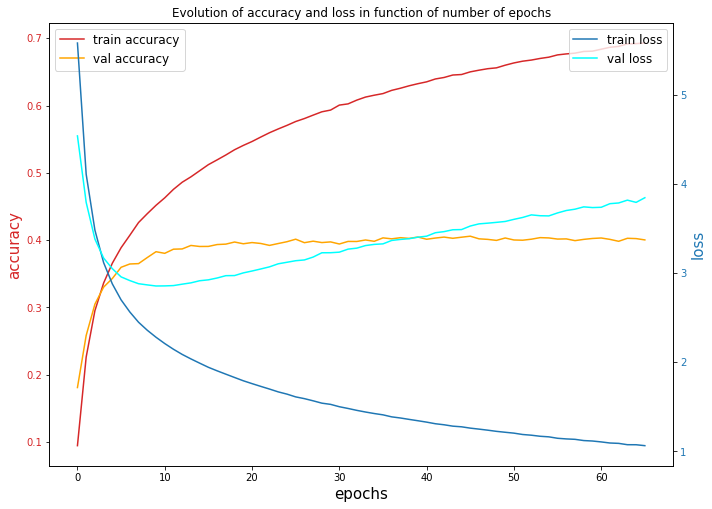

In [56]:
fig, ax1 = plt.subplots(figsize=(10,7))

color = 'tab:red'
ax1.set_xlabel('epochs', size = 15)
ax1.set_ylabel('accuracy', color=color, size = 15)
ax1.plot(epochs, acc, color=color, label = 'train accuracy')
ax1.plot(epochs, val_acc, color='orange', label = 'val accuracy')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('loss', color=color, size = 15)  # we already handled the x-label with ax1
ax2.plot(epochs, losses, color=color, label = 'train loss')
ax2.plot(epochs, val_losses, color='cyan', label = 'val loss')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Evolution of accuracy and loss in function of number of epochs")
ax1.legend(prop={'size': 12})
ax2.legend(prop={'size': 12})
plt.show()

As we could have imagined, the training loss keeps decreasing while the validation loss is at its minimum at epoch 10 and then increases (model overfits on loss). However, we are more interested in the accuracy of the model to predict the correct word. We see that the training accuracy keeps increasing while the validation accuracy becomes more less constant around epoch 20 but the accuracy does not overfit.

### Predict words from the test set

Once we have our trained model, we want to use it to compute predictions of words we could have in the testing set:

In [57]:
def load_all_data_for_genre(genre, tokenizer):
    """Helper function that loads all the useful data (neural net model, training history, 
    outnn_token_dict for samples trained on this genre...) for a given genre (path where the data are given)"""
    
    path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
    
    # Load neural net model and history
    nn_model, training_hist = load_model(path_nn, True)
    print("Genre {} , max validation accuracy: {}".format(genre, max(training_hist['val_categorical_accuracy'])))
    
    # Load dictionary of {tokens -> output in neural net}
    token_outnn_dict = load_dict(path_nn + '/token_outnn_dict')
    outnn_token_dict = dict(zip(token_outnn_dict.values(), token_outnn_dict.keys()))
    
    # Load POS files for the wanted genre
    pos_counter, word_counter, word_pos_dict = get_files_from_genre(genre)
    
    # Recreate syllables dictionnary
    syllables_dic = pyphen.Pyphen(lang = 'en')
    # pyphen dic creates new string where syllables separated by '-'
    tok_syllab_dict = {tok:len(syllables_dic.inserted(tokenizer.index_word[tok]).split('-')) for tok in token_outnn_dict.keys()}
    
    return nn_model, training_hist, token_outnn_dict, outnn_token_dict, word_pos_dict, tok_syllab_dict

In [58]:
# Load tokenizer
with open('NN_models/tokenizer', 'rb') as handle:
    tokenizer = pickle.load(handle)

# Load all the previously saved data useful for the wanted genre: neural net, sample words, POS of the words...
genre = 'pop'
pop_nn_model, pop_history, pop_token_outnn_dict, pop_outnn_token_dict, pop_word_pos_dict, pop_tok_syllab_dict = load_all_data_for_genre(genre, tokenizer)

# Load test files
path_nn = 'NN_models/' + genre + '/' + genre + '_best_200k'
test_file = path_nn + '/tests'
test = np.load(test_file + '.npz')
X_test, test_onehot_pos, test_onehot_syl, Y_test = test['array1'], test['array2'], test['array3'], test['array4']

Genre pop , max validation accuracy: 0.4058981233989692


In [59]:
def ngram_to_word(ngram, tok_word_dict):
    """
    Transform sequence of tokens to sequence of words
    """
    list_words = []
    for tok in ngram:
        if tok != 0:
            # tok == 0 -> padding at beginning
            list_words.append(tok_word_dict[tok])
    return list_words

# outnn_token_dict to map one-hot encoding prediction to the correct token
# tokenizer_index_word to map token to word
# pop_word_pos_dict to map token to part of speech

def get_predictions(nn_model, X_test, test_onehot_pos, test_onehot_syl, Y_test, batch_size, onehot_token_dict, tok_word_dict, word_pos_dict, tok_syl_dict):
    """Compute predictions of test set and display predictions compared to the real words"""
    
    predictions_onehot = nn_model.predict([X_test, test_onehot_pos, test_onehot_syl], batch_size = batch_size)
    pred_tokens = onehot_to_token(predictions_onehot, onehot_token_dict)
    
    pred_words = [tok_word_dict[tok] for tok in pred_tokens]
    real_words = [tok_word_dict[tok] for tok in Y_test]
    
    pred_pos = [word_pos_dict[w] for w in pred_words]
    real_pos = [word_pos_dict[w] for w in real_words]
    
    pred_syl = [tok_syl_dict[tok] for tok in pred_tokens]
    real_syl = [tok_syl_dict[tok] for tok in Y_test]
    
    acc_test = len([1 for i, word in enumerate(pred_words) if word == real_words[i]])/len(Y_test)
    acc_pos = len([1 for i, pos in enumerate(pred_pos) if pos == real_pos[i]])/len(Y_test)
    acc_syl = len([1 for i, syl in enumerate(pred_syl) if syl == real_syl[i]])/len(Y_test)
    
    print("Word Accuracy = {} ; POS Accuracy = {} ; Syllables Accuracy = {} \n".format(acc_test, acc_pos, acc_syl))
    
    for i, ngram in enumerate(X_test):
        seq_words = ngram_to_word(ngram, tok_word_dict)
        seq_words = ' '.join(seq_words)
        result = seq_words + ' ,' + real_words[i] + ' ----> ' + pred_words[i] + ' ( ' + real_pos[i] + ' , ' + pred_pos[i] + ' ) ; ( ' + str(real_syl[i]) + ' , ' + str(pred_syl[i]) + ' )'
        print(result)
    return pred_tokens

In [61]:
batch = 256
preds_tokens = get_predictions(pop_nn_model, X_test, test_onehot_pos, test_onehot_syl, Y_test, batch, pop_outnn_token_dict, tokenizer.index_word, pop_word_pos_dict, pop_tok_syllab_dict)


Word Accuracy = 0.40402144772117965 ; POS Accuracy = 0.998212689901698 ; Syllables Accuracy = 0.9996425379803396 

the past this is my ,second ----> private ( ADJ , ADJ ) ; ( 2 , 2 )
get messed up with you ,hello ----> alright ( INTJ , INTJ ) ; ( 2 , 2 )
whoa i whoa i ,whoa ----> yeah ( INTJ , INTJ ) ; ( 1 , 1 )
i kept you waiting for ,so ----> quite ( ADV , ADV ) ; ( 1 , 1 )
to undress it s all ,upside ----> truly ( ADV , ADV ) ; ( 2 , 2 )
own music sing your own ,special ----> grateful ( ADJ , ADJ ) ; ( 2 , 2 )
it down now voices carry ,hush ----> hush ( ADJ , ADJ ) ; ( 1 , 1 )
fills the air animals everywhere ,join ----> crank ( VERB , VERB ) ; ( 1 , 1 )
mash he did the monster ,mash ----> mash ( VERB , VERB ) ; ( 1 , 1 )
i ,may ----> woke ( VERB , VERB ) ; ( 1 , 1 )
slip away you re so ,rare ----> weird ( ADJ , ADJ ) ; ( 1 , 1 )
mountains rise standing there in ,front ----> front ( NOUN , NOUN ) ; ( 1 , 1 )
for you down down down ,karma ----> karma ( NOUN , NOUN ) ; ( 2 , 2 )
yulet

one day soon one day ,soon ----> again ( ADV , ADV ) ; ( 1 , 1 )
missed a warm embrace till ,april ----> april ( NOUN , NOUN ) ; ( 1 , 1 )
uhh uhhh if you creep ,pon ----> pon ( NOUN , NOUN ) ; ( 1 , 1 )
minute i get there the ,minute ----> way ( NOUN , NOUN ) ; ( 1 , 1 )
well i m nothing but ,trouble ----> anything ( NOUN , NOUN ) ; ( 2 , 2 )
trying to excite and mystify ,sharing ----> finding ( VERB , VERB ) ; ( 2 , 2 )
of hearing that line line ,line ----> line ( NOUN , NOUN ) ; ( 1 , 1 )
mine dynamite oh dynamite oh ,dynamite ----> dynamite ( NOUN , NOUN ) ; ( 3 , 3 )
she waits for her lover ,perhaps ----> somehow ( ADV , ADV ) ; ( 2 , 2 )
i m so dc like ,fat ----> most ( ADJ , ADJ ) ; ( 1 , 1 )
wide awake but still dreaming ,there ----> too ( ADV , ADV ) ; ( 1 , 1 )
blind would i ask a ,sane ----> sane ( ADJ , ADJ ) ; ( 1 , 1 )
taste my aiming watch me ,h ----> zoom ( NOUN , NOUN ) ; ( 1 , 1 )
bedtime prayer stickin little white ,flowers ----> feather ( NOUN , NOUN ) ; ( 2 , 2 )
o

now the way youve always ,understood ----> deliver ( VERB , VERB ) ; ( 3 , 3 )
meet her mama and papa ,louie ----> louie ( ADJ , ADJ ) ; ( 1 , 1 )
my job and my hair ,fell ----> grows ( VERB , VERB ) ; ( 1 , 1 )
be the one for me ,second ----> inner ( ADJ , ADJ ) ; ( 2 , 2 )
she s somehow closer now ,softly ----> softly ( ADV , ADV ) ; ( 2 , 2 )
i wish i wish you ,wished ----> wished ( VERB , VERB ) ; ( 1 , 1 )
wake up ,mr ----> off ( ADP , ADP ) ; ( 1 , 1 )
like an answer to a ,prayer ----> prayer ( NOUN , NOUN ) ; ( 1 , 1 )
i can t go on ,running ----> loving ( VERB , VERB ) ; ( 2 , 2 )
left me with he hangs ,up ----> round ( ADV , ADV ) ; ( 1 , 1 )
around you and so i ,beg ----> beg ( VERB , VERB ) ; ( 1 , 1 )
he held her hands she ,listened ----> whispered ( VERB , VERB ) ; ( 2 , 2 )
know to do it right ,kissin ----> gal ( NOUN , NOUN ) ; ( 1 , 1 )
me and nothing can come ,between ----> between ( ADP , ADP ) ; ( 2 , 2 )
feet i really love your ,tiger ----> tiger ( NOUN , NOUN ) ; (

me and i believe that ,faith ----> fact ( NOUN , NOUN ) ; ( 1 , 1 )
those years all those lies ,cling ----> stolen ( VERB , VERB ) ; ( 1 , 1 )
nana na nana na nana ,nana ----> nana ( NOUN , NOUN ) ; ( 1 , 1 )
t never had good love ,till ----> ga ( ADP , ADP ) ; ( 1 , 1 )
this bitch throwin up the ,seventeen ----> seventeen ( NUM , NUM ) ; ( 3 , 3 )
a tidal wave and sorrow ,swept ----> helps ( VERB , VERB ) ; ( 1 , 1 )
take a ride on my ,roller ----> roller ( NOUN , NOUN ) ; ( 1 , 1 )
so good it s just ,understood ----> remember ( VERB , VERB ) ; ( 3 , 3 )
you are marry me bracing ,facing ----> slipping ( VERB , VERB ) ; ( 2 , 2 )
t stand another chance he ,belongs ----> stumble ( VERB , VERB ) ; ( 2 , 2 )
you i would be running ,ohoh ----> ohoh ( NOUN , NOUN ) ; ( 1 , 1 )
thicker it becomes and the ,more ----> same ( ADJ , ADJ ) ; ( 1 , 1 )
i ever let you down ,cos ----> among ( ADP , ADP ) ; ( 1 , 1 )
again on me you can ,depend ----> depend ( VERB , VERB ) ; ( 2 , 2 )
twice never lea

can do when the fire ,burns ----> burns ( VERB , VERB ) ; ( 1 , 1 )
each other like professional wrestlers ,further ----> nigga ( ADV , ADV ) ; ( 2 , 2 )
oo oo maria oo oo ,oo ----> oo ( ADP , ADP ) ; ( 1 , 1 )
journey this day ends together ,far ----> ago ( ADV , ADV ) ; ( 1 , 1 )
ooh ,ooh ----> ooh ( INTJ , INTJ ) ; ( 1 , 1 )
there when you re feeling ,empty ----> empty ( ADJ , ADJ ) ; ( 2 , 2 )
while she s awake she ,takes ----> hears ( VERB , VERB ) ; ( 1 , 1 )
street ev rybody that i ,meet ----> loved ( VERB , VERB ) ; ( 1 , 1 )
my life sixteen clumsy and ,shy ----> weird ( ADJ , ADJ ) ; ( 1 , 1 )
poets for our dreams throwing ,feather ----> fantasies ( NOUN , NOUN ) ; ( 2 , 2 )
me and everything went all ,spinning ----> saying ( VERB , VERB ) ; ( 2 , 2 )
side cuddle up in a ,sleigh ----> dizzy ( ADJ , ADJ ) ; ( 1 , 1 )
keeps on burning and nobody ,knows ----> cares ( VERB , VERB ) ; ( 1 , 1 )
swim a single note he ,threw ----> pulls ( VERB , VERB ) ; ( 1 , 1 )
can not leave you a

ve been protective on a ,case ----> wheel ( NOUN , NOUN ) ; ( 1 , 1 )
the air with our blankets ,tight ----> aside ( ADV , ADV ) ; ( 1 , 1 )
be out there in the ,street ----> street ( NOUN , NOUN ) ; ( 1 , 1 )
to the days of christopher ,robin ----> robin ( NOUN , NOUN ) ; ( 1 , 1 )
s all about my feelings ,from ----> till ( ADP , ADP ) ; ( 1 , 1 )
all my rules got me ,tripping ----> tripping ( VERB , VERB ) ; ( 2 , 2 )
fucked your man boom i ,fucked ----> fucked ( VERB , VERB ) ; ( 1 , 1 )
my v i p colorful ,diamonds ----> diamonds ( NOUN , NOUN ) ; ( 3 , 3 )
wee crank that weezy wee ,crank ----> crank ( VERB , VERB ) ; ( 1 , 1 )
challenge you re doing to ,much ----> wrong ( ADJ , ADJ ) ; ( 1 , 1 )
in the morning when i ,wake ----> wake ( VERB , VERB ) ; ( 1 , 1 )
bleak side of the american ,experience ----> celebration ( NOUN , NOUN ) ; ( 4 , 4 )
your game i ve been ,watching ----> saving ( VERB , VERB ) ; ( 2 , 2 )
know i didn t wanna ,live ----> write ( VERB , VERB ) ; ( 1 , 1 )
tr

For the pop genre, the accuracy of predicting the exact same word from the testing set is 40 \% which is quite good because the neural network predicts one output over more than a thousand. The accuracy is the same as with the validation set in the neural network which is normal. The correct POS prediction is 99 \% as well as for the syllables accuracy. The results for the other genres is given below:

In [62]:
# Accuracies given from the test data
info_dict = {'pop':[0.4040, 0.9982, 0.9996], 'rock':[0.3174, 0.9819, 0.9996], 'metal':[0.2579, 0.9620, 0.9993], 'jazz':[0.4690, 0.9738, 0.9989], 'country':[0.3781, 0.9751, 0.9994], 'hiphop':[0.2512, 0.9216, 0.9997]}
info_df = pd.DataFrame.from_dict(info_dict)
info_df.rename(index = {0:'accuracy word', 1:'accuracy POS', 2:'accuracy syllables'})

,pop,rock,metal,jazz,country,hiphop
accuracy word,0.4040,0.3174,0.2579,0.4690,0.3781,0.2512
accuracy POS,0.9982,0.9819,0.9620,0.9738,0.9751,0.9216
accuracy syllables,0.9996,0.9996,0.9993,0.9989,0.9994,0.9997


### Lyrics Generation for a specific genre

We first need to predict what would be the next Parts Of Speech based on the one of the last word we have:

In [63]:
pos_counts = pickle.load(open("NN_models/pos_counts.p", "rb" ))
pos2idx = pickle.load(open("NN_models/pos2idx.p", "rb"))
pos_to_keep = {'INTJ','NOUN','ADV','PRON','VERB','ADP','DET','CCONJ','ADJ','NUM','PROPN'} 

def predict_next_pos(curr_pos):
    prob = pos_counts[pos2idx[curr_pos]]
    next_pos = ''
    while next_pos not in pos_to_keep:
        # Only predict a POS in the set that we trained on
        next_pos = np.random.choice(list(prob.keys()), p=list(prob.values()))
    return next_pos

predict_next_pos('NOUN')

'CCONJ'

In [64]:
# word_pos_dict = pop_word_pos_dict
# pos_index_dict
# syl_index_dict
# onehot_token_dict = outnn_token_dict
def generate_lyrics(nn_model, init_string, tokenizer, word_pos_dict, pos_index_dict, onehot_token_dict, words_to_generate = 20):
    """Function that generates lyrics by taking an initial string and predicts the next words by feeding input in the neural network"""
    # Convert string to list of tokens:
    init_list_words = init_string.split(' ')[-(n - 1):]
    init_list_tokens = [tokenizer.word_index[w] for w in init_list_words]
    
    # Get POS of last word:
    last_pos = [word_pos_dict[w] for w in init_list_words][-1]
    
    # Generate next tokens with the neural network
    tokens_list = init_list_tokens.copy()
    list_pos = []
    for i in range(words_to_generate):
        input_tokens = tokens_list[i:]
        
        pos_to_predict = predict_next_pos(last_pos)
        _, input_pos = token_to_onehot([pos_to_predict], pos_index_dict)
        # Syllables has no importance for generation of next words, if you want word with specific number of syllable, change next line
        input_syl = [0.0, 0.0, 0.0, 0.0]
        
        pred_onehot = nn_model.predict([[input_tokens], input_pos, [input_syl]])
        pred_token = onehot_to_token(pred_onehot, onehot_token_dict)
        real_pos = word_pos_dict[tokenizer.index_word[pred_token[0]]]
        
        tokens_list.append(pred_token[0])
        list_pos.append((pos_to_predict, real_pos))
        last_pos = real_pos
        
    
    # Convert tokens into a phrase
    list_words = ngram_to_word(tokens_list, tokenizer.index_word)
    sentence = ' '.join(list_words)
    print("Part of Speech (expected, predicted) ---> {} \n".format(list_pos))
    return sentence

In [65]:
initial = 'i m in love with'
generated_lyrs = generate_lyrics(pop_nn_model, initial, tokenizer, pop_word_pos_dict, pos_index_dict, pop_outnn_token_dict, words_to_generate = 40)
print(generated_lyrs)

Part of Speech (expected, predicted) ---> [('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('PRON', 'ADJ'), ('VERB', 'ADJ'), ('NOUN', 'NOUN'), ('VERB', 'VERB'), ('PRON', 'ADJ'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('VERB', 'VERB'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('ADP', 'ADP'), ('PRON', 'PRON'), ('PRON', 'PRON'), ('ADP', 'ADP'), ('DET', 'DET'), ('NOUN', 'NOUN'), ('CCONJ', 'CCONJ'), ('VERB', 'VERB'), ('DET', 'DET'), ('ADJ', 'ADJ')] 

i m in love with every minute underneath yah satisfy it satisfy underneath yah underneath another cloud we appreciate ourselves worship everlasting everlasting joy worship everlasting inspiration underneath itself traveling another mountain underneath another tree

We can see that this lyrics generations sometimes has not much sense and it can predict the same word again and again. The generation could have been better by predicting the next POS not only on the POS of the last word but on the POS of the 2 or 3 last words.

#### Convert lyrics from one genre to another one:

Let's check the lyrics we can get from one genre: pop for instance to the other genres

In [66]:
# Pick a pop song that has some interesting words that we could change
pop_song = list_lyrs_pop[5600]
print(' '.join(pop_song) + '\n')

pos_index_dict = load_dict('NN_models/POS_index_dict')
syl_index_dict = load_dict('NN_models/syllables_index_dict')
n = 6 # for ngrams: size of tokens input of neural network, typically 6

syllables_dic = pyphen.Pyphen(lang = 'en')
# pyphen dic creates new string where syllables separated by '-'
tok_syllab_dict = {tok:len(syllables_dic.inserted(tokenizer.index_word[tok]).split('-')) for tok in token_outnn_dict.keys()}

check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin doors 245 n pullin the keys now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed stealing from the spot that i truly chosed i lose and my choice to chose now i m fix and i m fallin deeper in the mix there s no hope for me see my path has been chosen i m johnny be chorus johnny behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh johnny be chorus the situation s tight you are billin by the night can t choose between the wrongs and the rights i m searchin for the clues yowhat am i gotta do i got the habit to take valuable things from you here i stand and i 

In [67]:
# Get the words that we would like to change and get the inputs to feed the neural network
def get_words_to_change(lyrics, genre_typical_words, genre_word_pos_dict, amount = 10):
    """
    Function that gets the most common words in the lyrics given a sorted list for a specific genre
    lyrics: list of strings (the lyrics of a song)
    genre_typical_words: the sorted list of typical words of a genre (pop_diff_list for pop), format: tuples (word, diff_count)
    amount: the number of words we want to change in the lyrics
    """
    words_to_change = []
    words_to_change_pos = []
    found_words = 0 
    for w, _ in genre_typical_words:
        if w in lyrics:
            words_to_change.append(w)
            words_to_change_pos.append([(word, i) for i, word in enumerate(lyrics) if word == w])
            found_words += 1
        if found_words == amount:
            break
    print("List of words to change in the lyrics: {}".format(words_to_change))
    words_to_change_pos = [w for l in words_to_change_pos for w in l]
    words_to_change_pos = sorted(words_to_change_pos, key = lambda x: x[1])
    
    tokens_to_change = [tokenizer.word_index[w] for w in words_to_change]
    lyrics_tokens = (n - 1) * [0] + [tokenizer.word_index[w] for w in lyrics] # Append 0 tokens at beginning in case of 
    
    # Get the tokens ngrams for sentences before the tokens to change (input of the neural net)
    ngrams_with_output = np.array(ngram_lyrics(n, lyrics_tokens, samples_tokens = tokens_to_change))
    input_ngrams = ngrams_with_output[:,:-1]
    output = ngrams_with_output[:,-1]
    
    # Get the POS of tokens that we want to predict
    tok_pos_dict = {tokenizer.word_index[w] : genre_word_pos_dict[w] for w in words_to_change}
    _, input_onehot_pos = token_to_onehot(output, pos_index_dict, tok_pos_dict)
    
    # Get the #syllables of tokens that we want to predict
    tok_syllab_dict = {tokenizer.word_index[w]:len(syllables_dic.inserted(w).split('-')) for w in words_to_change}
    _, input_onehot_syl = token_to_onehot(output, syl_index_dict, tok_syllab_dict)
    
    nn_input = [input_ngrams, input_onehot_pos, input_onehot_syl]
    return nn_input, output

pop_nn_input, pop_output = get_words_to_change(pop_song, pop_diff_list, pop_word_pos_dict, amount = 25)

List of words to change in the lyrics: ['sleepless', 'frightened', 'stealing', 'searchin', 'habit', 'rights', 'spirits', 'drifting', 'chose', 'chosen', 'truly', 'situation', 'johnny', 'certain', 'mix', 'fallin', 'keys', 'deeper', 'callin', 'fix', 'calls', 'repeat', 'trapped', 'breeze', 'doors']


In [68]:
from IPython.display import Markdown, display

def predict_new_words(g2_nn_model, g1_nn_input, outputs_tokens, g2_outnn_token_dict):
    """
    Given neural network of other genre (g2) and input of genre 1 (g1) from the song, compute the prediction from g1 to g2 
    """
    predictions_onehot = g2_nn_model.predict(g1_nn_input)
    pred_tokens = onehot_to_token(predictions_onehot, g2_outnn_token_dict)
    
    pred_words = [tokenizer.index_word[tok] for tok in pred_tokens]
    real_words = [tokenizer.index_word[tok] for tok in outputs_tokens]
    
    return list(zip(real_words, pred_words))

def printmd(string):
    display(Markdown(string))

def get_new_lyrics(lyrics, real_pred_list):
    """
    Function that gives the new lyrics based on predictions generated from the other genre
    real_pred_list: sorted list of apparition of tuples: (real word, predicted word)
    """
    # real_pred_list sorted in order of apparition
    new_lyrics = []
    idx = 0
    for w in lyrics:
        if idx < len(real_pred_list):
            real_w, pred_w = real_pred_list[idx]
        if w == real_w:
            new_lyrics.append('**' + pred_w + '**')
            idx += 1
        else:
            new_lyrics.append(w)
    print("Converted lyrics:")
    printmd(' '.join(new_lyrics) + '\n')
    return new_lyrics
    

Predict to metal genre:

In [69]:
genre = 'metal'
metal_nn_model, _, _, metal_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre metal , max validation accuracy: 0.26767676764392767


In [70]:
metal_preds_list = predict_new_words(metal_nn_model, pop_nn_input, pop_output, metal_outnn_token_dict)
metal_pop_lyrs = get_new_lyrics(pop_song, metal_preds_list)

print(metal_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **wit** 245 n pullin the **road** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **revealed** from the spot that i **nigga** chosed i lose and my choice to **sell** now i m **telling** and i m **comin** **little** in the **abyss** there s no hope for me see my path has been **unleashed** i m **centuries** be chorus **chorus** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **chorus** be chorus the **infinity** s tight you are billin by the night can t choose between the wrongs and the **anger** i m **free** for the clues yowhat am i gotta do i got the **rules** to take valuable things from you here i stand and i m physically **can** by my tent **staring** northern **oceans** is this adman a lonely path when i stand alone a round by my own here i lay down into **hopeless** dephts two **warriors** **rip** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **unseen** huh you should be who am i i m **nothing** be chorus here we go here we go now check the flow here we go **nothing** beis in control **attack** it s a **problem** night he s **dragon** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **murder** my friend it s not what it seems **niggas** chorus twice


[('doors', 'wit'), ('keys', 'road'), ('stealing', 'revealed'), ('truly', 'nigga'), ('chose', 'sell'), ('fix', 'telling'), ('fallin', 'comin'), ('deeper', 'little'), ('mix', 'abyss'), ('chosen', 'unleashed'), ('johnny', 'centuries'), ('johnny', 'chorus'), ('johnny', 'chorus'), ('situation', 'infinity'), ('rights', 'anger'), ('searchin', 'free'), ('habit', 'rules'), ('trapped', 'can'), ('drifting', 'staring'), ('breeze', 'oceans'), ('certain', 'hopeless'), ('spirits', 'warriors'), ('calls', 'rip'), ('frightened', 'unseen'), ('johnny', 'nothing'), ('johnny', 'nothing'), ('repeat', 'attack'), ('sleepless', 'problem'), ('callin', 'dragon'), ('johnny', 'murder'), ('repeat', 'niggas')]


Predict to rock genre:

In [71]:
genre = 'rock'
rock_nn_model, _, _, rock_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre rock , max validation accuracy: 0.3194070080541215


In [72]:
rock_preds_list = predict_new_words(rock_nn_model, pop_nn_input, pop_output, rock_outnn_token_dict)
rock_pop_lyrs = get_new_lyrics(pop_song, rock_preds_list)

print(rock_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **tin** 245 n pullin the **pony** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **covered** from the spot that i **simply** chosed i lose and my choice to **speak** now i m **strung** and i m **talkin** **jenny** in the **tides** there s no hope for me see my path has been **taken** i m **nothing** be chorus **brother** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **motel** be chorus the **revolution** s tight you are billin by the night can t choose between the wrongs and the **knives** i m **amazed** for the clues yowhat am i gotta do i got the **key** to take valuable things from you here i stand and i m physically **screwed** by my tent **writing** northern **heat** is this adman a lonely path when i stand alone a round by my own here i lay down into **deepest** dephts two **buildings** **ran** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **satan** huh you should be who am i i m **outta** be chorus here we go here we go now check the flow here we go **something** beis in control **vision** it s a **breakdown** night he s **gettin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **dreamers** my friend it s not what it seems **doctor** chorus twice


[('doors', 'tin'), ('keys', 'pony'), ('stealing', 'covered'), ('truly', 'simply'), ('chose', 'speak'), ('fix', 'strung'), ('fallin', 'talkin'), ('deeper', 'jenny'), ('mix', 'tides'), ('chosen', 'taken'), ('johnny', 'nothing'), ('johnny', 'brother'), ('johnny', 'motel'), ('situation', 'revolution'), ('rights', 'knives'), ('searchin', 'amazed'), ('habit', 'key'), ('trapped', 'screwed'), ('drifting', 'writing'), ('breeze', 'heat'), ('certain', 'deepest'), ('spirits', 'buildings'), ('calls', 'ran'), ('frightened', 'satan'), ('johnny', 'outta'), ('johnny', 'something'), ('repeat', 'vision'), ('sleepless', 'breakdown'), ('callin', 'gettin'), ('johnny', 'dreamers'), ('repeat', 'doctor')]


Predict to jazz genre:

In [73]:
genre = 'jazz'
jazz_nn_model, _, _, jazz_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre jazz , max validation accuracy: 0.4808471452684912


In [74]:
jazz_preds_list = predict_new_words(jazz_nn_model, pop_nn_input, pop_output, jazz_outnn_token_dict)
jazz_pop_lyrs = get_new_lyrics(pop_song, jazz_preds_list)

print(jazz_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **jack** 245 n pullin the **bass** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **destroy** from the spot that i **never** chosed i lose and my choice to **fight** now i m **tied** and i m **shakin** **deeper** in the **wind** there s no hope for me see my path has been **covered** i m **longing** be chorus **johnny** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **doggone** be chorus the **mississippi** s tight you are billin by the night can t choose between the wrongs and the **years** i m **guilty** for the clues yowhat am i gotta do i got the **st** to take valuable things from you here i stand and i m physically **raised** by my tent **lying** northern **stream** is this adman a lonely path when i stand alone a round by my own here i lay down into **second** dephts two **women** **bound** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **welcome** huh you should be who am i i m **longing** be chorus here we go here we go now check the flow here we go **mountains** beis in control **flower** it s a **mystery** night he s **waitin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **shadow** my friend it s not what it seems **mystery** chorus twice


[('doors', 'jack'), ('keys', 'bass'), ('stealing', 'destroy'), ('truly', 'never'), ('chose', 'fight'), ('fix', 'tied'), ('fallin', 'shakin'), ('deeper', 'deeper'), ('mix', 'wind'), ('chosen', 'covered'), ('johnny', 'longing'), ('johnny', 'johnny'), ('johnny', 'doggone'), ('situation', 'mississippi'), ('rights', 'years'), ('searchin', 'guilty'), ('habit', 'st'), ('trapped', 'raised'), ('drifting', 'lying'), ('breeze', 'stream'), ('certain', 'second'), ('spirits', 'women'), ('calls', 'bound'), ('frightened', 'welcome'), ('johnny', 'longing'), ('johnny', 'mountains'), ('repeat', 'flower'), ('sleepless', 'mystery'), ('callin', 'waitin'), ('johnny', 'shadow'), ('repeat', 'mystery')]


Predict to country genre:

In [75]:
genre = 'country'
country_nn_model, _, _, country_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre country , max validation accuracy: 0.3879162702358529


In [76]:
country_preds_list = predict_new_words(country_nn_model, pop_nn_input, pop_output, country_outnn_token_dict)
country_pop_lyrs = get_new_lyrics(pop_song, country_preds_list)

print(country_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **porch** 245 n pullin the **boots** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **cover** from the spot that i **already** chosed i lose and my choice to **cut** now i m **knowin** and i m **losin** **deeper** in the **rain** there s no hope for me see my path has been **begun** i m **travelin** be chorus **johnny** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **sweetheart** be chorus the **mississippi** s tight you are billin by the night can t choose between the wrongs and the **roads** i m **afraid** for the clues yowhat am i gotta do i got the **news** to take valuable things from you here i stand and i m physically **crossed** by my tent **staring** northern **cloud** is this adman a lonely path when i stand alone a round by my own here i lay down into **dixie** dephts two **stories** **shall** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **deeper** huh you should be who am i i m **drivin** be chorus here we go here we go now check the flow here we go **preacher** beis in control **yonder** it s a **jukebox** night he s **drivin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **horses** my friend it s not what it seems **laughter** chorus twice


[('doors', 'porch'), ('keys', 'boots'), ('stealing', 'cover'), ('truly', 'already'), ('chose', 'cut'), ('fix', 'knowin'), ('fallin', 'losin'), ('deeper', 'deeper'), ('mix', 'rain'), ('chosen', 'begun'), ('johnny', 'travelin'), ('johnny', 'johnny'), ('johnny', 'sweetheart'), ('situation', 'mississippi'), ('rights', 'roads'), ('searchin', 'afraid'), ('habit', 'news'), ('trapped', 'crossed'), ('drifting', 'staring'), ('breeze', 'cloud'), ('certain', 'dixie'), ('spirits', 'stories'), ('calls', 'shall'), ('frightened', 'deeper'), ('johnny', 'drivin'), ('johnny', 'preacher'), ('repeat', 'yonder'), ('sleepless', 'jukebox'), ('callin', 'drivin'), ('johnny', 'horses'), ('repeat', 'laughter')]


Predict to hip hop genre:

In [77]:
genre = 'hiphop'
hip_nn_model, _, _, hip_outnn_token_dict, _, _ = load_all_data_for_genre(genre, tokenizer)

Genre hiphop , max validation accuracy: 0.2541998231284498


In [78]:
hip_preds_list = predict_new_words(hip_nn_model, pop_nn_input, pop_output, hip_outnn_token_dict)
hip_pop_lyrs = get_new_lyrics(pop_song, hip_preds_list)

print(hip_preds_list)

Converted lyrics:


check it out it s eleventhirty my hand is getting dirty snatchin up things that probably can t be worth it now this is a vision of a violent life livin by a gun and totem of the night i m slammin **cats** 245 n pullin the **keys** now these are the valuable luxuries to me at the early dawn before you yawn i ve been there swiped you and then i m gone now it s my heart tictacs a black satin bag full of bad ass rocks my identity has to be exposed **approach** from the spot that i **hardly** chosed i lose and my choice to **float** now i m **bringin** and i m **bustin** **lower** in the **joint** there s no hope for me see my path has been **written** i m **thuggin** be chorus **busta** behow much there is to see just open your eyes and listen to me straight ahead a green light turns to red ooh why can t you see ooh **sippin** be chorus the **motherfucker** s tight you are billin by the night can t choose between the wrongs and the **homies** i m **catchin** for the clues yowhat am i gotta do i got the **cheese** to take valuable things from you here i stand and i m physically **trapped** by my tent **faded** northern **gats** is this adman a lonely path when i stand alone a round by my own here i lay down into **concrete** dephts two **killas** **split** grabs my very last breath sometimes i wish in my path a simple gesture or a simple laugh but i m evil dirty and mean two pounds blood pass through my bloodstream **ninja** huh you should be who am i i m **tryna** be chorus here we go here we go now check the flow here we go **brooklyn** beis in control **somebody** it s a **planet** night he s **gettin** your name it s a lonely ride i know how you saw him again and again he s dressin his dreams yeah **thuggin** my friend it s not what it seems **somethin** chorus twice


[('doors', 'cats'), ('keys', 'keys'), ('stealing', 'approach'), ('truly', 'hardly'), ('chose', 'float'), ('fix', 'bringin'), ('fallin', 'bustin'), ('deeper', 'lower'), ('mix', 'joint'), ('chosen', 'written'), ('johnny', 'thuggin'), ('johnny', 'busta'), ('johnny', 'sippin'), ('situation', 'motherfucker'), ('rights', 'homies'), ('searchin', 'catchin'), ('habit', 'cheese'), ('trapped', 'trapped'), ('drifting', 'faded'), ('breeze', 'gats'), ('certain', 'concrete'), ('spirits', 'killas'), ('calls', 'split'), ('frightened', 'ninja'), ('johnny', 'tryna'), ('johnny', 'brooklyn'), ('repeat', 'somebody'), ('sleepless', 'planet'), ('callin', 'gettin'), ('johnny', 'thuggin'), ('repeat', 'somethin')]


[Go to top](#top)

<a id="site"></a>

## Webpage

- Mettre lien vers les fichiers nécessaires
- Commande à lancer
- Screenshots

[Go to top](#top)